# Diplomski rad 06
28\. 6. 2017.

In [ ]:
#coding=utf-8
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import graphviz as gv

import networkx as nx
import pydot
import os
from utility.log_progress import log_progress
from importlib import reload
import utility.functions
reload(utility.functions)
from utility.functions import *
from collections import Counter

matplotlib.rcParams['figure.figsize'] = (12, 8)

## S&P full

In [2]:
spfull = np.load('data/sp_stock_prices.npy')
spstocks = np.load('data/sp_stocks.npy')
spdates = np.load('data/sp_price_dates.npy')
spchangedates = np.load('data/sp_change_dates.npy')
spchangelist = np.load('data/sp_change_list.npy')

days, N = spfull.shape
P = N * (N - 1) // 2
spfull_log = np.log(spfull)

T = 60

In [3]:
print(np.sum(np.isnan(spfull)))

# NaN fix
for t in range(1, spfull.shape[0]):
    where_nan, = np.where(np.isnan(spfull[t]))
    spfull[t, where_nan] = spfull[t - 1, where_nan]

for t in range(spfull.shape[0] - 1, 0, -1):
    where_nan, = np.where(np.isnan(spfull[t - 1]))
    spfull[t - 1, where_nan] = spfull[t, where_nan]

spfull_log = np.log(spfull)
print(np.sum(np.isnan(spfull)))

1346966
0


In [3]:
spchangesets = [set(s) for s in [[p for p in r if p != ''] for r in spchangelist.T]]
split_points, = np.where(np.vectorize(lambda s: s in spchangedates)(spdates))
# split_points je za jedan kraći od changesets-a (na kraju)
# prvi split point je 54, a period T je 60, da bude lakše stavit ćemo da je prvi split point 60
if split_points[0] < T:
    split_points[0] = T

print(split_points)
print(np.diff(split_points))
print(list(map(len, spchangesets)))

[  60  119  189  254  314  384  449  514  579  644  709  774  839  904  969
 1034 1099 1164 1229 1294 1359 1424 1489 1554 1619 1689 1754 1819 1884 1949
 2014 2079 2144 2209 2274 2339 2404 2469 2534 2599 2664 2729 2794 2859 2924
 2989 3059 3124 3184 3254 3319 3384 3449 3514 3579 3644 3709 3774 3839 3904
 3969 4034 4099 4164 4229 4294 4359 4424 4489 4554 4624 4689 4753 4819 4884
 4949 5014 5079 5144 5209 5274 5339 5404 5469 5534 5599 5664 5729 5794 5859
 5929 5994 6054 6124 6189 6254 6319 6384 6449 6514 6579 6644 6709 6774]
[59 70 65 60 70 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 70
 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 70 65 60 70 65
 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 70 65 64 66 65 65
 65 65 65 65 65 65 65 65 65 65 65 65 65 65 70 65 60 70 65 65 65 65 65 65 65
 65 65 65]
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 5

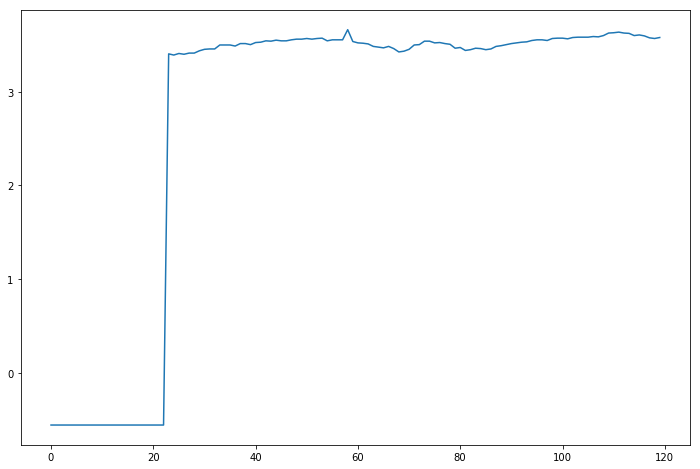

In [443]:
profit = []
shares = []
ts_plot = []
exp_tops = []
exp_bottoms = []

for i in log_progress(range(len(split_points[:10]))):
    stock_set = spchangesets[i]
    start_date = spdates[i]
    end_date = spdates[i + 1] if i < len(split_points) else spdates[-2]
    start_point = split_points[i]
    end_point = split_points[i + 1] + 1 if i < len(split_points) - 1 else len(spdates) - 1
    stock_prices = spfull_log[start_point - T:end_point, np.where(np.vectorize(lambda s: s in stock_set)(spstocks))[0]]
    
    plt.plot(stock_prices[:, 96])
    break
    
    days, N = stock_prices.shape
    spfull_log_diffs = calculate_pairwise_diffs(stock_prices)
    spfull_log_diff_means, spfull_log_diff_vars = rolling_mean_variance(spfull_log_diffs, T)
    ts, pairs, weights = statistical_arbitrage(spfull_log_diffs, spfull_log_diff_means, spfull_log_diff_vars, p=None, d=3.75,
                                               method='thresh-devs', return_profits=False, return_pairs=True, return_weights=True, offset=0)
    
    ppairs = partition_as(ts, pairs, weights)
    for t, ppair, weight in list(ppairs):
        preferences, c = calculate_preference_flow(ppair, weights=weight, return_consistency=True)
        # c = a + (1 - a) * c ** b
        # c = 0.5 + np.sqrt(c) / 2
        # c = 0.8 + c * 0.2
        c = 1.0
        m = np.max(np.abs(list(preferences.values())))
        # n = np.min(list(preferences.values()))
        tops = np.array([k for k, v in preferences.items() if v >= m * c])
#         tops = np.array([k for k, v in preferences.items() if -m * c >= v])
        # tops = np.array([])
        bottoms = np.array([k for k, v in preferences.items() if -m * c >= v])
#         bottoms = np.array([k for k, v in preferences.items() if v >= m * c])
        p = []
        if len(tops) != 0:
            ttops = np.array([t] * len(tops))
            p.extend(trade_singles(stock_prices, ttops, tops, inv=False))
            shares.extend(tops)
            ts_plot.extend(ttops)
        if len(bottoms) != 0:
            tbottoms = np.array([t] * len(bottoms))
            p.extend(trade_singles(stock_prices, tbottoms, bottoms, inv=True))
            shares.extend(bottoms)
            ts_plot.extend(tbottoms)
        if len(tops) == 0:
            ts_plot.append(t)
            profit.append(0)
        exp_tops += [set(tops)]
        exp_bottoms += [set(bottoms)]
        profit.extend([p_ / len(p) for p_ in p])

shares = np.array(shares)
ts_plot = np.array(ts_plot)
profit = np.array(profit)

T: 60
d: 3.75
a: 0.5, b: 2
Avg (year): 0.62782
Stddev (year): 1.35593
Sharpe ratio (year): 0.46302
Profit:
  positive only: 13.51998
  negative only: -10.92458
  total: 2.59540
  positive to negative ratio: 1.23757
Average accuracy: 0.29870
Average turnovers (range [0, 2]):
  top: 0.56790
  bottom: 0.94599
  total: 0.75694
Total turnovers:
  top: 368.00000
  bottom: 613.00000
  total: 981.00000
Actual profit, if transaction cost were 0.1%: 1.61440


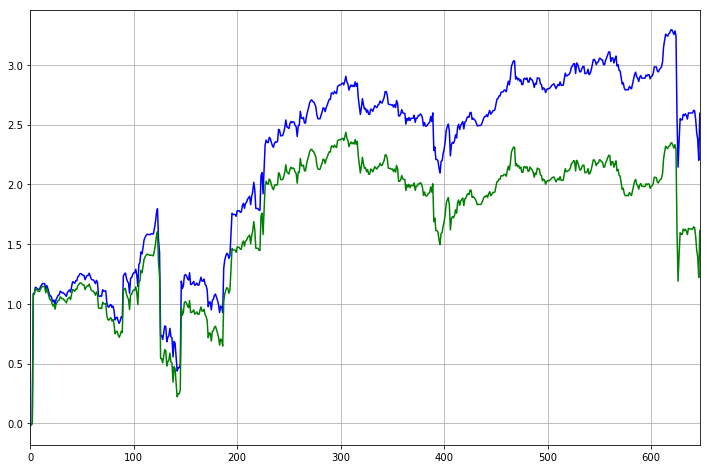

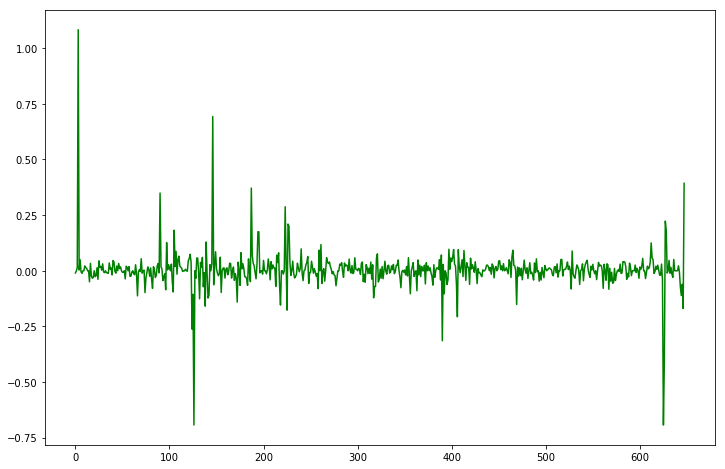

In [429]:
turnover_top = turnover_ratio(exp_tops)
turnover_bottom = turnover_ratio(exp_bottoms)

ts1, profit1 = join_ts_profit(ts_plot, profit)

plt.figure()
plt.plot(np.cumsum(profit1), 'b')
plt.plot(np.cumsum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3), 'g')
# plt.legend(['bez troškova trgovanja', 'troškovi trgovanja 0.10%'], loc='best')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()

plt.figure()
plt.plot(profit1, 'g')

avg = np.mean(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * 252
std = np.std(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * np.sqrt(252)
sharpe = avg / std

total_positive = np.sum(profit[np.greater(profit, 0.0)])
total_negative = np.sum(profit[np.less_equal(profit, 0.0)])

try:
    print('T: {}'.format(T))
    print('d: {}'.format(d))
    print('a: {}, b: {}'.format(a, b))
    print('Avg (year): {:.5f}'.format(avg))
    print('Stddev (year): {:.5f}'.format(std))
    print('Sharpe ratio (year): {:.5f}'.format(sharpe))
    print('Profit:')
    print('  positive only: {:.5f}'.format(total_positive))
    print('  negative only: {:.5f}'.format(total_negative))
    print('  total: {:.5f}'.format(total_positive + total_negative))
    print('  positive to negative ratio: {:.5f}'.format(-total_positive / total_negative))
    print('Average accuracy: {:.5f}'.format(np.count_nonzero(np.greater(profit, 0.0)) / len(profit)))
    print('Average turnovers (range [0, 2]):')
    print('  top: {:.5f}'.format(np.mean(turnover_top)))
    print('  bottom: {:.5f}'.format(np.mean(turnover_bottom)))
    print('  total: {:.5f}'.format(np.mean(np.hstack([turnover_bottom, turnover_top]))))
    print('Total turnovers:')
    print('  top: {:.5f}'.format(np.sum(turnover_top)))
    print('  bottom: {:.5f}'.format(np.sum(turnover_bottom)))
    print('  total: {:.5f}'.format(np.sum(np.hstack([turnover_bottom, turnover_top]))))
    print('Actual profit, if transaction cost were 0.1%: {:.5f}'.format(
        np.sum(profit) - np.sum(np.hstack([turnover_bottom, turnover_top])) * 1e-3))
except ZeroDivisionError:
    pass

## SPDR

In [230]:
spdr = np.load('data/spdr_prices.npy')
days, N = spdr.shape
P = N * (N - 1) // 2
spdr_log = np.log(spdr)
spdr_log_diffs = calculate_pairwise_diffs(spdr_log)

In [264]:
T = 60
p = None
d = 3.75
method = 'thresh-devs'
spdr_log_diff_means, spdr_log_diff_vars = rolling_mean_variance(spdr_log_diffs, T)
ts, profits, pairs, weights = statistical_arbitrage(spdr_log_diffs, spdr_log_diff_means, spdr_log_diff_vars, p=p, d=d,
                                                    method=method, return_pairs=True, return_weights=True)

In [370]:
ppairs = partition_as(ts, pairs, weights)
profit = []
shares = []
ts_plot = []
exp_tops = []
exp_bottoms = []
a = 0.5
b = 2
for t, ppair, weight in log_progress(list(ppairs)):
    preferences, c = calculate_preference_flow(ppair, weights=weight, scale=False, return_consistency=True)
    c = a + (1 - a) * c ** b
    # c = 0.5 + np.sqrt(c) / 2
    # c = 0.8 + c * 0.2
    m = np.max(np.abs(list(preferences.values())))
    # n = np.min(list(preferences.values()))
    tops = np.array([k for k, v in preferences.items() if v >= m * c])
    # tops = np.array([])
    bottoms = np.array([k for k, v in preferences.items() if -m * c >= v])
    p = []
    if len(tops) != 0:
        ttops = np.array([t] * len(tops))
        p.extend(trade_singles(spdr_log, ttops, tops, inv=False))
        shares.extend(tops)
        ts_plot.extend(ttops)
    if len(bottoms) != 0:
        tbottoms = np.array([t] * len(bottoms))
        p.extend(trade_singles(spdr_log, tbottoms, bottoms, inv=True))
        shares.extend(bottoms)
        ts_plot.extend(tbottoms)
    if len(tops) == 0:
        ts_plot.append(t)
        profit.append(0)
    exp_tops += [set(tops)]
    exp_bottoms += [set(bottoms)]
    profit.extend([p_ / len(p) for p_ in p])
    
shares = np.array(shares)
ts_plot = np.array(ts_plot)
profit = np.array(profit)

IndexError: index 129 is out of bounds for axis 1 with size 9

T: 60
d: 3.75
a: 0.5, b: 2
Avg (year): 0.15581
Stddev (year): 1.00514
Sharpe ratio (year): 0.15501
Profit:
  positive only: 19.54201
  negative only: -16.82549
  total: 2.71653
  positive to negative ratio: 1.16145
Average accuracy: 0.30180
Average turnovers (range [0, 2]):
  top: 0.62500
  bottom: 0.90585
  total: 0.76543
Total turnovers:
  top: 790.00000
  bottom: 1145.00000
  total: 1935.00000
Actual profit, if transaction cost were 0.1%: 0.78153


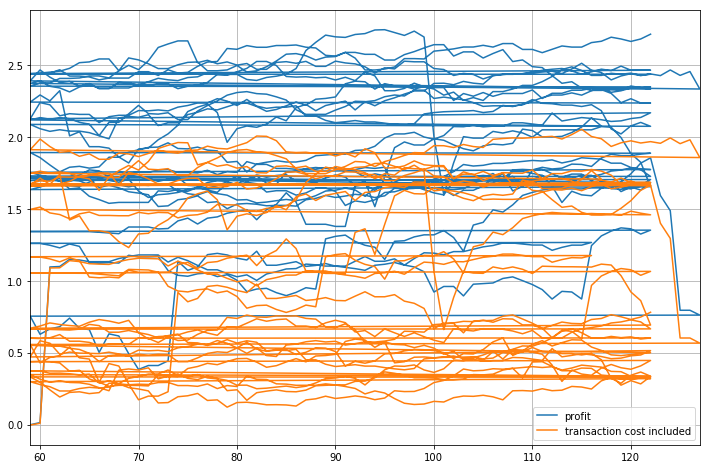

In [425]:
turnover_top = turnover_ratio(exp_tops)
turnover_bottom = turnover_ratio(exp_bottoms)

ts1, profit1 = join_ts_profit(ts_plot, profit)

plt.figure()
plt.plot(ts1, np.cumsum(profit1))
plt.plot(ts1, np.cumsum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3))
plt.legend(['profit', 'transaction cost included'], loc='best')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()

avg = np.mean(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * 252
std = np.std(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * np.sqrt(252)
sharpe = avg / std

total_positive = np.sum(profit[np.greater(profit, 0.0)])
total_negative = np.sum(profit[np.less_equal(profit, 0.0)])


print('T: {}'.format(T))
print('d: {}'.format(d))
print('a: {}, b: {}'.format(a, b))
print('Avg (year): {:.5f}'.format(avg))
print('Stddev (year): {:.5f}'.format(std))
print('Sharpe ratio (year): {:.5f}'.format(sharpe))
print('Profit:')
print('  positive only: {:.5f}'.format(total_positive))
print('  negative only: {:.5f}'.format(total_negative))
print('  total: {:.5f}'.format(total_positive + total_negative))
print('  positive to negative ratio: {:.5f}'.format(-total_positive / total_negative))
print('Average accuracy: {:.5f}'.format(np.count_nonzero(np.greater(profit, 0.0)) / len(profit)))
print('Average turnovers (range [0, 2]):')
print('  top: {:.5f}'.format(np.mean(turnover_top)))
print('  bottom: {:.5f}'.format(np.mean(turnover_bottom)))
print('  total: {:.5f}'.format(np.mean(np.hstack([turnover_bottom, turnover_top]))))
print('Total turnovers:')
print('  top: {:.5f}'.format(np.sum(turnover_top)))
print('  bottom: {:.5f}'.format(np.sum(turnover_bottom)))
print('  total: {:.5f}'.format(np.sum(np.hstack([turnover_bottom, turnover_top]))))
print('Actual profit, if transaction cost were 0.1%: {:.5f}'.format(np.sum(profit) - np.sum(np.hstack([turnover_bottom, turnover_top])) * 1e-3))

## S&P Full (cont.)

In [ ]:
spfull = np.load('data/sp_stock_prices.npy')
spstocks = np.load('data/sp_stocks.npy')
spdates = np.load('data/sp_price_dates.npy')
spchangedates = np.load('data/sp_change_dates.npy')
spchangelist = np.load('data/sp_change_list.npy')

days, N = spfull.shape
P = N * (N - 1) // 2
spfull_log = np.log(spfull)

T = 60

profits = np.empty([0])
for i in log_progress(range(len(split_points))):
    start = split_points[i]
    stop = split_points[i + 1] + 1 if i < len(split_points) - 1 else len(spfull_log)
    stocks = spchangesets[i]
    stocks_i, = np.where(np.vectorize(lambda s: s in stocks)(spstocks))
    log_prices = calculate_pairwise_diffs(spfull_log[start - T:stop, stocks_i])
    ts, codes, weights = stat_arb(log_prices[:-1], T=T, d=0)
    for t, cs, ws in log_progress(list(partition_as(ts, codes, weights))):
        pairs = decode_pairs(cs, N=N)
        prefs, cons = calculate_preference_flow(pairs, ws, return_consistency=True)
        m = np.max(np.abs(list(prefs.values())))
        tops = np.array([k for k, v in prefs.items() if v >= m])
        bottoms = np.array([k for k, v in prefs.items() if v <= -m])
        profits = np.hstack([profits, 
                             trade_singles(log_prices, t, tops, inv=False),
                             trade_singles(log_prices, t, bottoms, inv=True)])
    
    avg = np.mean(profits) * 255
    std = np.std(profits) * np.sqrt(255)
    sharpe = avg / std
    print('step {}: profit {}, avg {}, std {}, sharpe {}'.format(i, np.sum(profits), avg, std, sharpe))
    plt.figure()
    plt.plot(np.cumsum(profits))
    plt.grid()

C:\Users\Helena\ipynb\utility\functions.py:394: RuntimeWarning: invalid value encountered in greater_equal
  ts, codes = np.where(np.abs(trading_signal) >= d)


step 0: profit 0.3362392221216073, avg 1.4532373159493195, std 0.23975922211053857, sharpe 6.061236365203584


step 1: profit 0.45933992236968546, avg 0.9079975209633318, std 0.26597994944383196, sharpe 3.4137818390520343


step 2: profit 0.564112725294784, avg 0.7414883760318036, std 0.3239682644050146, sharpe 2.2887685539001406


step 3: profit 0.7893843926026136, avg 0.7924922051719153, std 0.3973844942016575, sharpe 1.9942705785841652


step 5: profit 0.9633066886049471, avg 0.6314735362320347, std 0.4014661208894682, sharpe 1.5729186184701553


step 6: profit 0.9644900993529748, avg 0.5417290205616929, std 0.4022615897271324, sharpe 1.3467082972778137


step 7: profit 1.1686426443209368, avg 0.5741885824698245, std 0.4057548218261905, sharpe 1.415112160307942


step 10: profit 1.4493408874909346, avg 0.5176217455324766, std 0.3948774147605734, sharpe 1.3108416085187524


step 11: profit 1.393708303383712, avg 0.4562203047019853, std 0.38434566968984485, sharpe 1.1870051900679435


step 12: profit 1.4627580152613722, avg 0.4419470306773103, std 0.3774184274611792, sharpe 1.1709736423051798


step 13: profit 1.4649882545207937, avg 0.41097030242332494, std 0.3734907698222295, sharpe 1.1003492873972083


step 14: profit 1.7702877030248076, avg 0.46347367995002664, std 0.3720058008099771, sharpe 1.2458775614275217


step 15: profit 1.7864898004580947, avg 0.43845514833187116, std 0.36926455775773415, sharpe 1.1873740360956366


step 103: profit 0.35131851498113065, avg 0.013221107042530742, std 0.5025822930698237, sharpe 0.026306352660725226


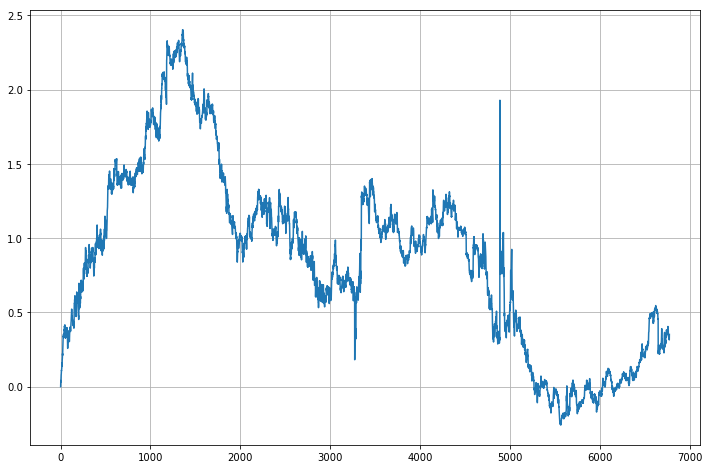

In [12]:
avg = np.mean(profits) * 255
std = np.std(profits) * np.sqrt(255)
sharpe = avg / std
print('step {}: profit {}, avg {}, std {}, sharpe {}'.format(i, np.sum(profits), avg, std, sharpe))
plt.figure()
plt.plot(np.cumsum(profits))
plt.grid()

step 1: profit 1.554391623882428, avg 6.718133289661341, std 2.3213253374209235, sharpe 2.894093809842885


step 2: profit 1.7339877243336879, avg 3.427650152752639, std 2.095232359026227, sharpe 1.6359284152835734


step 3: profit 2.775259611152395, avg 3.647892787854952, std 2.0024310880922243, sharpe 1.8217319984431566


step 4: profit 2.9312157024611216, avg 2.9427559217621497, std 1.9012089951057751, sharpe 1.5478339989646575


step 5: profit 3.913199033940959, avg 3.0798325730090883, std 1.7244380915213045, sharpe 1.7859919634992816


step 6: profit 4.136983718041545, avg 2.7119044938318613, std 1.59452774179607, sharpe 1.7007571726392057


step 7: profit 4.3861757566523325, avg 2.4636009205866625, std 1.5075054397345675, sharpe 1.634223569382568


step 8: profit 4.758083810179382, avg 2.33778684315172, std 1.4311923371528001, sharpe 1.633453996688167


step 9: profit 4.763671564239525, avg 2.080027823426505, std 1.3627197705003316, sharpe 1.5263797212414472


step 10: profit 4.29816458382682, avg 1.6888011847085347, std 1.5343860894576102, sharpe 1.1006364019537669


step 11: profit 4.6009049809164315, avg 1.643180350327297, std 1.4833680414299502, sharpe 1.107736114324864


step 12: profit 5.15376905586327, avg 1.6870489207254609, std 1.4262848457338422, sharpe 1.1828274876309524


step 13: profit 5.264527229607965, avg 1.590585833590084, std 1.3851049086884641, sharpe 1.1483504416255277


step 14: profit 5.430701895560297, avg 1.5234642281274762, std 1.341917332575139, sharpe 1.1352891800003422


step 15: profit 5.391859190920634, avg 1.4116263795531434, std 1.3036741992406313, sharpe 1.0828061032237906


step 16: profit 5.605197185243621, avg 1.375673996378367, std 1.268398949311205, sharpe 1.0845751623536248


step 17: profit 6.053969513673056, avg 1.39833534962557, std 1.2388416337380246, sharpe 1.128744232954374


step 18: profit 6.141205830067429, avg 1.3396129056177883, std 1.2109466912547, sharpe 1.1062525834475614


step 19: profit 6.763529856171482, avg 1.3976500107971863, std 1.1849491095584415, sharpe 1.1795021402379091


step 20: profit 7.025302305227136, avg 1.3791009144210313, std 1.1619820274713872, sharpe 1.1868521903235638


step 21: profit 7.252361473219673, avg 1.3558300408145283, std 1.1397338882482768, sharpe 1.1896022876869812


C:\Users\Helena\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


step 22: profit 7.531688770370527, avg 1.3440032445377779, std 1.1181038613143315, sharpe 1.2020379242388999


step 23: profit 8.299091439540684, avg 1.4165115910862611, std 1.1067486935171345, sharpe 1.2798854874494876


C:\Users\Helena\ipynb\utility\functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return (mean, var) if not return_stds else (mean, np.sqrt(var))
C:\Users\Helena\ipynb\utility\functions.py:394: RuntimeWarning: invalid value encountered in greater_equal
  ts, codes = np.where(np.abs(trading_signal) >= d)


step 24: profit 8.756460024939589, avg 1.4322625441690795, std 1.0951694813020219, sharpe 1.3077999055144374


step 25: profit 8.428585181022145, avg 1.3193917870844978, std 1.0813693565202704, sharpe 1.2201120543402098


step 26: profit 7.938045912941295, avg 1.1949242667060391, std 1.0650198017040342, sharpe 1.121973755599809


step 27: profit 7.7764852236616875, avg 1.1273472041124106, std 1.0516499277822555, sharpe 1.0719795383714688


step 28: profit 7.792643866971568, avg 1.0894321195601697, std 1.0438509280141164, sharpe 1.0436663802491124


step 29: profit 8.196446635535834, avg 1.1064552101967378, std 1.0408885511944261, sharpe 1.0629910463777064


step 30: profit 8.42134358970125, avg 1.0989982678473995, std 1.0277391908463092, sharpe 1.0693357591456747


step 31: profit 8.670534093077276, avg 1.0950897442965357, std 1.0166434489141154, sharpe 1.0771620527001964


step 32: profit 8.88871847311902, avg 1.0876310991580376, std 1.004535740901979, sharpe 1.082720161038219


step 33: profit 8.982633946085771, avg 1.0658779228719737, std 0.9960605635828129, sharpe 1.0700934881289035


step 34: profit 8.99245323256397, avg 1.0357161582221375, std 0.9926857230100774, sharpe 1.0433474907663431


step 35: profit 9.061687259669569, avg 1.0139228833768055, std 0.9924413968690134, sharpe 1.021645093176849


step 36: profit 9.210245382355009, avg 1.0019678210326481, std 0.9852688568943158, sharpe 1.0169486369344602


step 37: profit 9.629066493684515, avg 1.0192660672019724, std 1.0332148964913237, sharpe 0.9864995855782569


step 38: profit 9.6215849962606, avg 0.9917155109322768, std 1.0247848404166833, sharpe 0.9677304657717611


step 39: profit 9.495008247842115, avg 0.9536144557698856, std 1.0345591510128151, sharpe 0.9217592390307638


step 40: profit 10.108796203186516, avg 0.9899166788834722, std 1.0305769246974872, sharpe 0.9605461321327855


step 41: profit 10.50905916371925, avg 1.0040502385719028, std 1.0258799845601814, sharpe 0.9787209553584989


step 42: profit 10.438031962292895, avg 0.9735545539080791, std 1.0170561291574298, sharpe 0.9572279503537439


step 43: profit 10.488616204276115, avg 0.9555545309361948, std 1.0340431203404306, sharpe 0.9240954387101424


step 44: profit 11.396820784808195, avg 1.0147309008820147, std 1.0312754222772158, sharpe 0.9839572232229987


step 45: profit 11.341909479456048, avg 0.9874315183548283, std 1.026989472099449, sharpe 0.9614816365510025


step 46: profit 10.84130201562644, avg 0.9218179439762394, std 1.0227984345674332, sharpe 0.9012703899631006


step 47: profit 7.790547958194199, avg 0.6483647941708618, std 1.2139071586969377, sharpe 0.5341139884757296


step 48: profit 5.860742731367424, avg 0.4783896915808876, std 1.2500394769524892, sharpe 0.3826996670114523


step 49: profit 5.01222737644383, avg 0.4001621731349958, std 1.24684121683177, sharpe 0.3209407643355021


step 50: profit 5.372514400589116, avg 0.4203716391992098, std 1.2756565794191923, sharpe 0.3295335484340193


step 51: profit 4.843950174458078, avg 0.37160267583839046, std 1.278286458900171, sharpe 0.2907037567761728


step 52: profit 4.501278515259759, avg 0.33869165576607807, std 1.2726623626772338, sharpe 0.2661284451388898


step 53: profit 4.885521674923565, avg 0.36068558978156023, std 1.2640949057021045, sharpe 0.285331099868034


step 54: profit 5.134705925206577, avg 0.372080139507723, std 1.2542651564664684, sharpe 0.2966518981966715


step 55: profit 5.255187879288146, avg 0.373904271545334, std 1.2446767470323452, sharpe 0.30040271294279863


step 56: profit 5.350438332738831, avg 0.3739001849406418, std 1.2355102146501038, sharpe 0.3026281616348516


step 57: profit 5.542111755896555, avg 0.3805165583612336, std 1.225805025185656, sharpe 0.3104217641003731


step 58: profit 5.471377967697022, avg 0.36919856622459396, std 1.2169227440251644, sharpe 0.30338702110489885


step 59: profit 5.190379629707633, avg 0.3443149858416874, std 1.2092164750623644, sharpe 0.2847422218787828


step 60: profit 5.191230190764648, avg 0.3386451007022218, std 1.2004635493886817, sharpe 0.28209527967314946


step 61: profit 5.303609107898033, avg 0.34031714205183655, std 1.1933387512987097, sharpe 0.28518066783758567


step 62: profit 5.31792016436491, avg 0.3357439073812954, std 1.1843652298845309, sharpe 0.2834800439168825


step 63: profit 2.684644622667826, avg 0.16680905915699212, std 1.2399953272643478, sharpe 0.13452394173533125


step 64: profit 2.7049145446381546, avg 0.1654481191851114, std 1.2342320766204837, sharpe 0.13404944039222644


step 65: profit 2.8292793288130564, avg 0.17039825905699796, std 1.2255340033254016, sharpe 0.13904000916713374


step 66: profit 2.946132248388375, avg 0.17475313406351145, std 1.2168489760757697, sharpe 0.14361119374655254


step 67: profit 2.965720091288029, avg 0.17329482659909426, std 1.2081892538682748, sharpe 0.1434335109704494


step 68: profit 3.3093246359086876, avg 0.19053460875066952, std 1.199563246736946, sharpe 0.15883665098023142


step 69: profit 3.4097123588446347, avg 0.19347500033497594, std 1.1917643907323863, sharpe 0.16234333047665397


step 70: profit 3.1933661082773197, avg 0.1784198855413489, std 1.1850916937570037, sharpe 0.15055365460854617


step 71: profit 2.714753393884684, avg 0.14954895559312906, std 1.186352297720338, sharpe 0.12605779571590853


step 72: profit 1.7179444977908576, avg 0.09334665393920065, std 1.261268508416053, sharpe 0.07401013607834289


step 73: profit 1.9878547903190693, avg 0.10651459792632122, std 1.2561595602325335, sharpe 0.08479384410894727


step 74: profit 1.7888358554161279, avg 0.0945591092726187, std 1.2782026982805486, sharpe 0.07397817998649242


step 75: profit 2.6801467555610525, avg 0.13979084120844107, std 1.3365609868222426, sharpe 0.10458994582866177


step 76: profit 2.015031581290682, avg 0.10372084239586675, std 1.337893903560962, sharpe 0.07752546156298457


step 77: profit 2.6383239580318882, avg 0.1340451502885299, std 1.3346801691836734, sharpe 0.10043241323538624


step 78: profit 4.1714829281120585, avg 0.20923055599303206, std 1.344786507954933, sharpe 0.1555864479271262


step 79: profit 4.38477427459595, avg 0.21715234803300976, std 1.3375185614518494, sharpe 0.16235464261318008


step 80: profit 4.197718328433459, avg 0.2052969263042831, std 1.3301016887816433, sharpe 0.1543467902009301


step 81: profit 4.500590459344567, avg 0.21739923605471956, std 1.3232615638678054, sharpe 0.16429044868444306


step 82: profit 4.7609950763884665, avg 0.22718071565850653, std 1.3159966870007467, sharpe 0.17263015773715062


step 83: profit 4.841024165529646, avg 0.22822354635053796, std 1.3085571630208577, sharpe 0.1744085415601368


step 84: profit 4.7280075026095885, avg 0.2202487967054156, std 1.301532165307933, sharpe 0.16922270734147116


step 85: profit 4.74592443827328, avg 0.2184890290232328, std 1.2941743882090875, sharpe 0.16882502931122262


step 86: profit 5.1134826656095855, avg 0.2326798857477595, std 1.2880544881513512, sharpe 0.180644443141305


step 87: profit 4.898193576435482, avg 0.22032798765056408, std 1.2822939200877077, sharpe 0.1718233114881289


step 88: profit 4.870354421828696, avg 0.21659232256126917, std 1.2756211144228522, sharpe 0.1697936167035501


step 89: profit 4.750629699745818, avg 0.20889990919730703, std 1.2691197460826753, sharpe 0.16460220545941967


step 90: profit 4.529658378178186, avg 0.19680744359097588, std 1.2621479918563678, sharpe 0.15593056033113153


step 91: profit 4.5111630315708915, avg 0.1938568542383851, std 1.2561113751553505, sharpe 0.154330943953445


step 92: profit 4.3796188038612565, avg 0.1863201192833868, std 1.2505825124957122, sharpe 0.1489866661509275


step 93: profit 4.576240656751169, avg 0.1924375605988701, std 1.2443389197956958, sharpe 0.15465043931155495


step 94: profit 4.4143835990046, avg 0.18366255796152275, std 1.2386174624625452, sharpe 0.14828029115331204


step 95: profit 4.423890189668645, avg 0.18212657384008793, std 1.232494599025216, sharpe 0.14777068717715472


step 96: profit 4.254426077841366, avg 0.17333098735413777, std 1.2266094923756157, sharpe 0.14130902168255835


step 97: profit 4.116999600138813, avg 0.1660080483926941, std 1.220980691066748, sharpe 0.1359628777156631


step 98: profit 4.2477730865806596, avg 0.16953860339302992, std 1.2151864165172894, sharpe 0.13951653926393093


step 99: profit 4.014646868818159, avg 0.15862022800567563, std 1.2097260654603872, sharpe 0.131120782245284


step 100: profit 3.7634973969061103, avg 0.14721457834193252, std 1.2040877585275598, sharpe 0.12226233287344147


step 101: profit 3.7458727840645487, avg 0.1450786087388305, std 1.198493323846918, sharpe 0.1210508276117533


step 102: profit 3.5455967393668675, avg 0.13597942074575894, std 1.1938075366152905, sharpe 0.11390397243704023


step 103: profit 4.065528302930648, avg 0.15441014555366628, std 1.1888698401010118, sharpe 0.12987977350030755


step 104: profit 4.149242632284041, avg 0.1561477082692489, std 1.1851309797313405, sharpe 0.1317556548092653


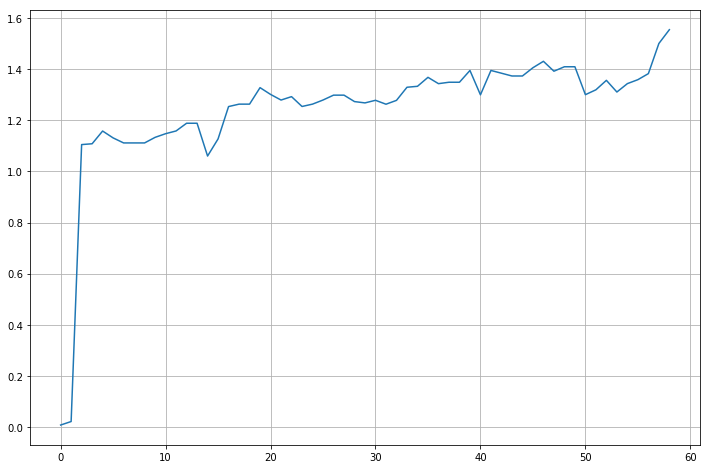

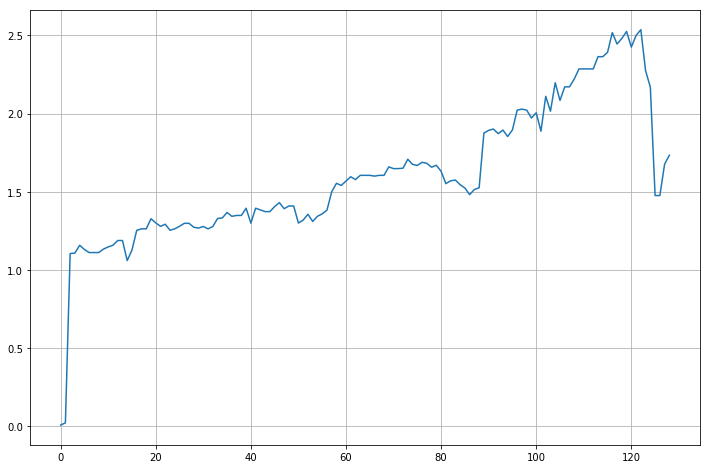

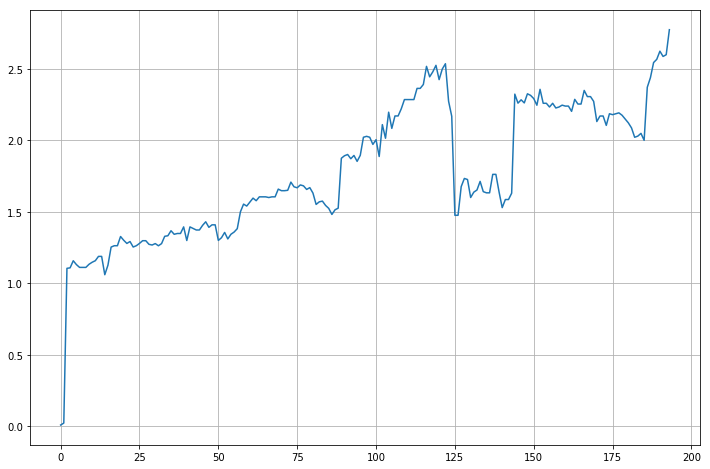

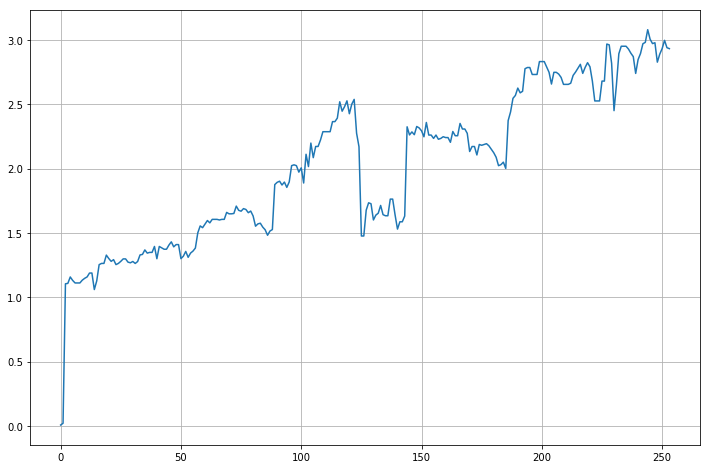

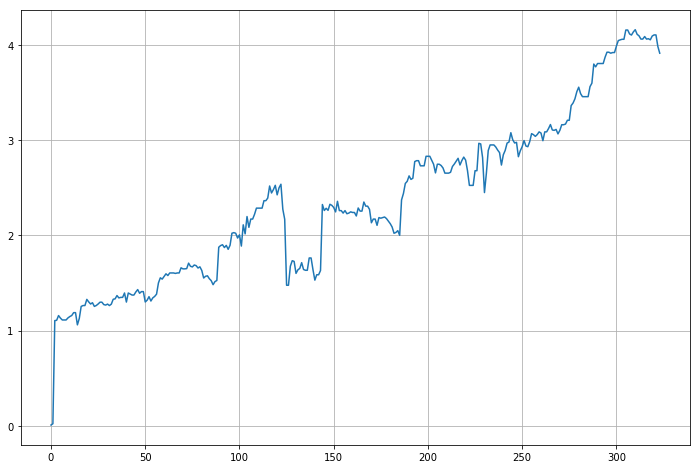

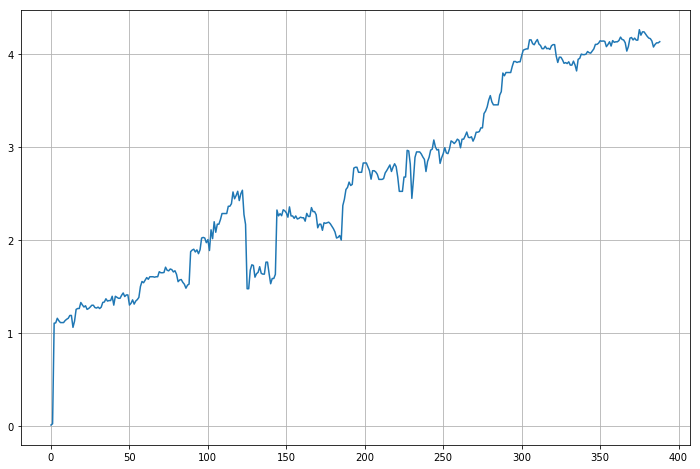

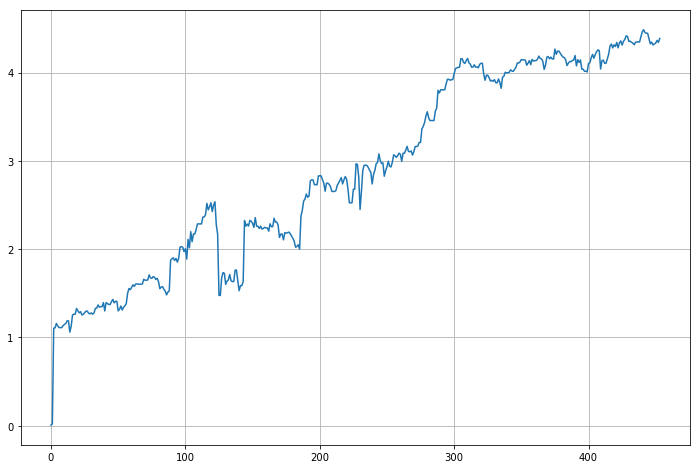

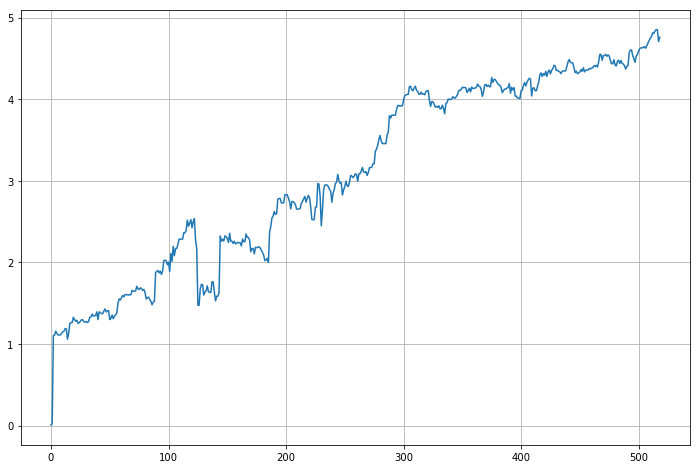

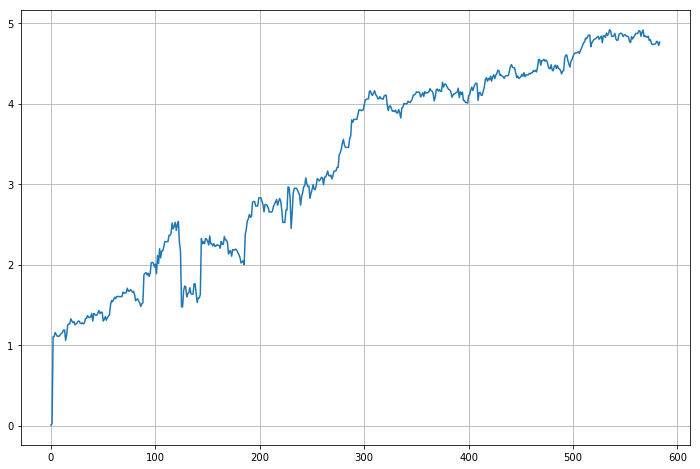

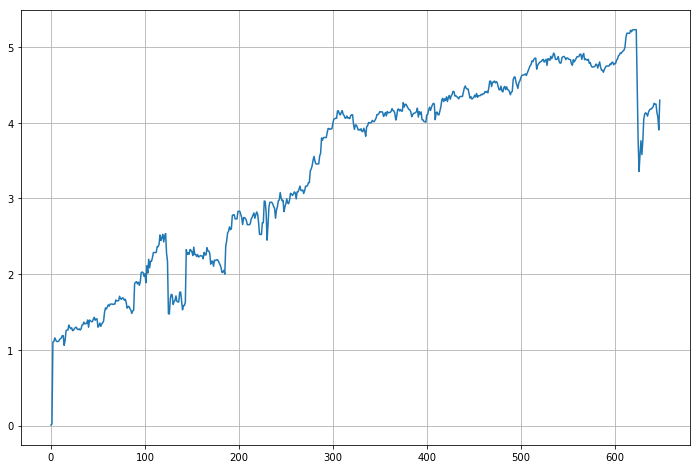

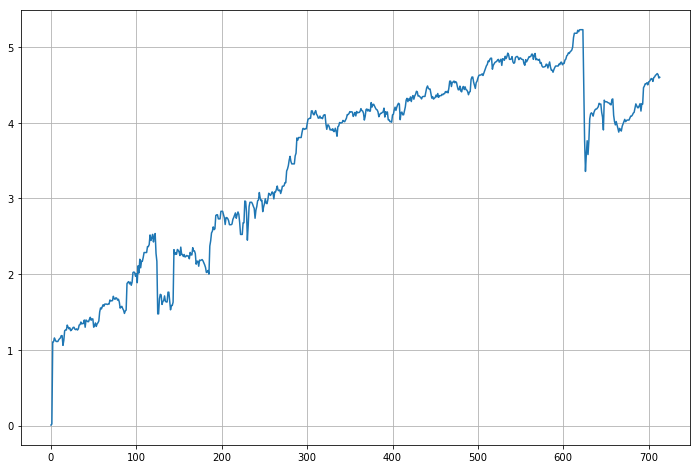

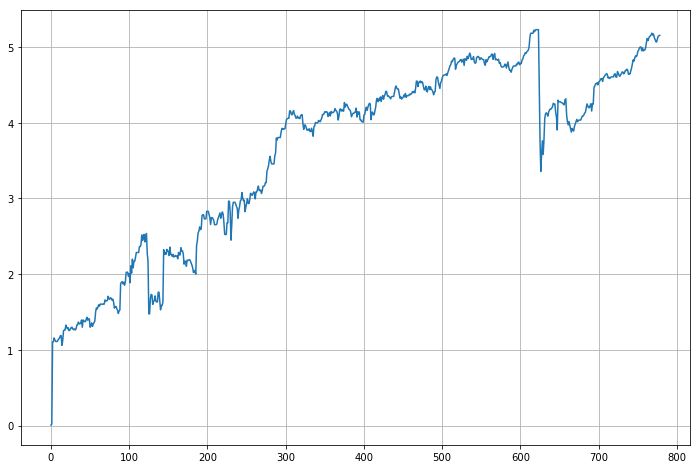

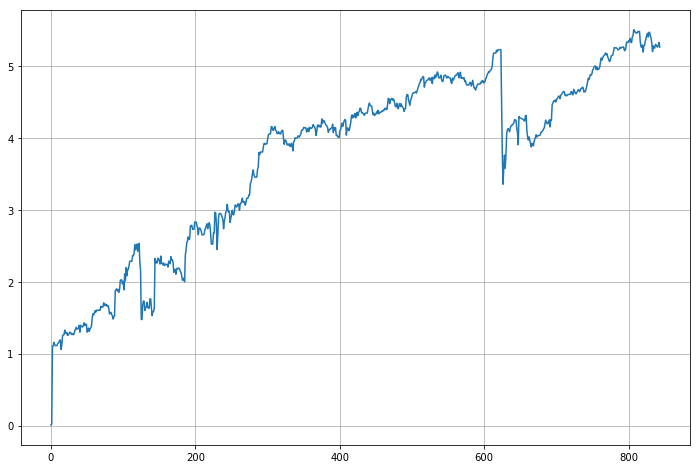

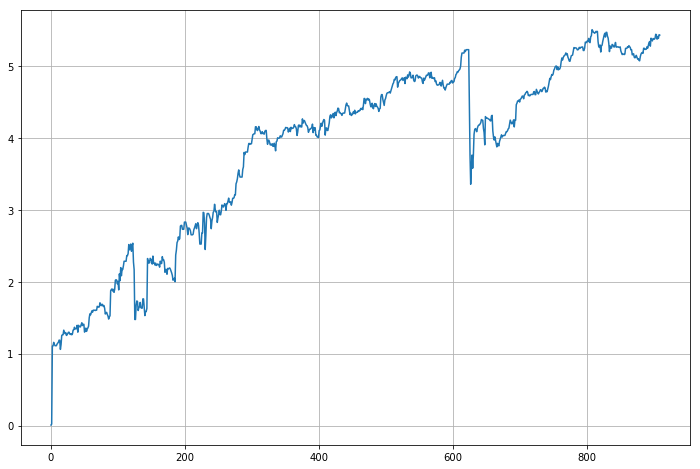

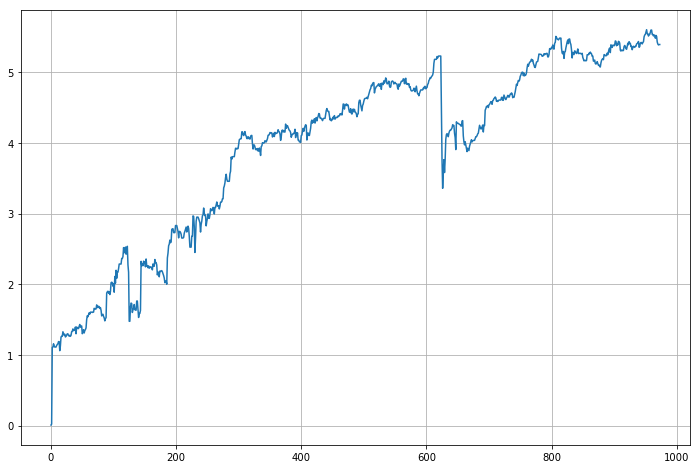

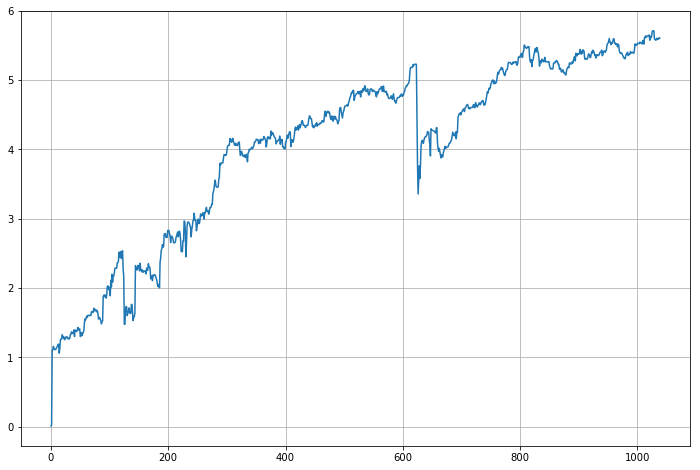

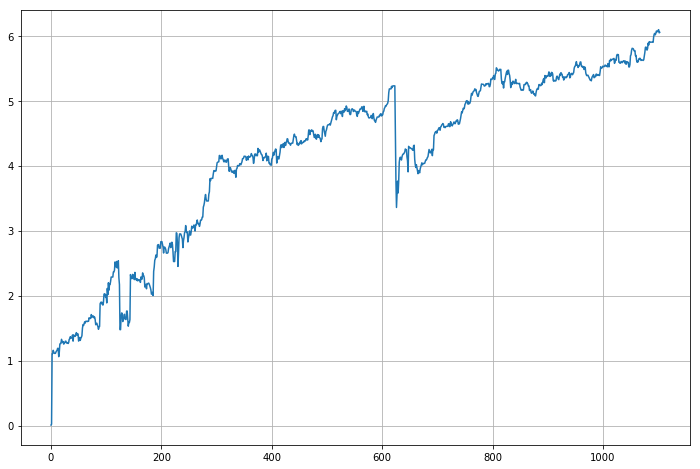

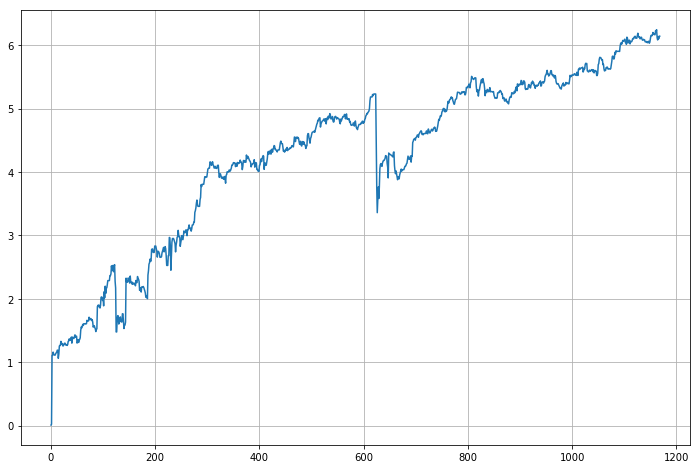

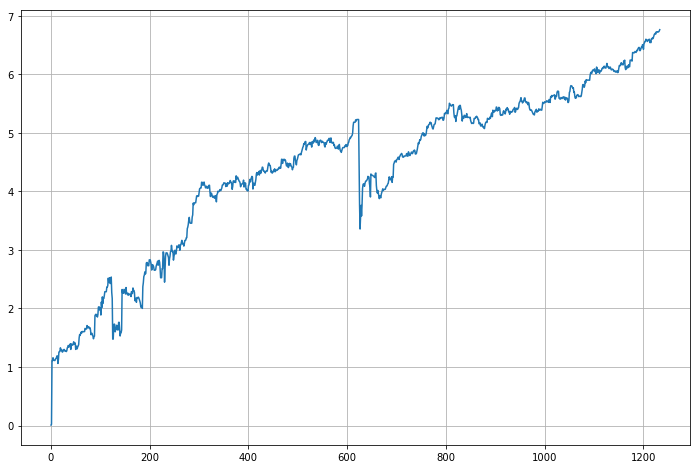

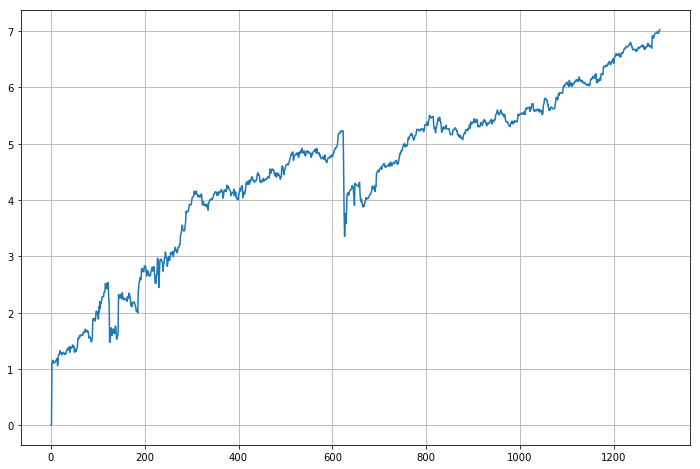

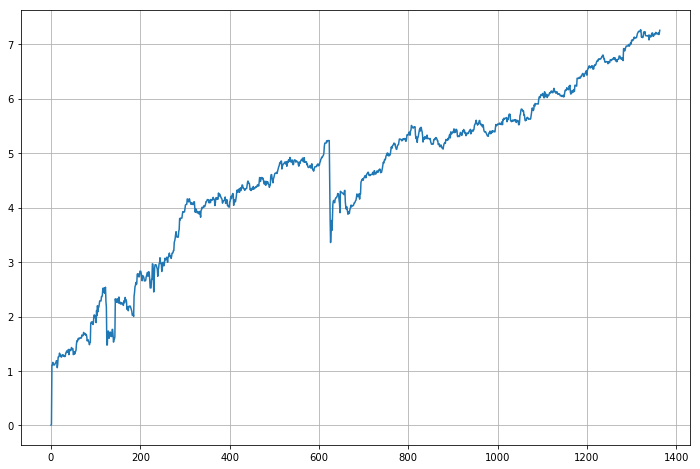

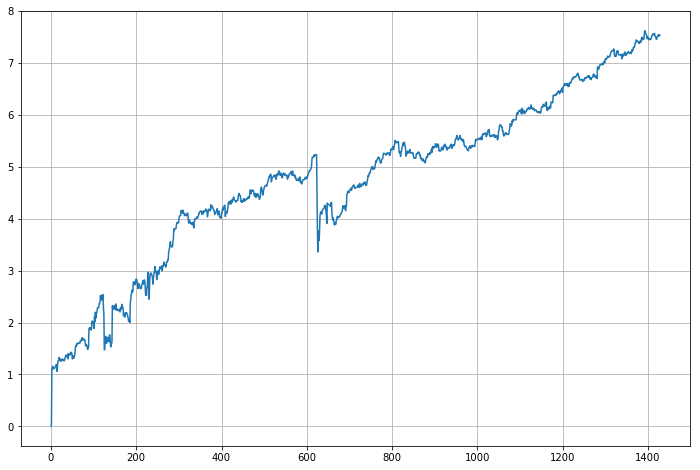

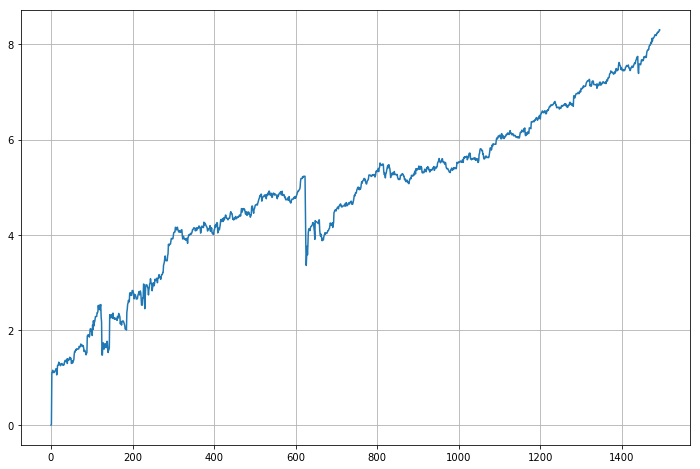

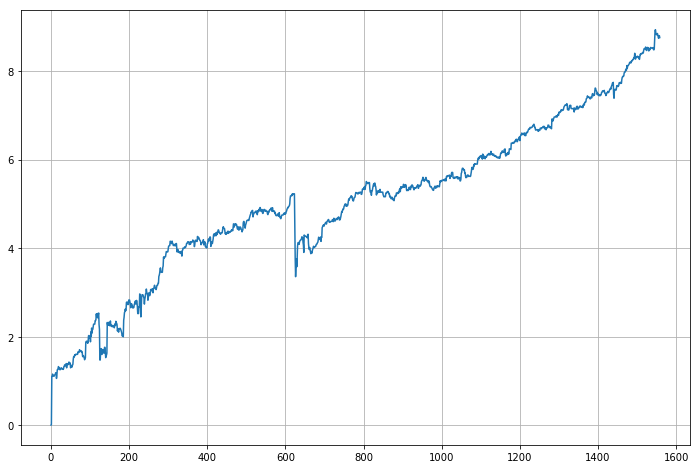

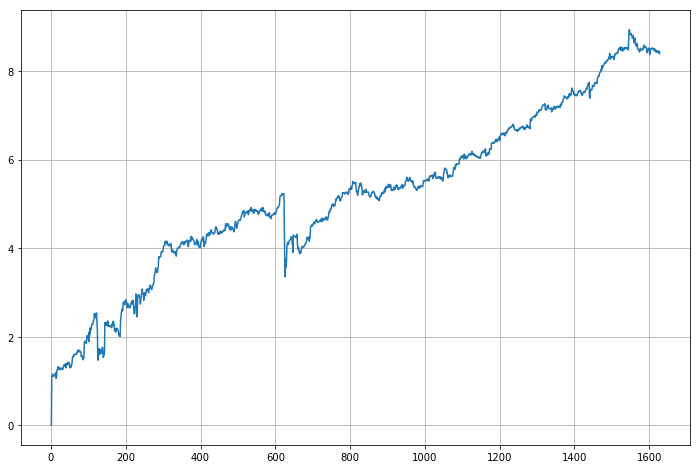

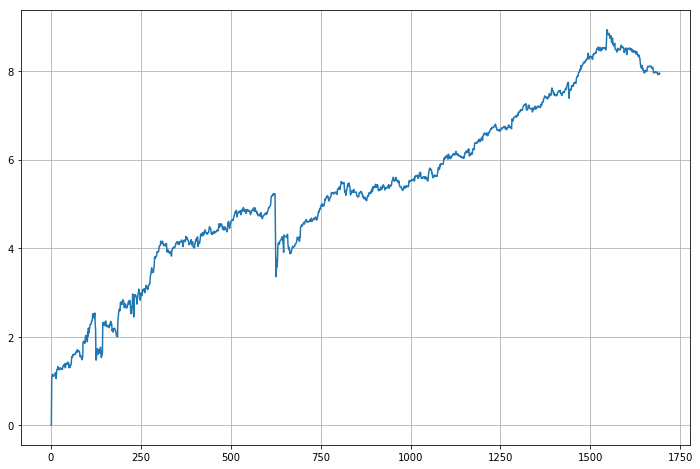

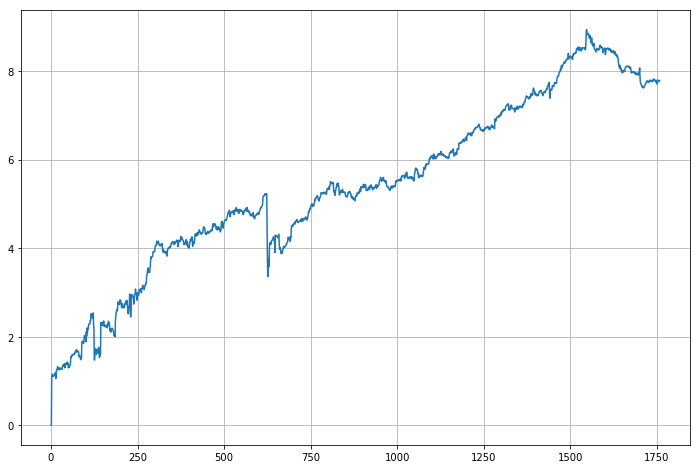

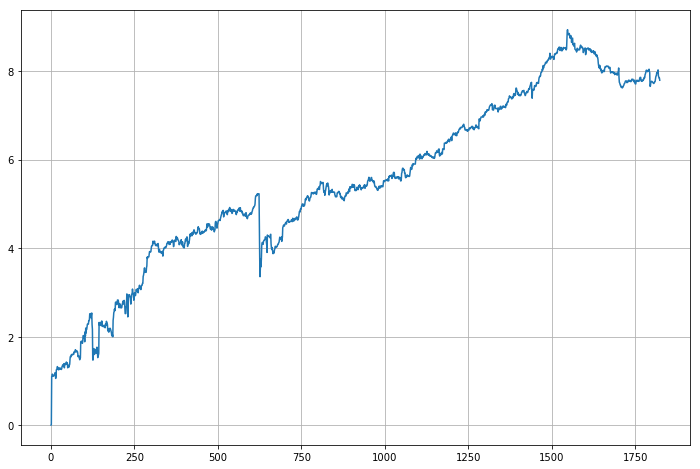

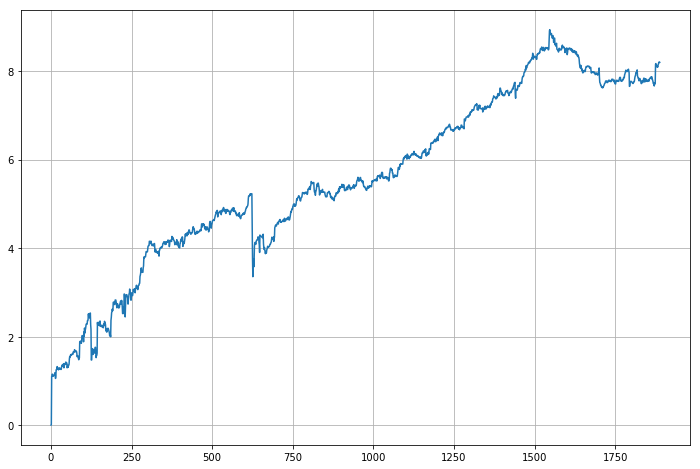

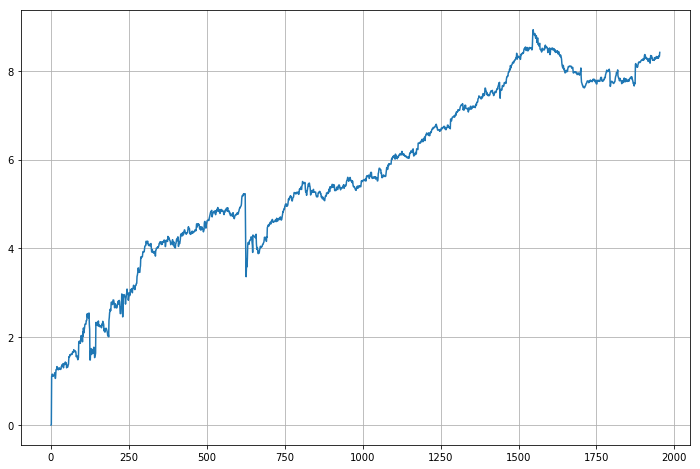

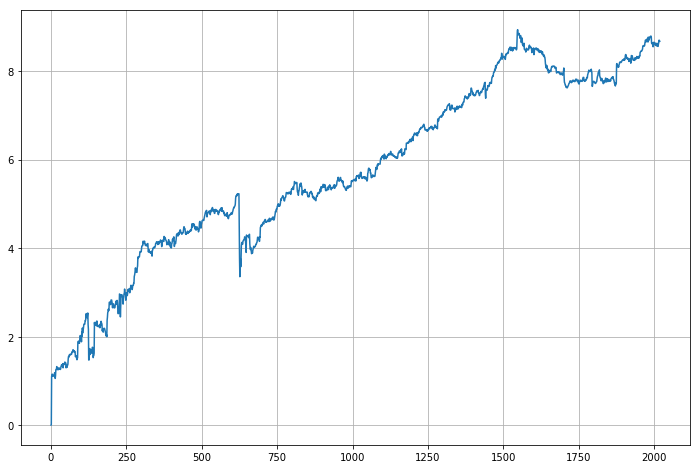

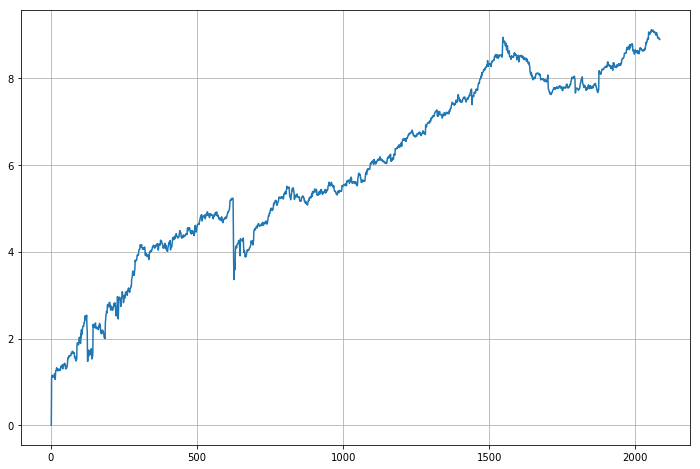

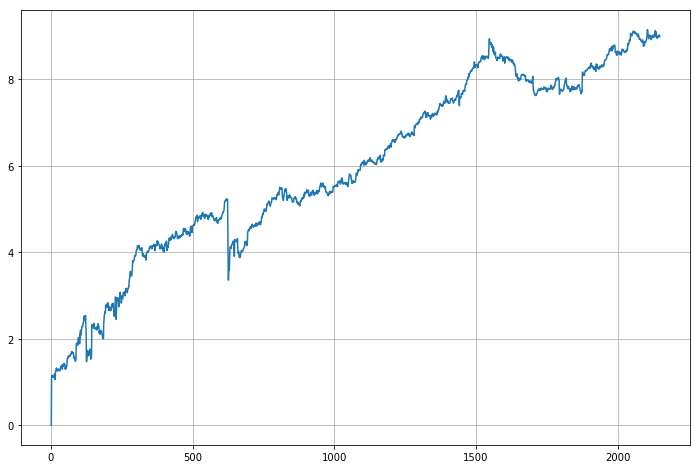

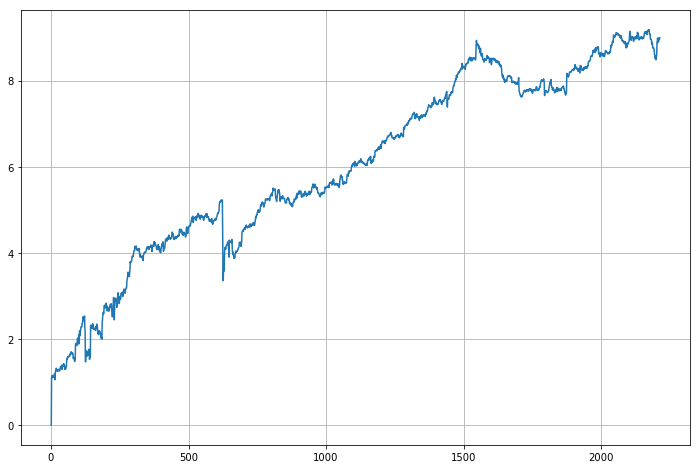

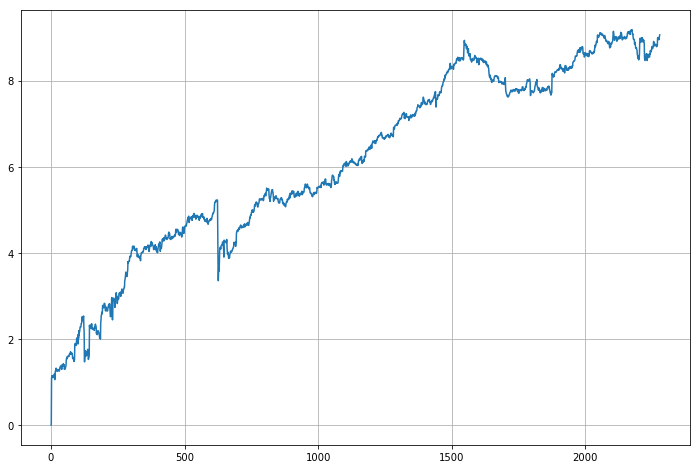

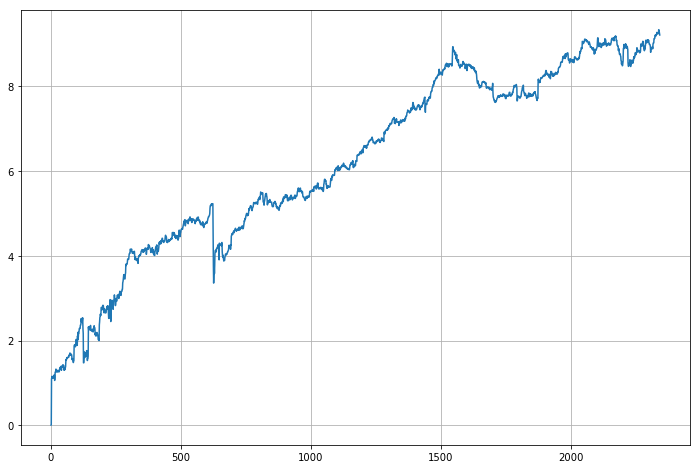

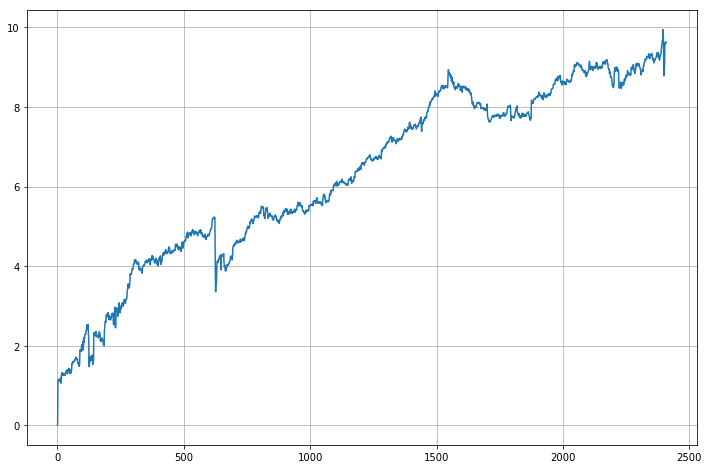

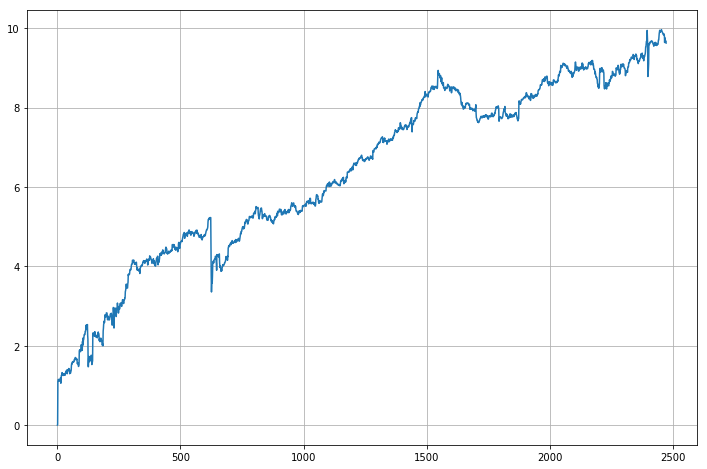

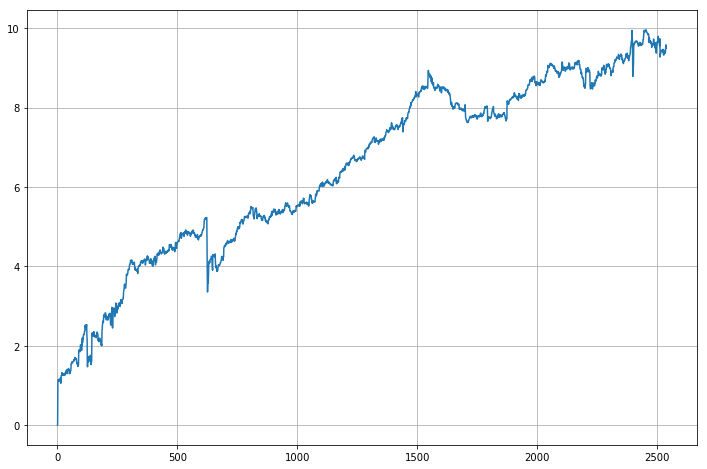

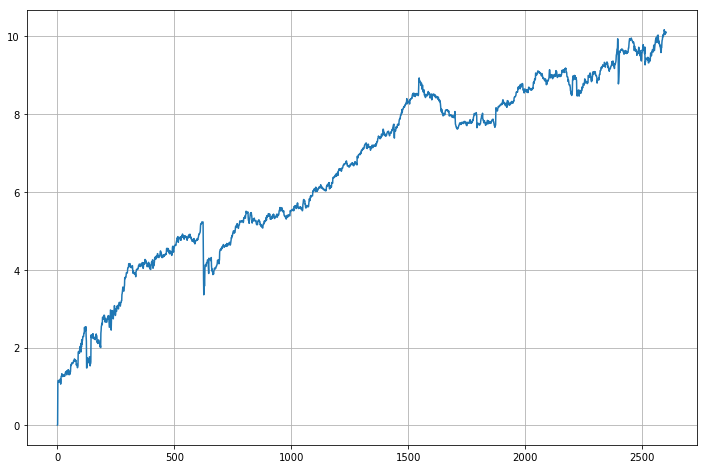

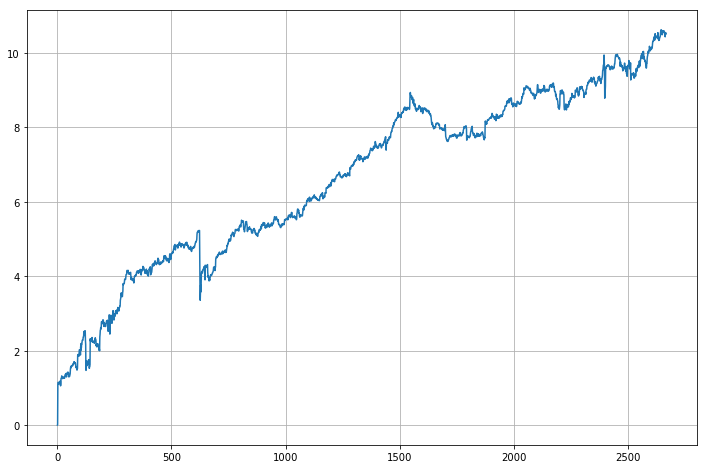

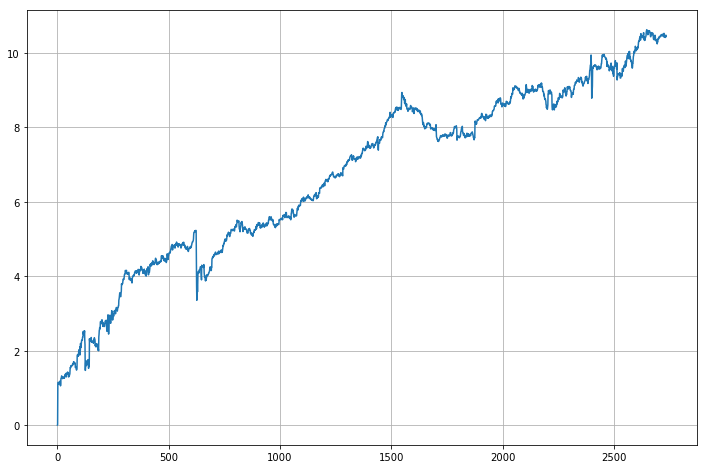

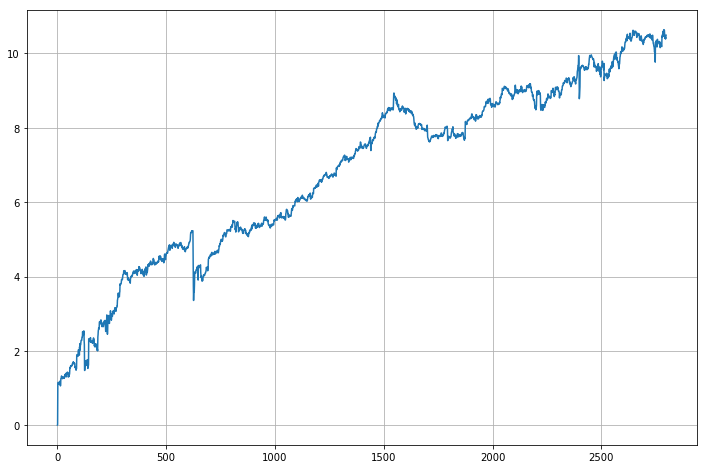

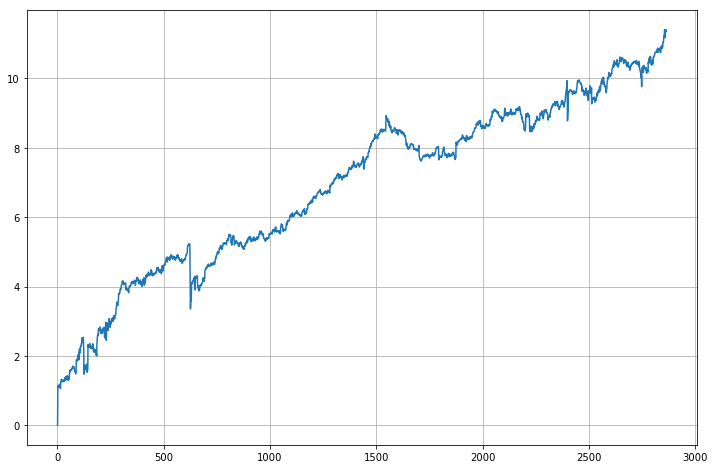

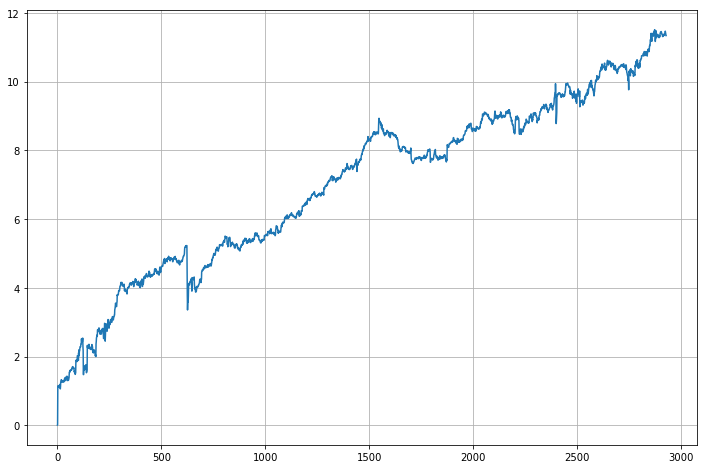

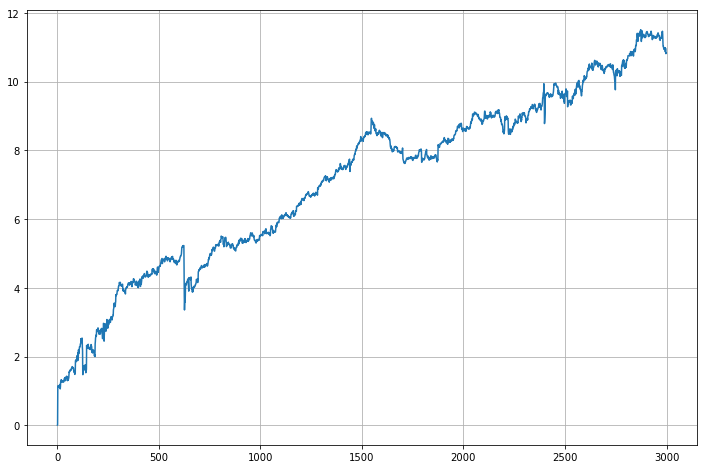

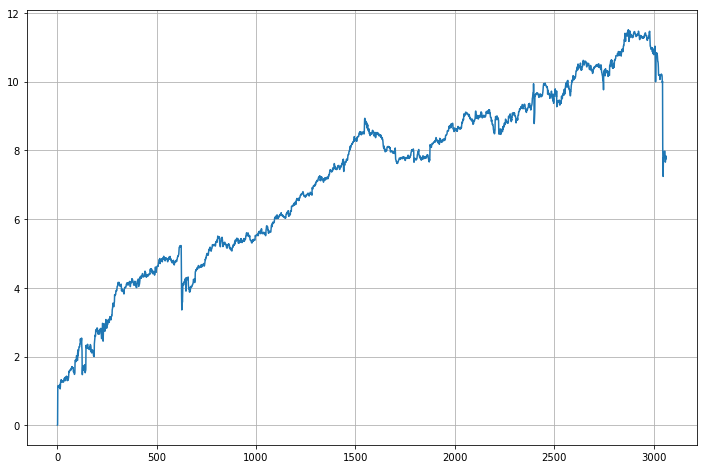

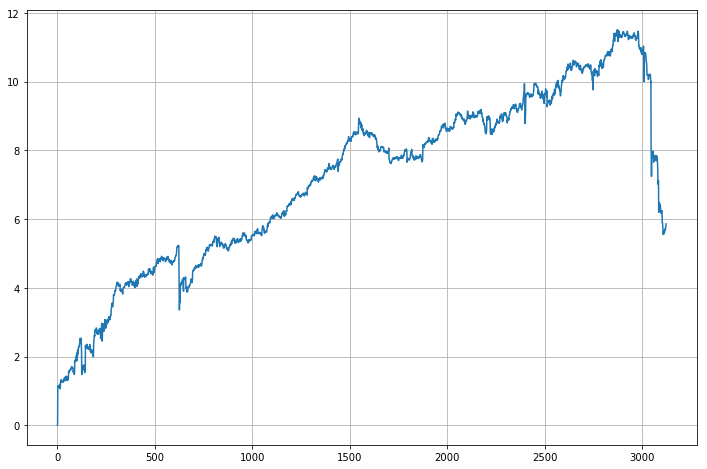

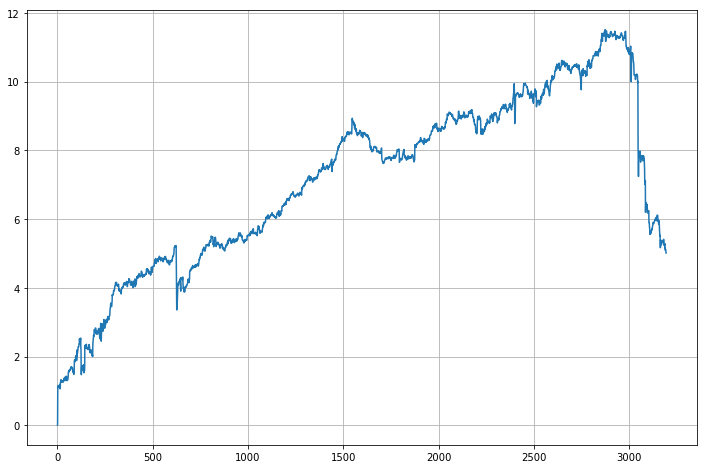

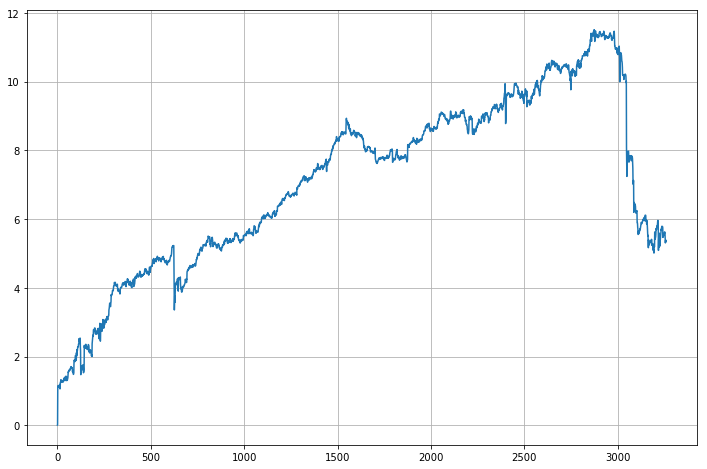

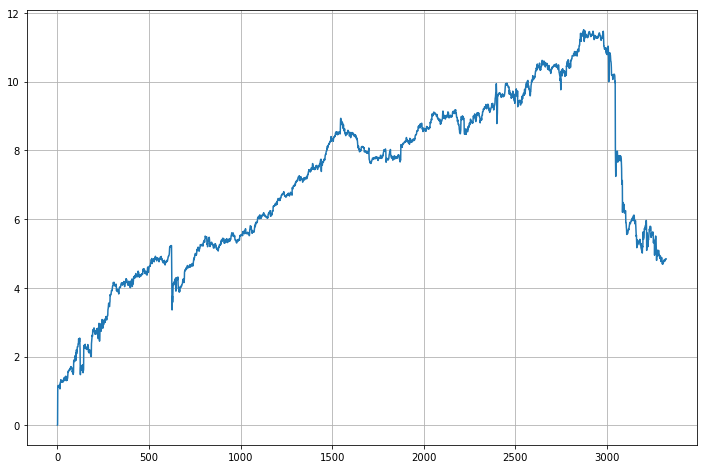

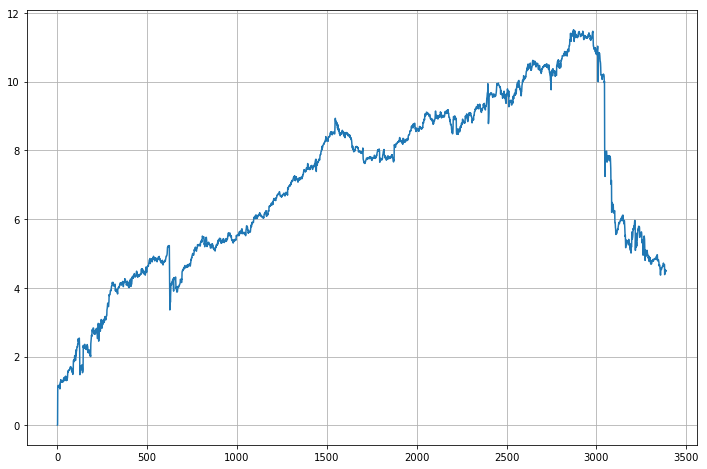

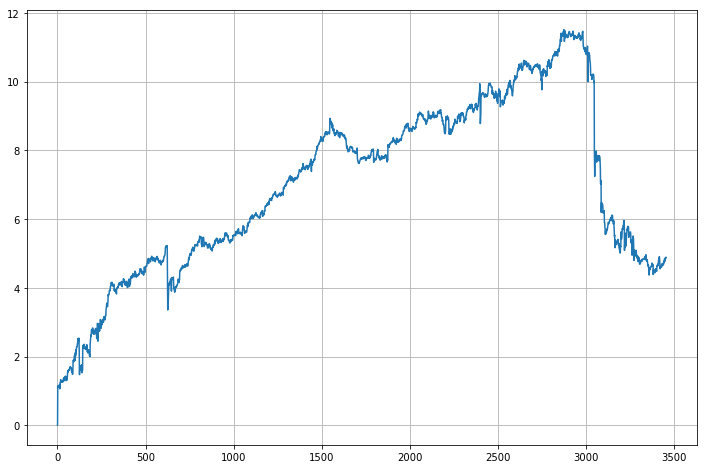

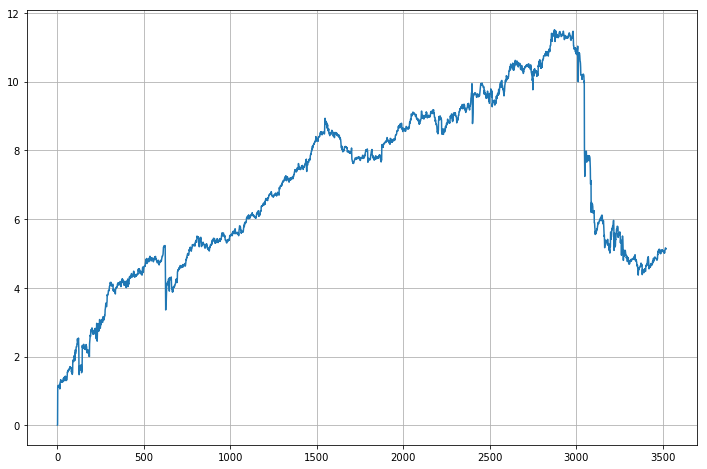

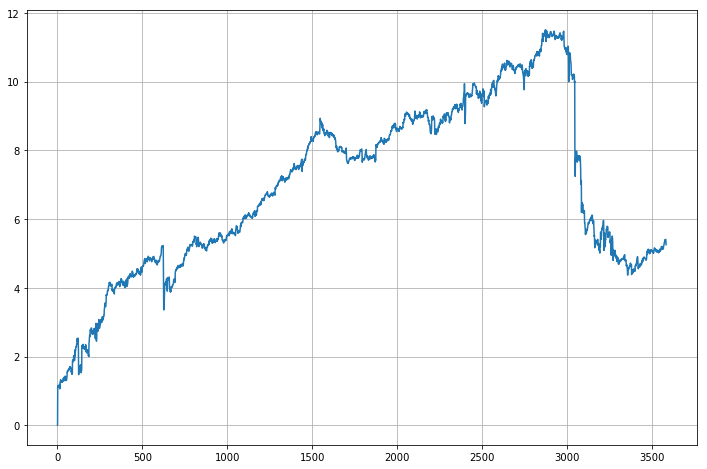

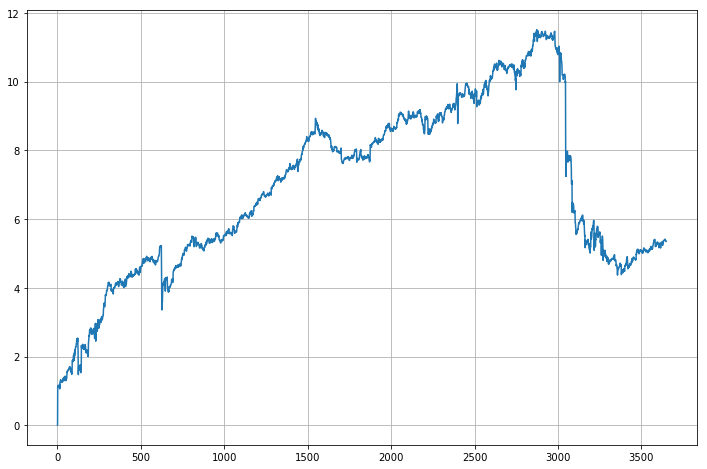

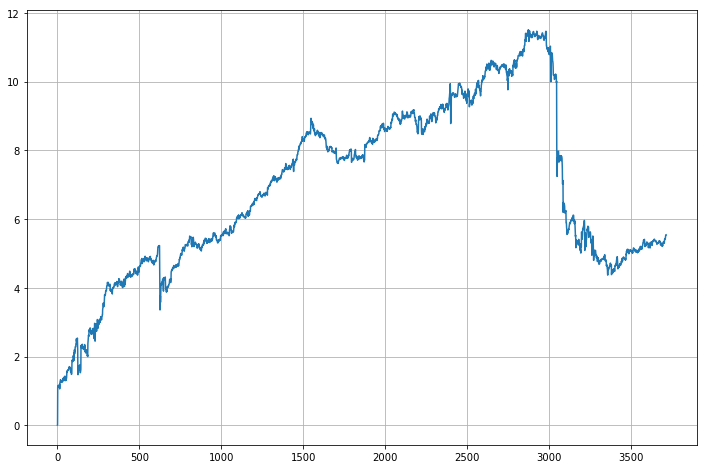

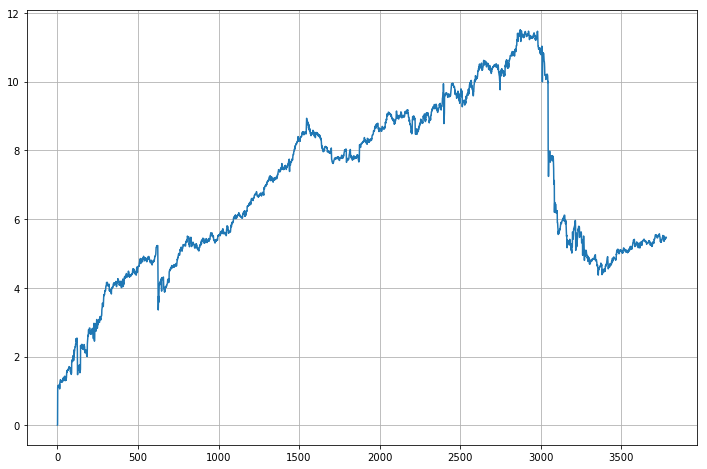

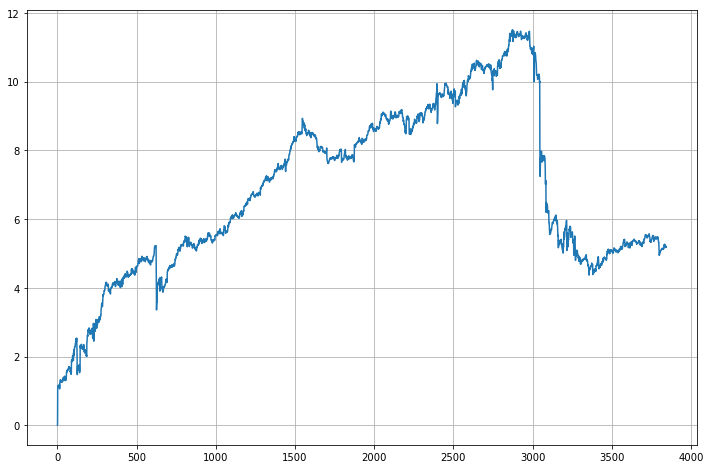

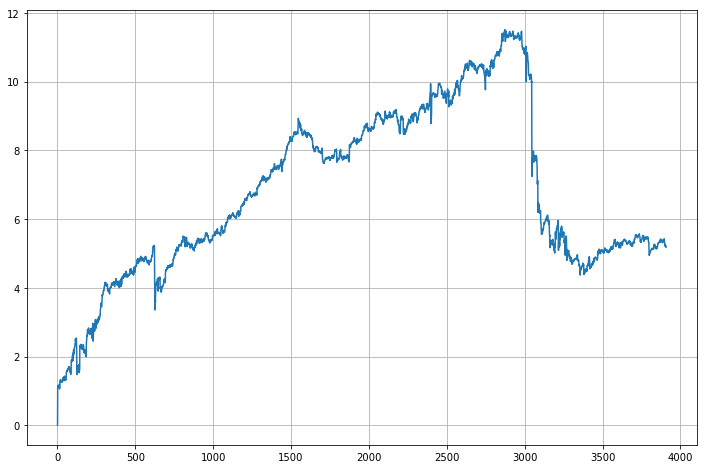

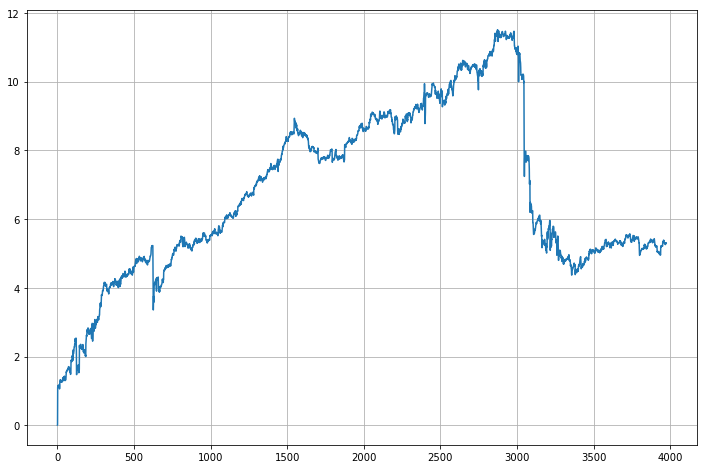

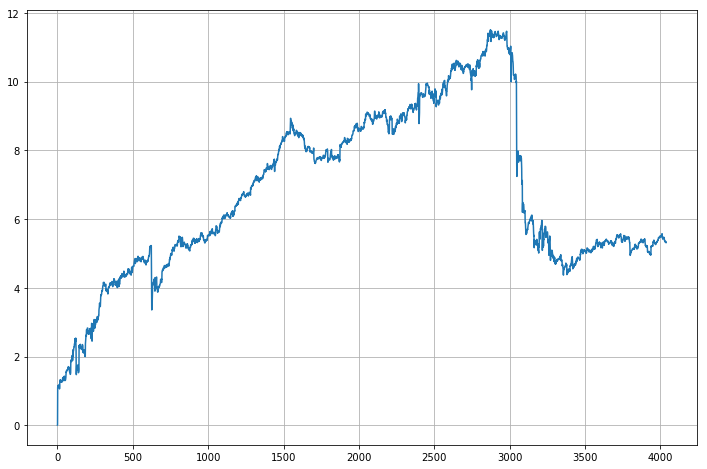

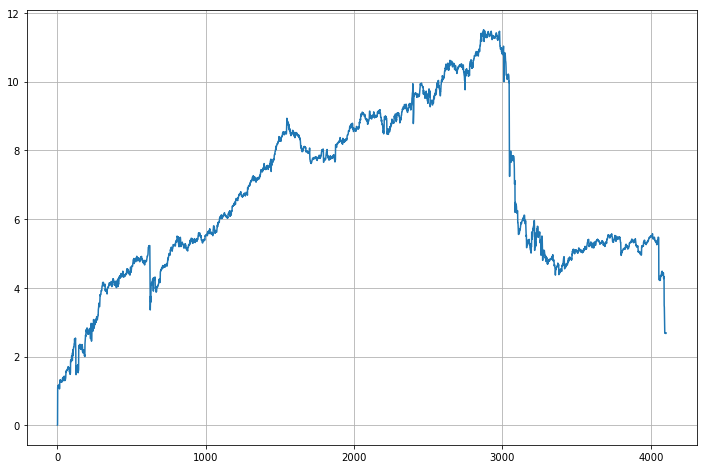

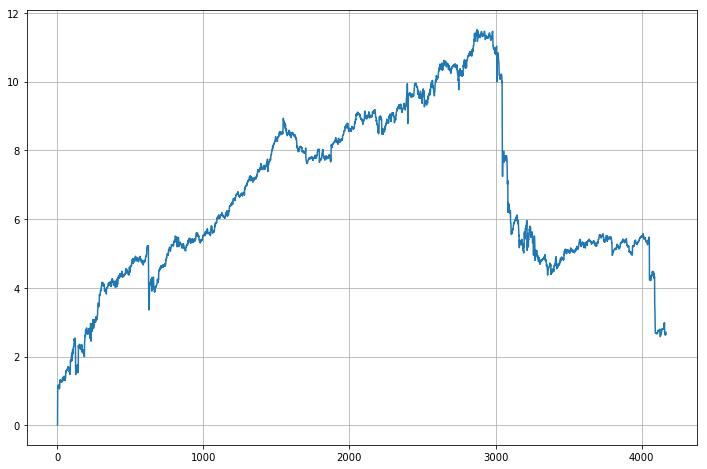

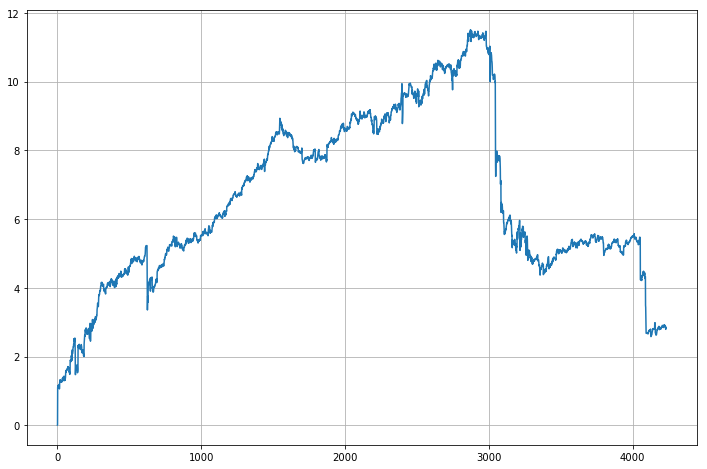

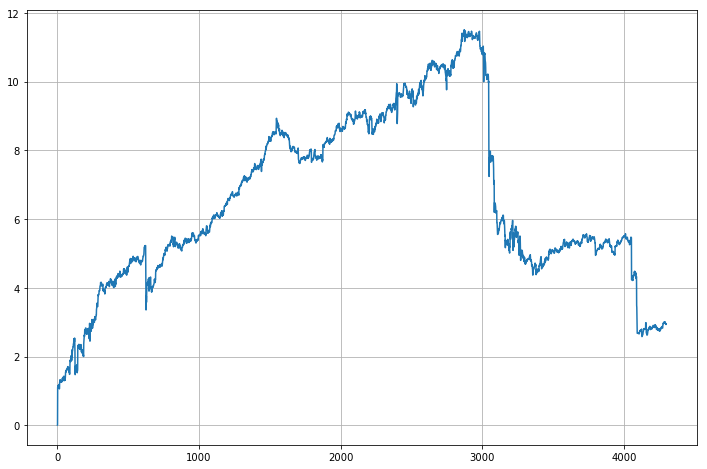

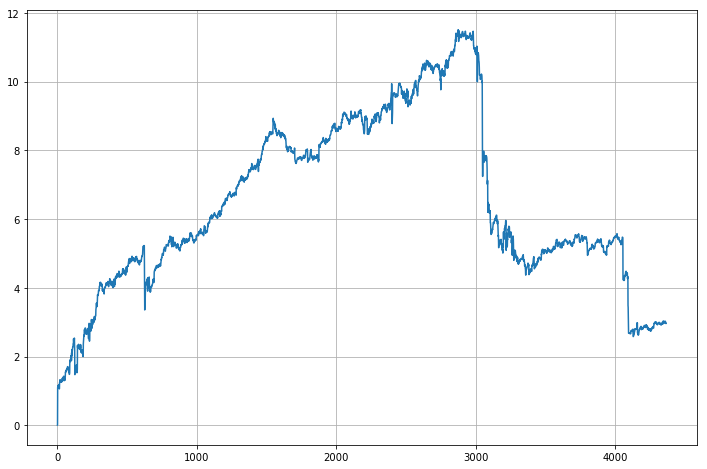

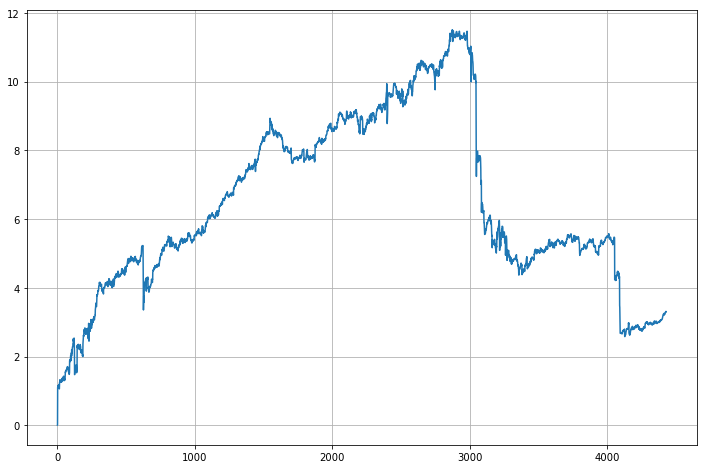

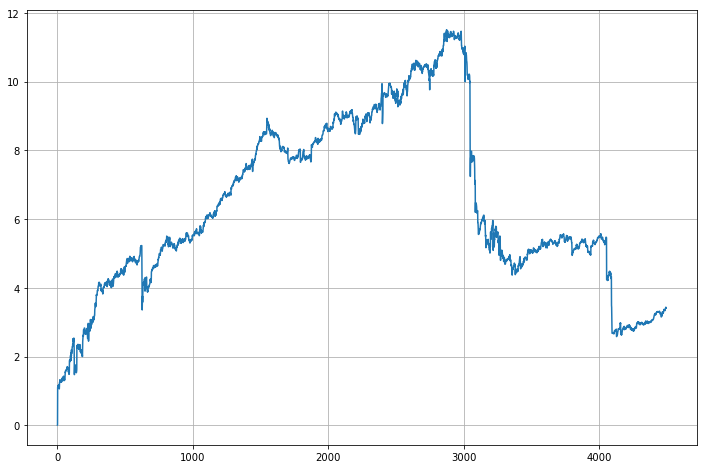

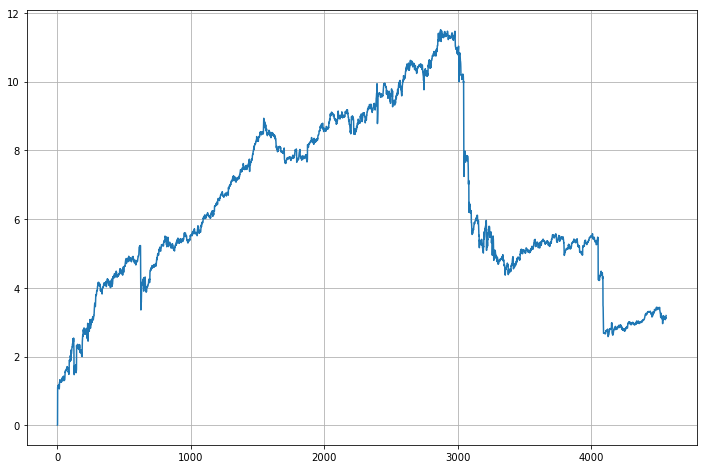

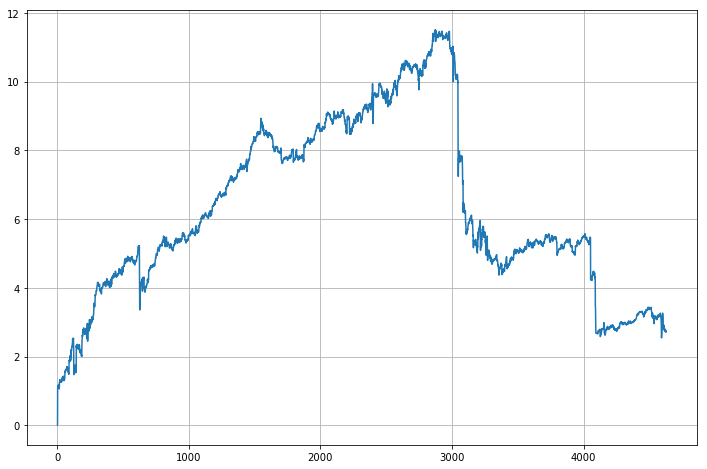

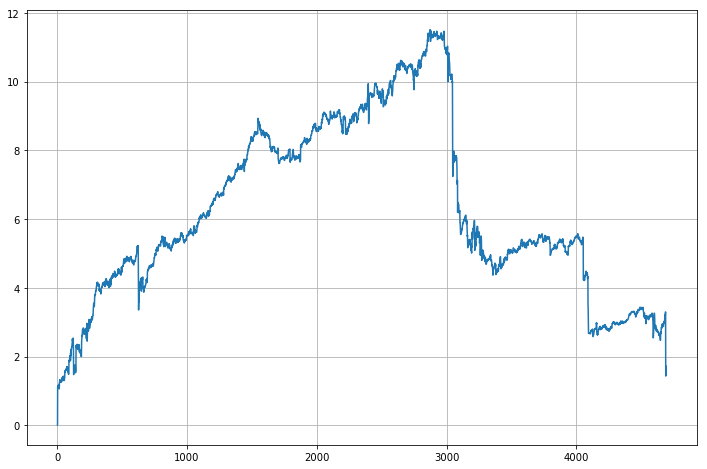

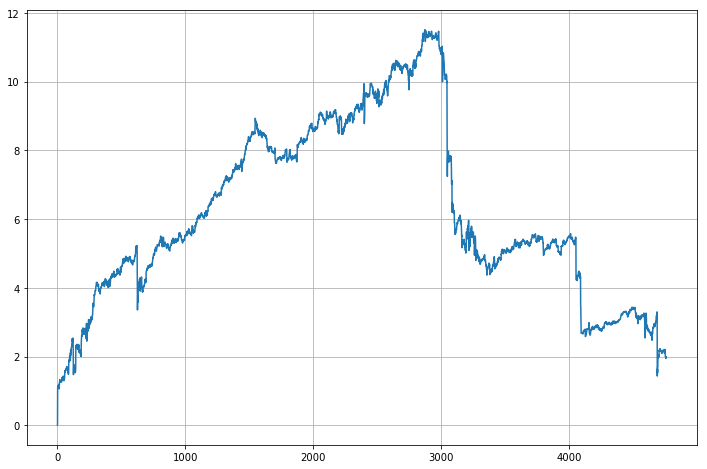

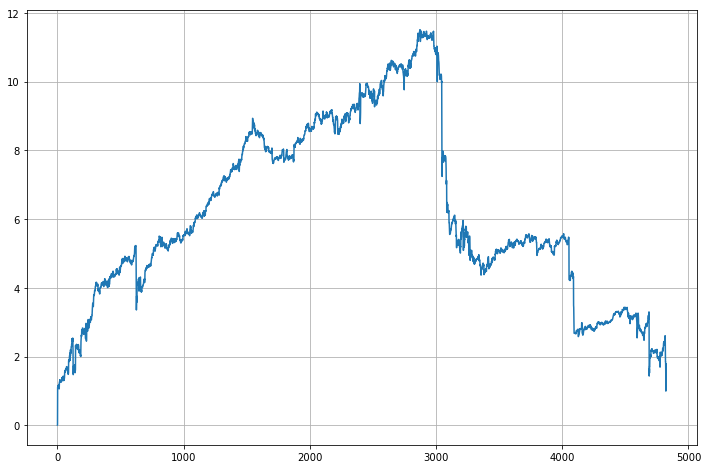

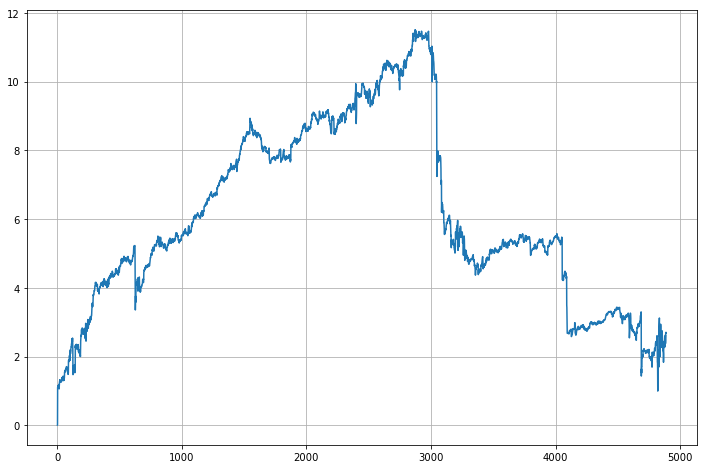

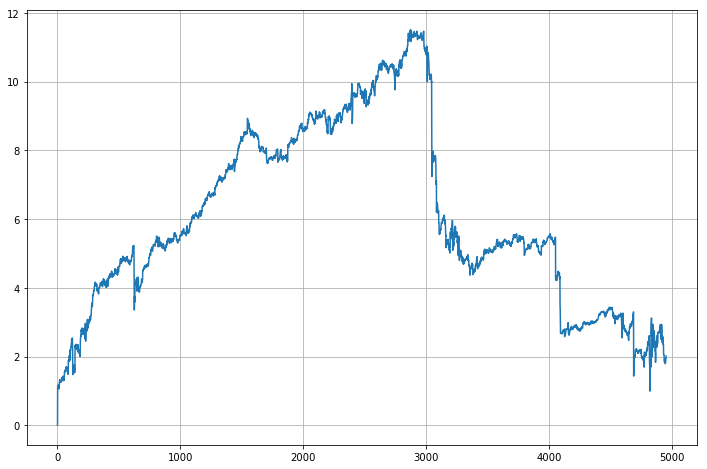

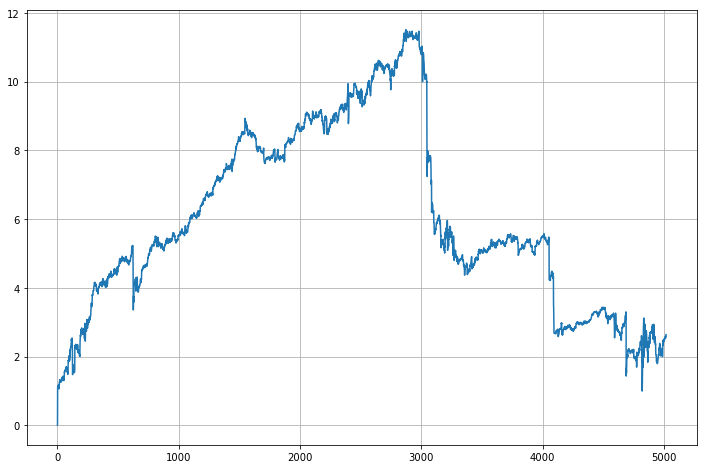

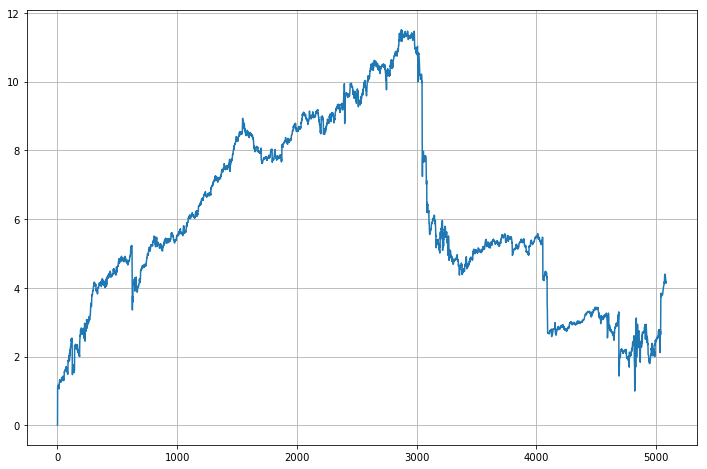

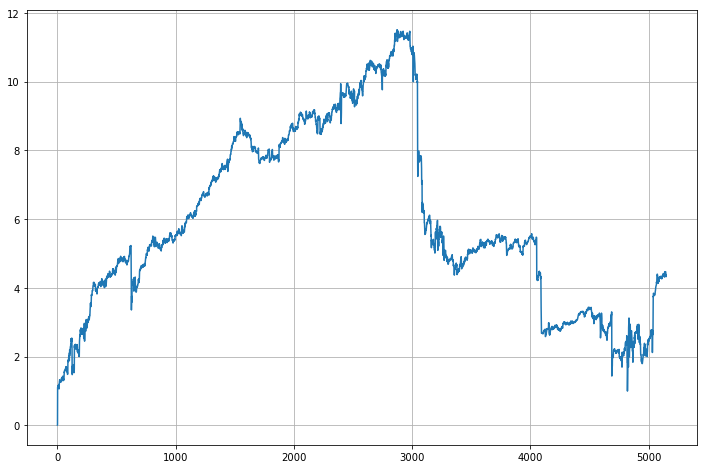

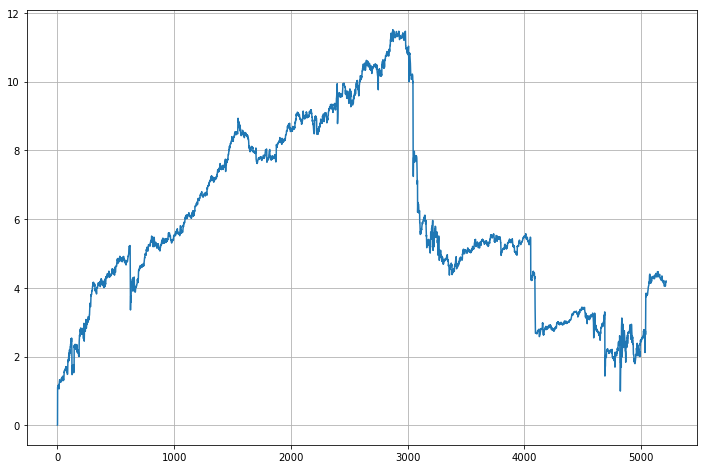

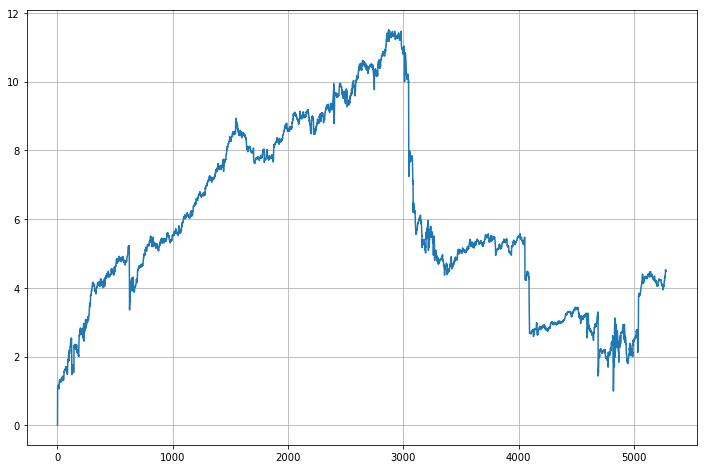

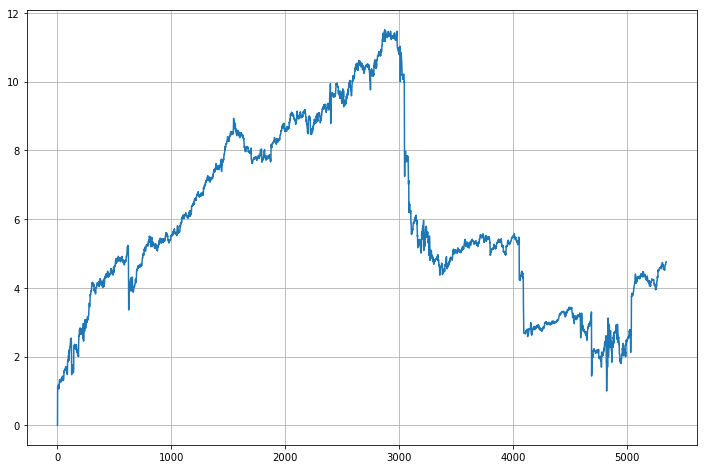

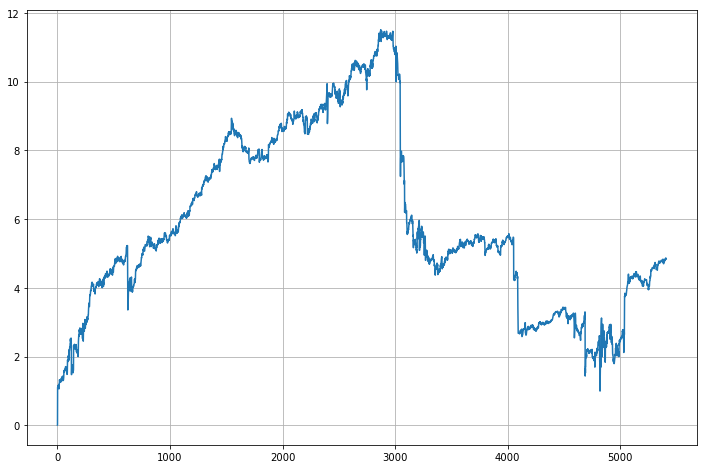

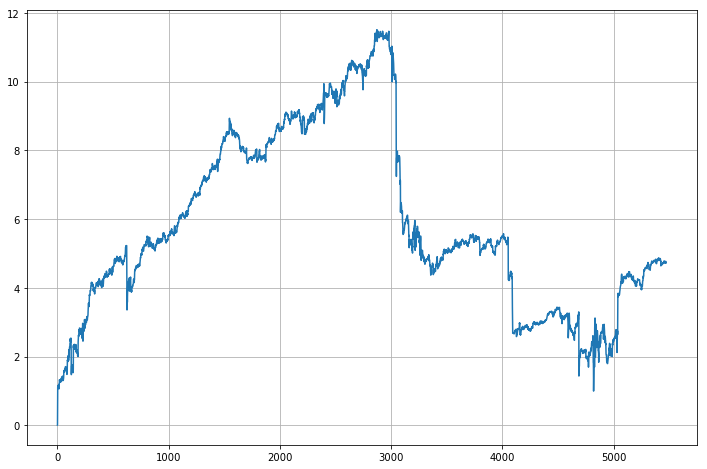

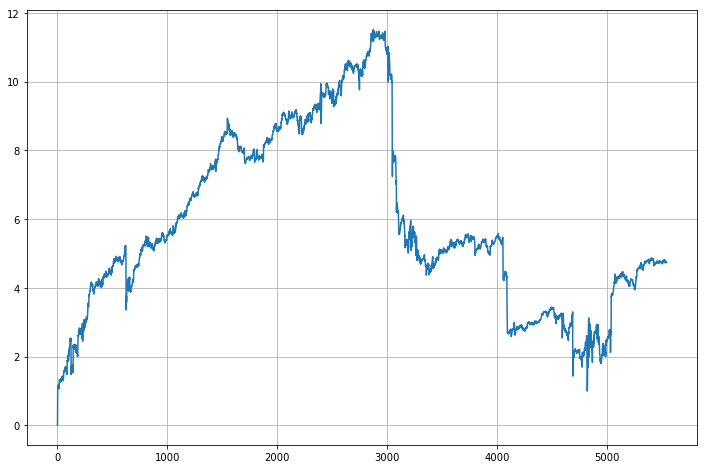

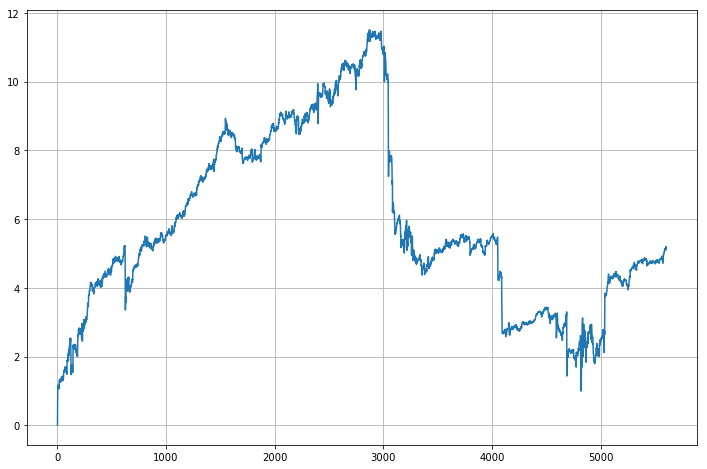

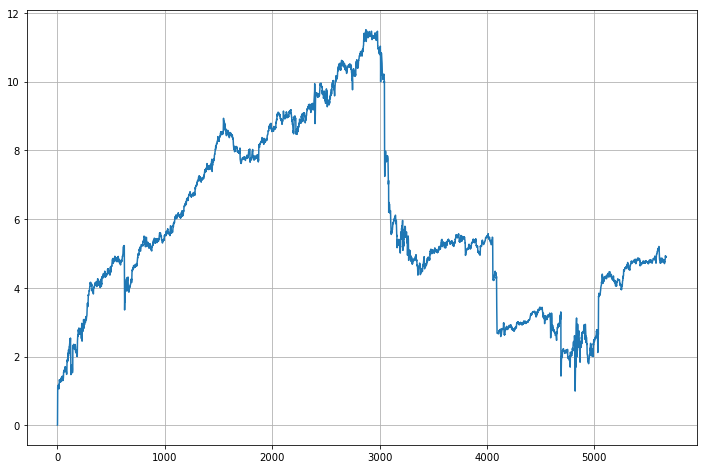

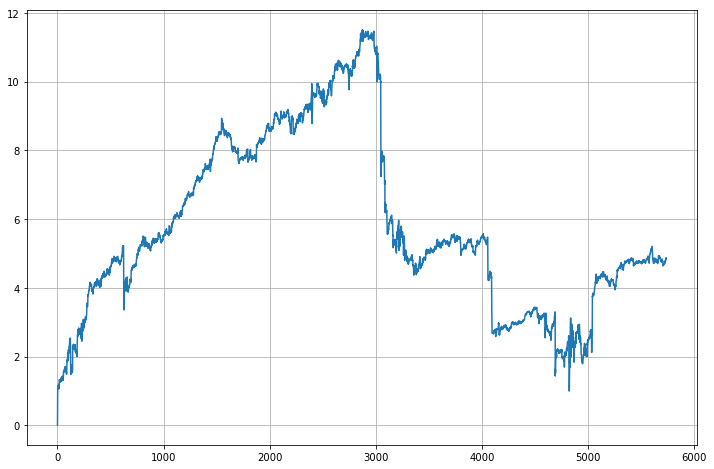

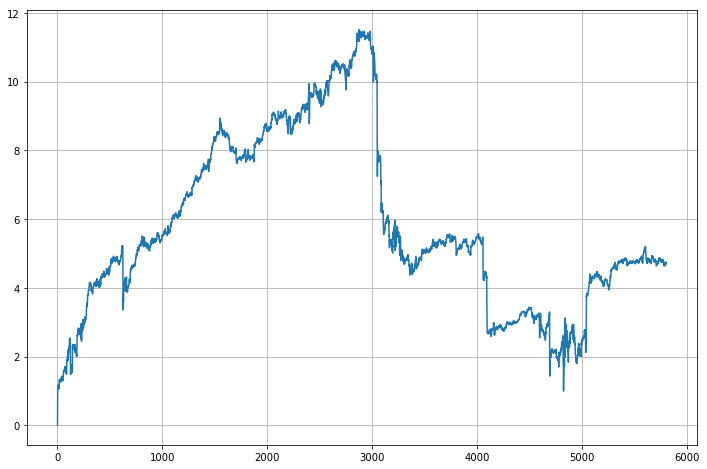

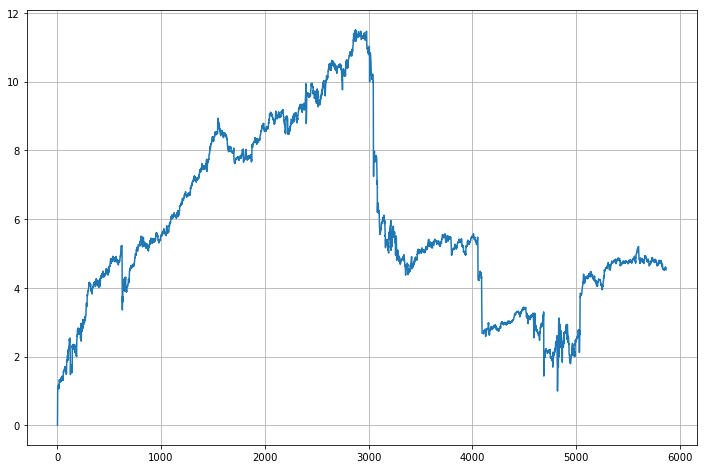

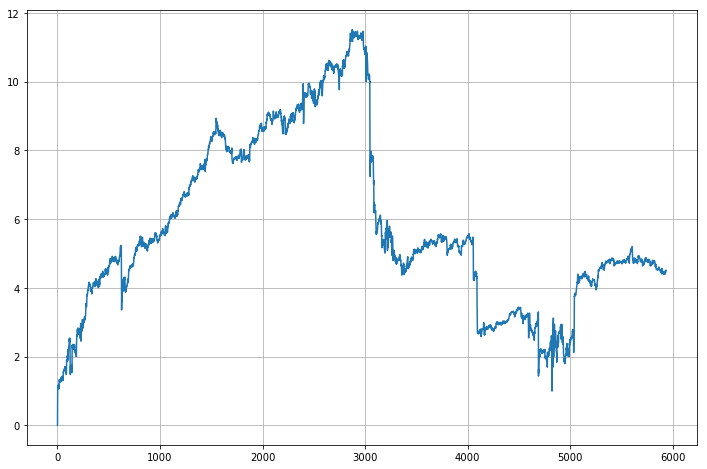

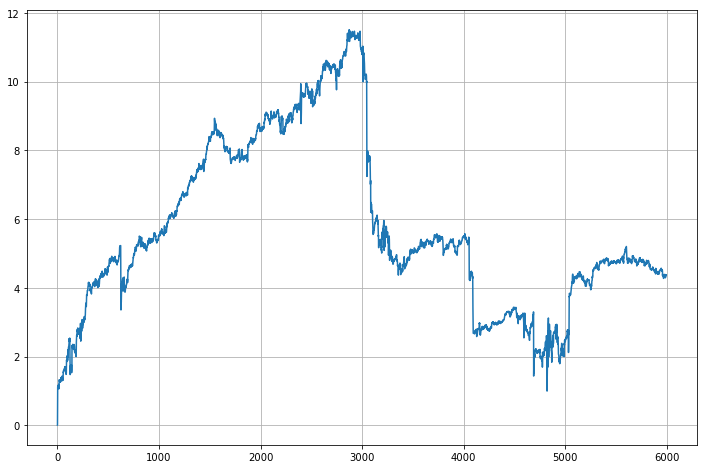

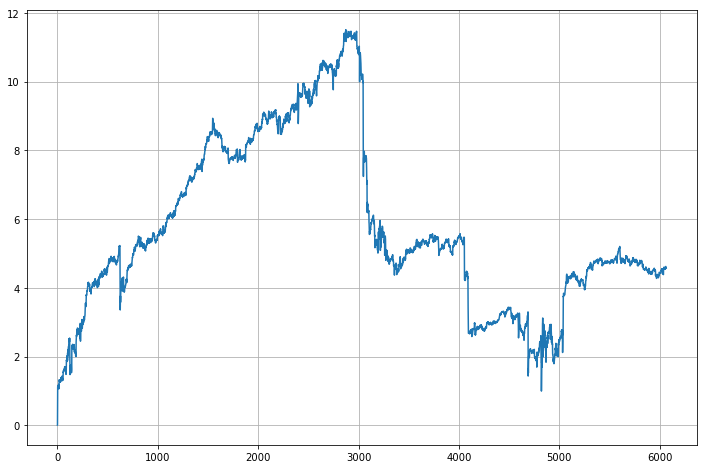

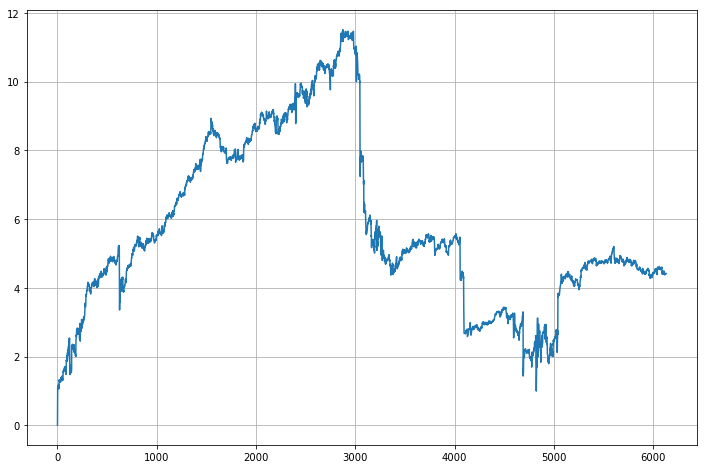

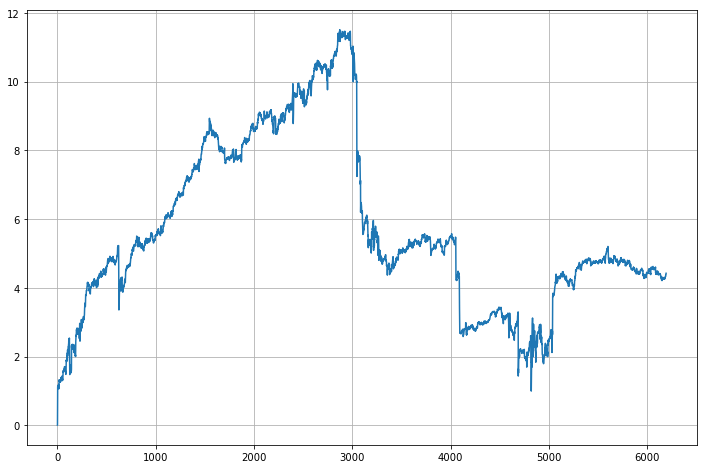

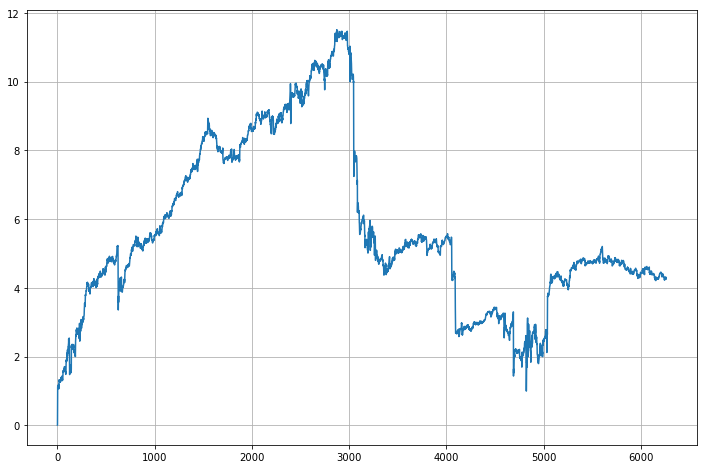

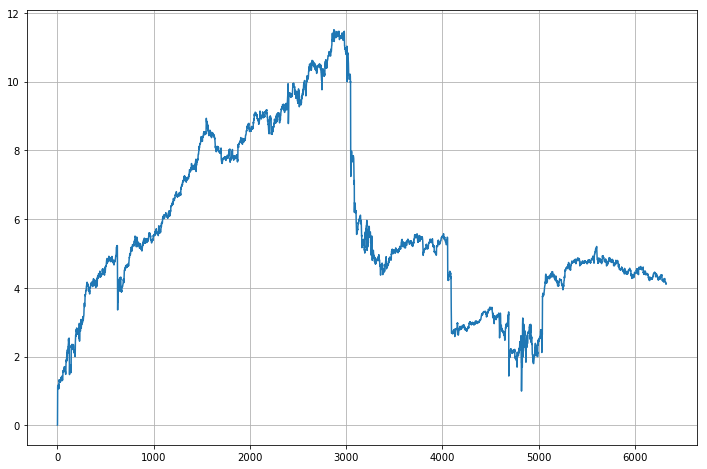

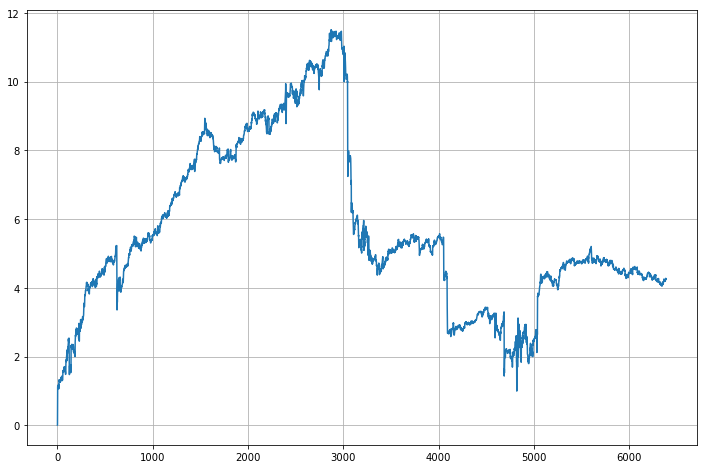

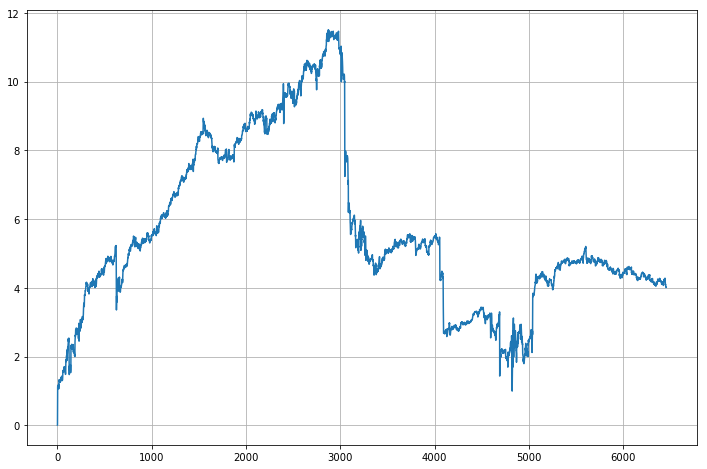

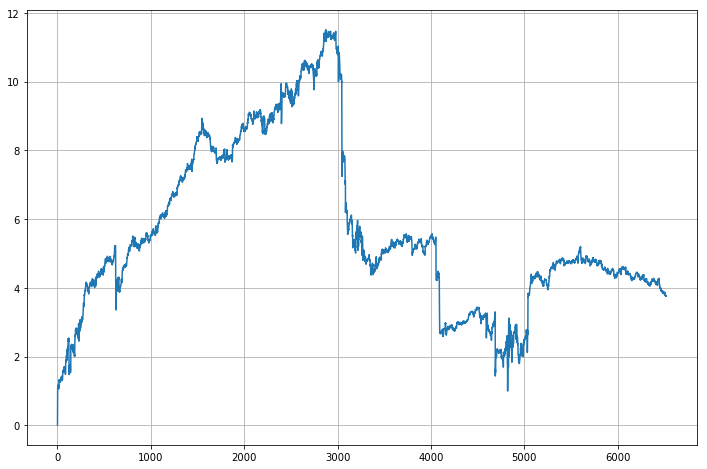

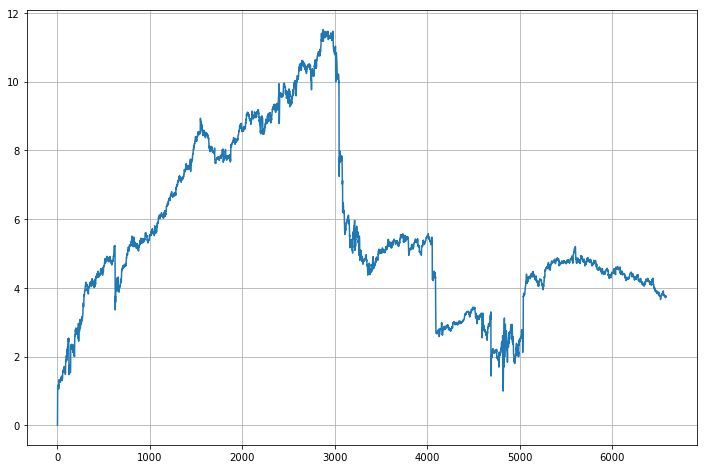

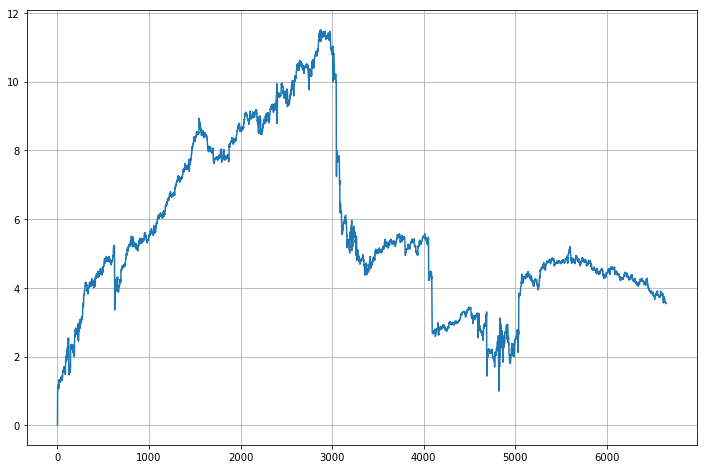

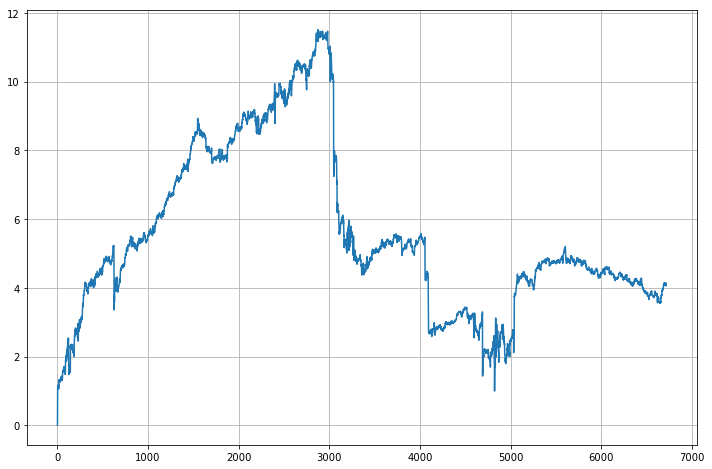

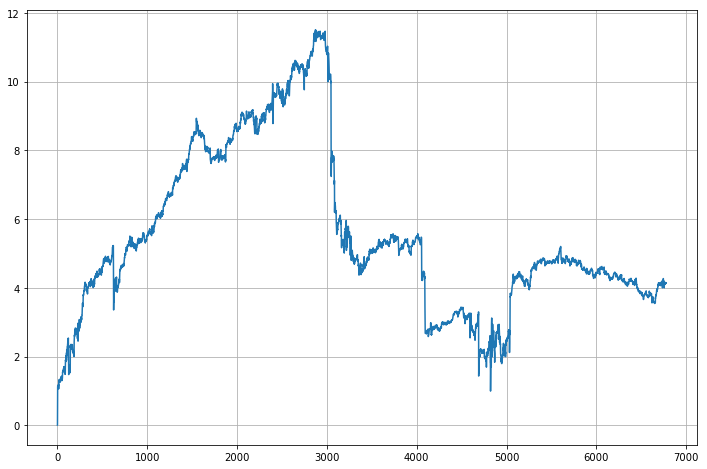

In [35]:
Q = 1
profits = np.empty([0])
tops_all = np.empty([0])
bottoms_all = np.empty([0])
for i in log_progress(range(len(split_points))):
    start = split_points[i]
    stop = split_points[i + 1] + 1 if i < len(split_points) - 1 else len(spfull_log)
    stocks = spchangesets[i]
    stocks_i, = np.where(np.vectorize(lambda s: s in stocks)(spstocks))
    N = len(stocks_i)
    stocks_prices = spfull_log[start - T:stop, stocks_i]
    stocks_pairs = calculate_pairwise_diffs(stocks_prices)
    ts, codes, weights, trading_signal = stat_arb(stocks_pairs[:-1], T=T, d=0, return_trading_signal=True)
    for t, cs, ws in log_progress(list(partition_as(ts, codes, weights))):
        pairs = decode_pairs(cs, N=N)
        prefs, cons = calculate_preference_flow(pairs, ws, return_consistency=True)
        pref_values = np.array(list(prefs.values()))
        order = np.argsort(np.abs(list(pref_values)))
        pref_values = pref_values[order]
        m = np.abs(pref_values[-Q if Q <= len(sorteds) else 0])
        M = pref_values[-1]
        tops = np.array([k for k, v in prefs.items() if v >= m])
        bottoms = np.array([k for k, v in prefs.items() if v <= -m])        
        new_profits = np.hstack([trade_singles(stocks_prices, t, tops, inv=False),
                                 trade_singles(stocks_prices, t, bottoms, inv=True)]) / (len(tops) + len(bottoms))
        profits = np.hstack([profits, new_profits])
    
    avg = np.mean(profits) * 255
    std = np.std(profits) * np.sqrt(255)
    sharpe = avg / std
    print('step {}: profit {}, avg {}, std {}, sharpe {}'.format(i + 1, np.sum(profits), avg, std, sharpe))
    plt.figure()
    plt.plot(np.cumsum(profits))
    plt.grid()

step 1: profit 0.9072221208406129, avg 3.9210447595653606, std 1.2211033376076474, sharpe 3.2110671053011495


step 2: profit 1.159824386306694, avg 2.2926761124667205, std 1.1549024246865305, sharpe 1.9851686717940786


step 3: profit 2.1417778237270637, avg 2.8152234280948516, std 1.1411622131128114, sharpe 2.466979186434513


step 4: profit 2.613094968524874, avg 2.623382743991507, std 1.0976230958807753, sharpe 2.3900578931298844


step 5: profit 3.0114325690098194, avg 2.370108966350321, std 1.004999804702787, sharpe 2.3583178377345493


step 6: profit 3.2605979399482448, avg 2.1374099606344537, std 0.933872094997153, sharpe 2.28876092570361


step 7: profit 3.5901358644661077, avg 2.0164860031692897, std 0.8831360281756873, sharpe 2.2833243564242163


step 8: profit 3.935011119609377, avg 1.9333869662820637, std 0.8458626176515796, sharpe 2.2856985590045875


step 9: profit 4.276444049604365, avg 1.8672829326183442, std 0.8083366719457711, sharpe 2.310031200395192


step 10: profit 4.288087786726324, avg 1.6848418884671998, std 0.872527236639507, sharpe 1.9309905957277393


step 11: profit 4.535839218326769, avg 1.6199425779738463, std 0.8431001389611787, sharpe 1.9214118265593572


step 12: profit 4.9208932895304685, avg 1.6108187276383434, std 0.8145911797364765, sharpe 1.9774566281940957


step 13: profit 4.986408860472712, avg 1.5065571794082244, std 0.791457369469965, sharpe 1.9035228396662198


step 14: profit 4.905418137367523, avg 1.3761073982714171, std 0.7738654298775753, sharpe 1.7782257032584021


step 15: profit 4.923009625325678, avg 1.2888782899979958, std 0.7515649548283754, sharpe 1.7149260110090143


step 16: profit 5.106594390490928, avg 1.2533027618625472, std 0.7334137303112127, sharpe 1.7088618743621389


step 17: profit 5.4336935545723115, avg 1.2550650873332785, std 0.7176539431864675, sharpe 1.7488444106648988


step 18: profit 5.504213489972413, avg 1.2006624807039907, std 0.7034212787417182, sharpe 1.7068896221788155


step 19: profit 5.879712123900449, avg 1.215013445376511, std 0.6895025391867896, sharpe 1.762159493726473


step 20: profit 6.114460752367999, avg 1.2002983001184295, std 0.6770235036025917, sharpe 1.772904919447223


step 21: profit 6.31090957818792, avg 1.1798254709955425, std 0.6652795485124895, sharpe 1.7734281380414225


C:\Users\Helena\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


step 22: profit 6.502222491939168, avg 1.1602986252235745, std 0.6534839528735936, sharpe 1.775557946176555


step 23: profit 6.855384868823748, avg 1.1700958109438124, std 0.6470288152827482, sharpe 1.8084137573262276


C:\Users\Helena\ipynb\utility\functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return (mean, var) if not return_stds else (mean, np.sqrt(var))
C:\Users\Helena\ipynb\utility\functions.py:395: RuntimeWarning: invalid value encountered in greater_equal
  weights = trading_signal[ts, codes]


step 24: profit 7.225929977622942, avg 1.1819192715162607, std 0.641074834851605, sharpe 1.8436525772998866


step 25: profit 7.111518170020923, avg 1.1132210763384502, std 0.6323962252598824, sharpe 1.7603221396221547


step 26: profit 7.076530307101454, avg 1.0652392138789084, std 0.623228807617213, sharpe 1.709226532630337


step 27: profit 7.019748543324956, avg 1.0176440469288595, std 0.615535365878056, sharpe 1.65326657628713


step 28: profit 7.028719527849891, avg 0.9826334866237512, std 0.6108392841664398, sharpe 1.6086612503396325


step 29: profit 7.34445453571146, avg 0.9914430421420976, std 0.6076954703832309, sharpe 1.6314800594397454


step 30: profit 7.60085200509189, avg 0.9919228563451545, std 0.600410614261344, sharpe 1.6520741518959803


step 31: profit 7.766515495304119, avg 0.9809120610710996, std 0.5967950019142961, sharpe 1.6436331703930143


step 32: profit 8.203335843552406, avg 1.0037671017782455, std 0.593674754712954, sharpe 1.6907693881367318


step 36: profit 8.516203106075153, avg 0.9264640751062987, std 0.5951232184561878, sharpe 1.5567600899686689
step 45: profit 10.252234146328863, avg 0.8925639150952066, std 0.624546636830362, sharpe 1.4291389344838354


step 46: profit 9.536482361638926, avg 0.8108712911696986, std 0.6281981807744395, sharpe 1.2907889834543307


step 47: profit 7.971296683235829, avg 0.663407524224914, std 0.7090226511265193, sharpe 0.9356647818950066


step 48: profit 7.084903547846272, avg 0.5783131897249678, std 0.7307898826515925, sharpe 0.7913535798095899


step 49: profit 6.419928799790185, avg 0.5125491058066678, std 0.7355915033593201, sharpe 0.696784972999204


step 50: profit 7.220987311511532, avg 0.5650051440427863, std 0.7435923413627833, sharpe 0.7598318495417801


step 51: profit 6.735321578678628, avg 0.5166988575701114, std 0.7601719444041533, sharpe 0.6797131377626889


step 52: profit 6.3992684273912515, avg 0.48150293566974595, std 0.7577722052486116, sharpe 0.6354191039664399


step 53: profit 6.700374690351221, avg 0.49467155357254233, std 0.752588596003376, sharpe 0.6572934485049297


step 54: profit 7.01729577967891, avg 0.5084996941796311, std 0.7474081072691715, sharpe 0.6803507872526998


step 55: profit 7.078717813025243, avg 0.5036476122548652, std 0.7417085458570783, sharpe 0.6790370895253435


step 56: profit 7.105995522119798, avg 0.4965823124528771, std 0.7361806703190361, sharpe 0.674538645843112


step 57: profit 7.2820863015159825, avg 0.49998169275352056, std 0.7305523937687016, sharpe 0.6843885490187286


step 58: profit 7.396567222313073, avg 0.4991068117729118, std 0.7257567861900047, sharpe 0.6877053322409369


step 59: profit 7.187413372959529, avg 0.47679251043305926, std 0.7218844037937501, sharpe 0.6604831852958052


step 60: profit 7.152193963165221, avg 0.46656675891714794, std 0.716936836209563, sharpe 0.6507780537318756


step 61: profit 7.155452723754187, avg 0.4591445507190029, std 0.7127797882559096, sharpe 0.6441604521958696


step 62: profit 7.061471301141083, avg 0.44582203064891707, std 0.7084253974867982, sharpe 0.6293140141933224


step 63: profit 5.899696560602861, avg 0.3665747131953532, std 0.7305542786394837, sharpe 0.501776149854365


step 64: profit 5.669208111886391, avg 0.3467613500913959, std 0.7300400631258775, sharpe 0.4749894801754262


step 65: profit 5.63616137359329, avg 0.33944760280261904, std 0.7257375669870408, sharpe 0.4677277548299775


step 66: profit 5.69685173007146, avg 0.33791514100214526, std 0.7209590353069829, sharpe 0.4687022763481446


step 67: profit 5.895835948902293, avg 0.34450920416363073, std 0.716015879228386, sharpe 0.4811474356335376


step 68: profit 5.987164516698888, avg 0.34471143638704366, std 0.7112592482024228, sharpe 0.4846494963098737


step 69: profit 5.960667447354194, avg 0.33822211817430337, std 0.706752553710932, sharpe 0.47855804184704676


step 70: profit 5.802972817048511, avg 0.32422394135569027, std 0.7028600840690502, sharpe 0.4612922951587587


step 71: profit 5.276239780673178, avg 0.29065481617447836, std 0.7042609521600979, sharpe 0.4127089756758295


step 72: profit 4.406104340910553, avg 0.23941116704287044, std 0.7449021181727099, sharpe 0.3213994982725523


step 73: profit 4.752722325133848, avg 0.25466362532236425, std 0.7494078852201591, sharpe 0.3398197835182236


step 74: profit 3.928517453850544, avg 0.2076641688913534, std 0.7738244330406526, sharpe 0.268360832282539


step 75: profit 4.841764306526091, avg 0.2525362851634595, std 0.8197864005462345, sharpe 0.3080513228753139


step 76: profit 4.03241515935565, avg 0.20756275043110428, std 0.8268387590639223, sharpe 0.2510317134456656


step 77: profit 4.7207048927074595, avg 0.23984454027503532, std 0.8275680663778483, sharpe 0.2898185055941101


step 87: profit 5.778422888345486, avg 0.25992200326831877, std 0.8095675398349993, sharpe 0.32106277793856997


step 88: profit 5.890515911858971, avg 0.26196050881130756, std 0.8055758057005121, sharpe 0.3251841812497237


step 89: profit 5.929100013098322, avg 0.260720900731173, std 0.8016098410309106, sharpe 0.3252466316978754


step 90: profit 5.903831585109383, avg 0.25651338459752815, std 0.797456232935914, sharpe 0.3216645302942191


step 91: profit 5.995232809590228, avg 0.2576313391381039, std 0.793588640516659, sharpe 0.32464091090111274


step 92: profit 5.928336113941248, avg 0.2522064913338369, std 0.7901916612145127, sharpe 0.3191712893378289


step 93: profit 6.078973920273747, avg 0.2556296750774745, std 0.7861716262152701, sharpe 0.32515759479658174


step 94: profit 6.113001558336013, avg 0.25433437712117524, std 0.782673676637034, sharpe 0.324955833718582


step 95: profit 6.081669949128996, avg 0.25037549839003775, std 0.7787950674350361, sharpe 0.32149086307730507


step 96: profit 5.914082514555374, avg 0.2409476020469117, std 0.7751656460766233, sharpe 0.3108336950514118


step 97: profit 5.875175440503623, avg 0.23690223550417835, std 0.7715948562489694, sharpe 0.30702930895088476


step 98: profit 5.974577383974997, avg 0.2384594197704843, std 0.7679019175201871, sharpe 0.31053369490279403


step 99: profit 5.928925218691276, avg 0.2342540952535289, std 0.7647451078168477, sharpe 0.30631656595001255


step 100: profit 5.7471209336494455, avg 0.2248068473815936, std 0.761329880865005, sharpe 0.2952817865577184


step 101: profit 5.797422505883928, avg 0.22453565294659805, std 0.7579578389861381, sharpe 0.29623765518005873


step 102: profit 5.794336303816105, avg 0.22222225259033038, std 0.7548394293705718, sharpe 0.2943967206053769


step 103: profit 6.00908816655192, avg 0.22822720918539463, std 0.7523795443660274, sharpe 0.3033405292507045


step 104: profit 6.230125146173236, avg 0.2344571889424698, std 0.7509295560750534, sharpe 0.3122226140197849


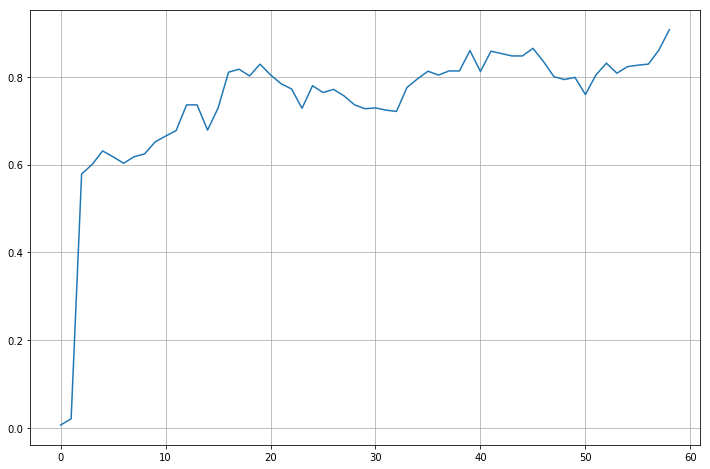

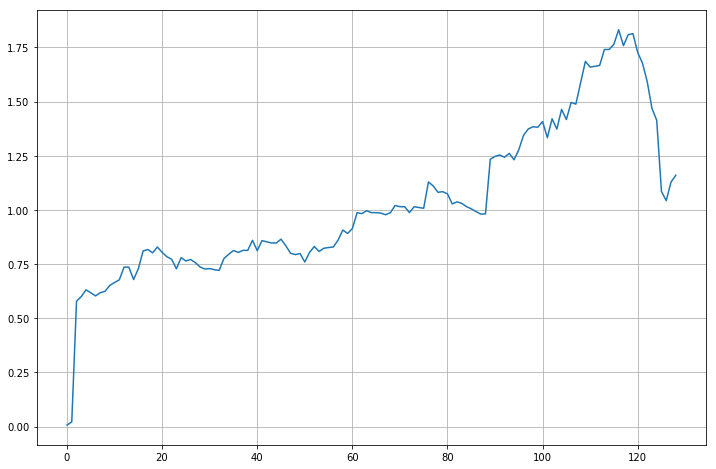

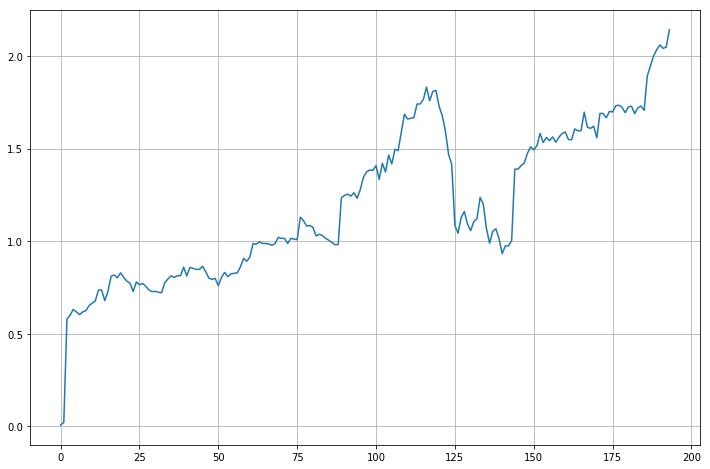

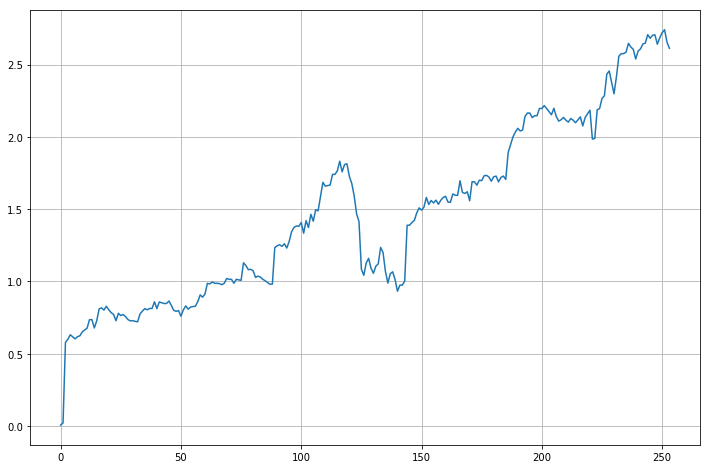

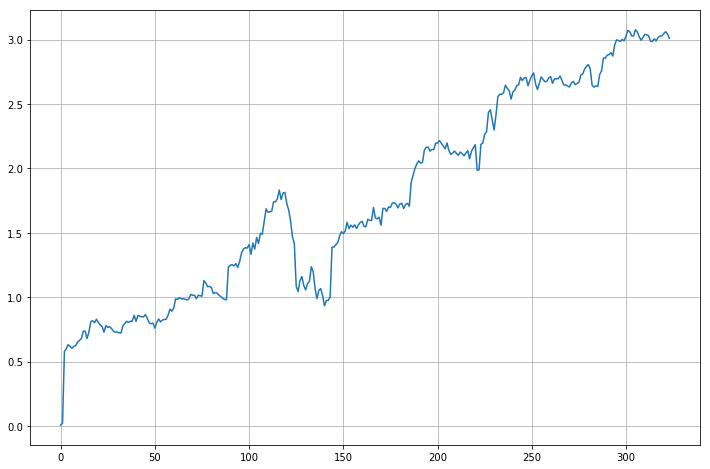

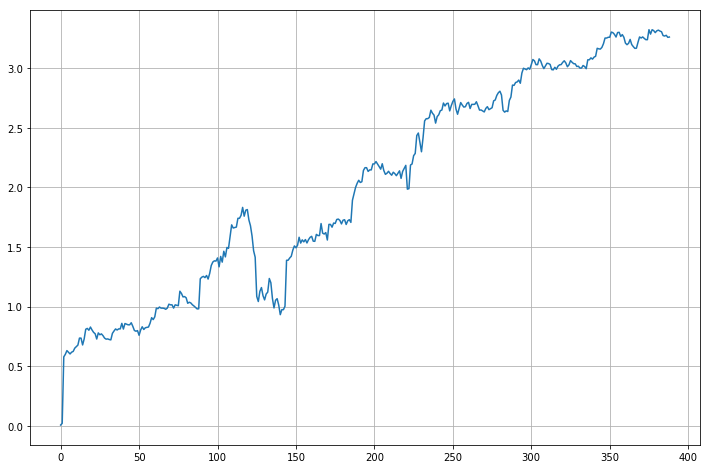

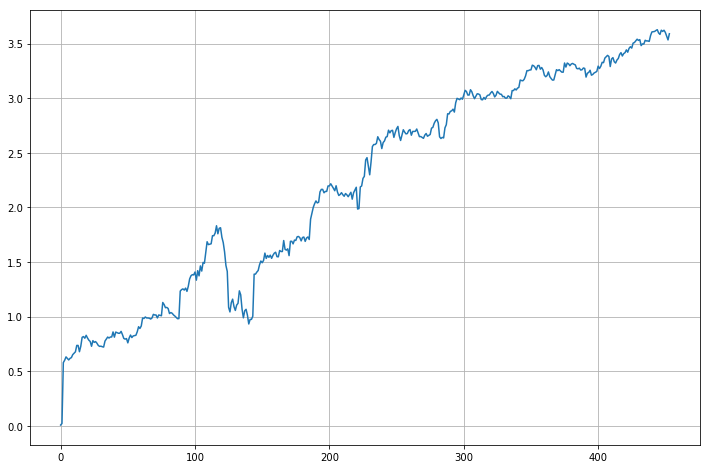

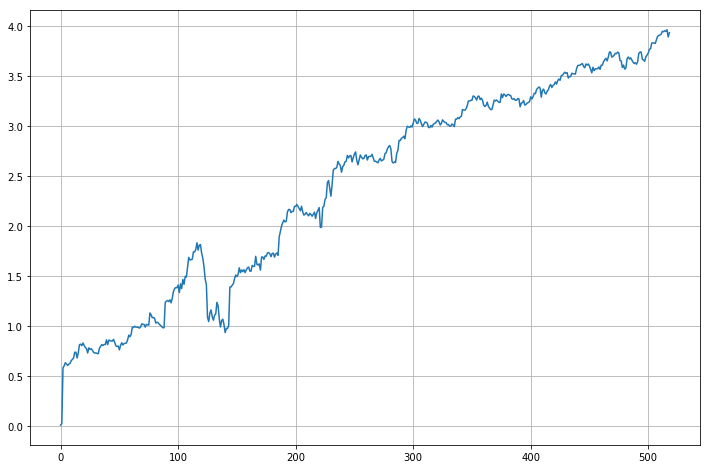

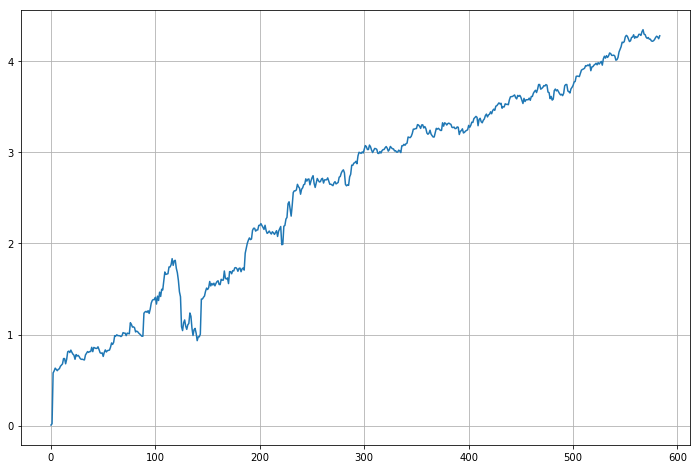

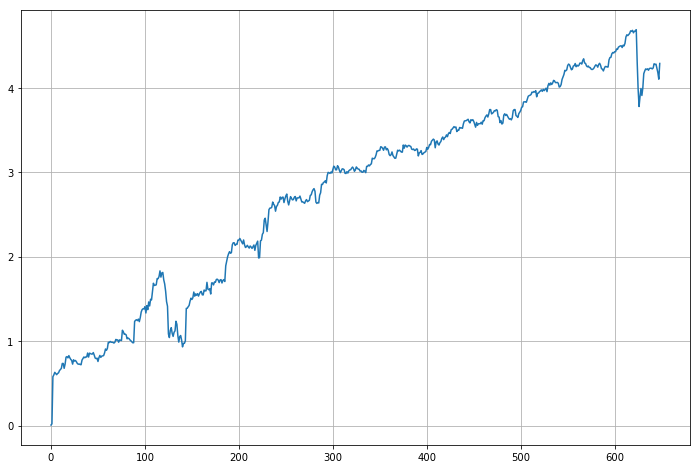

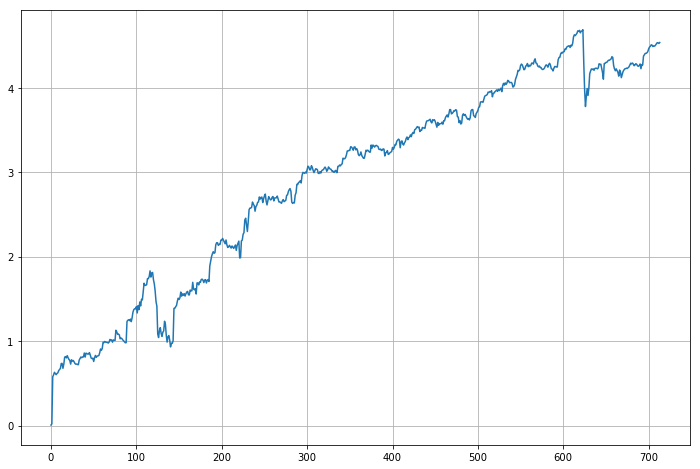

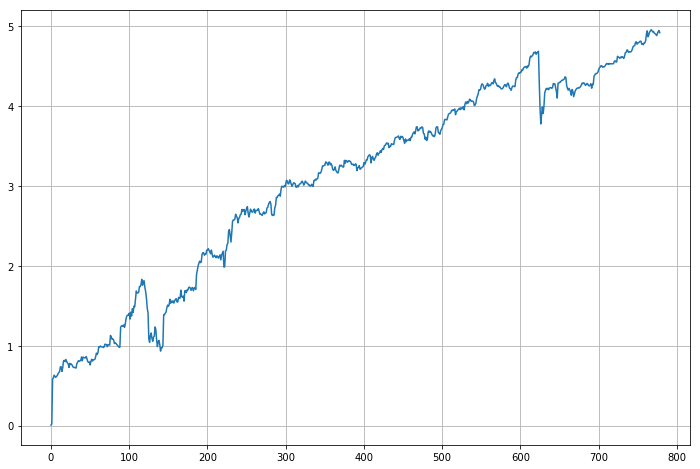

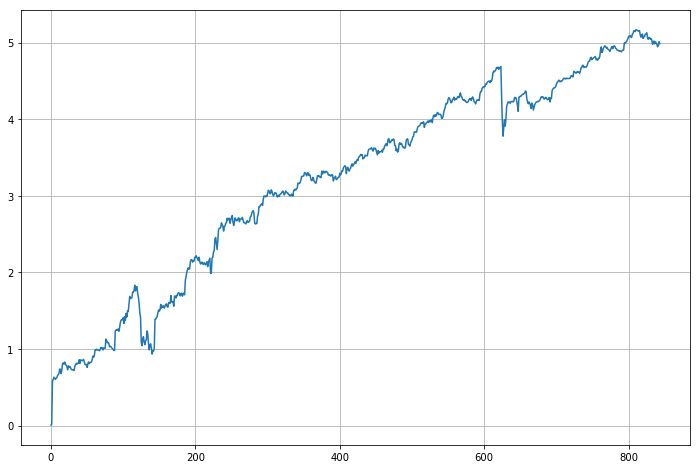

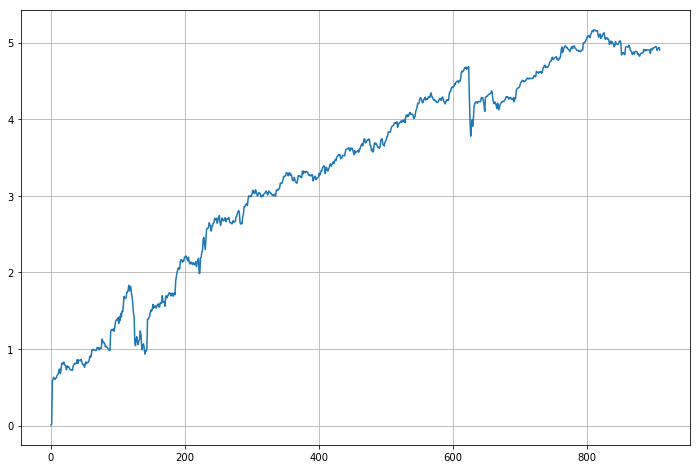

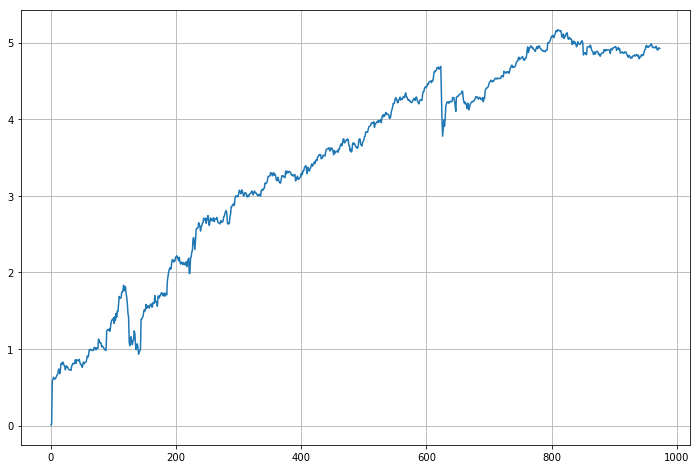

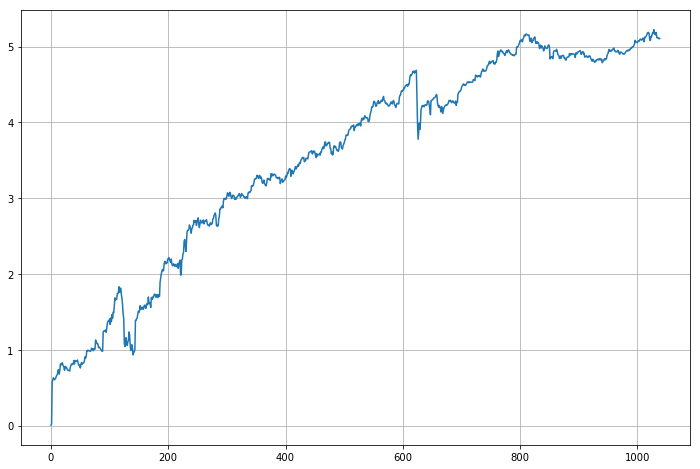

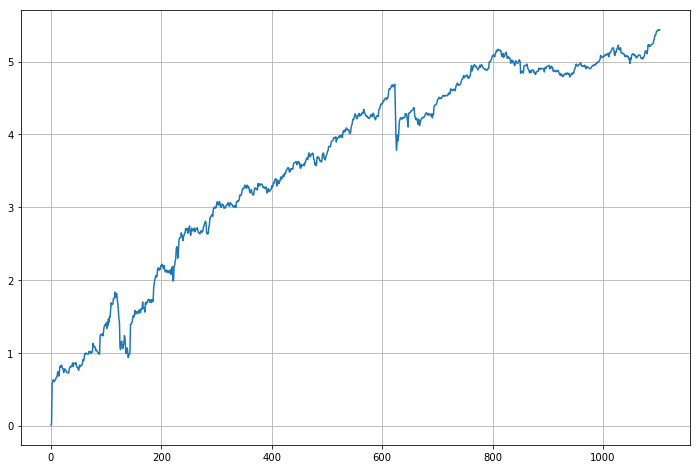

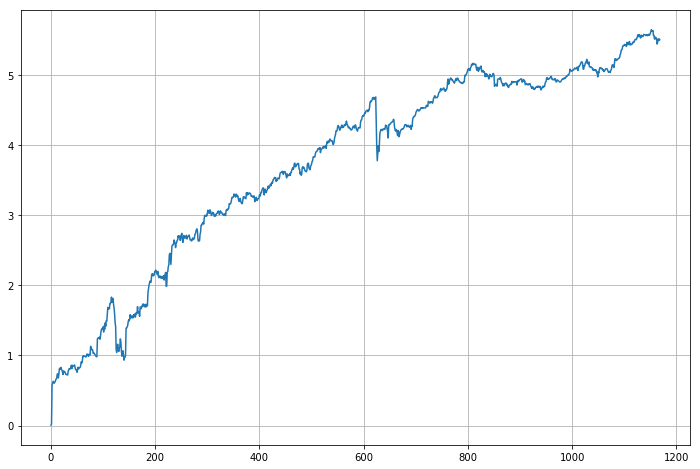

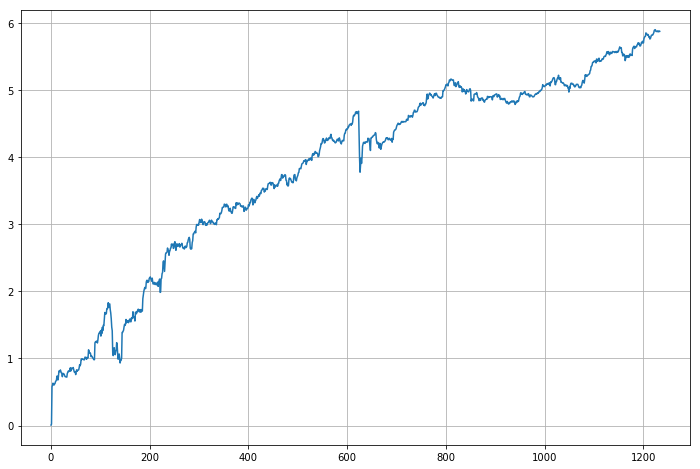

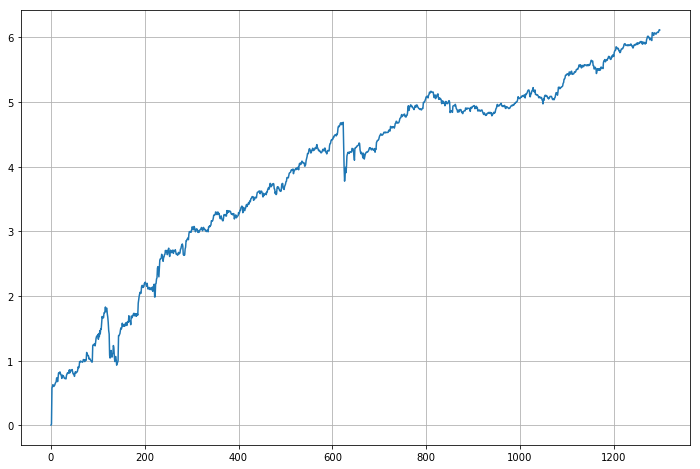

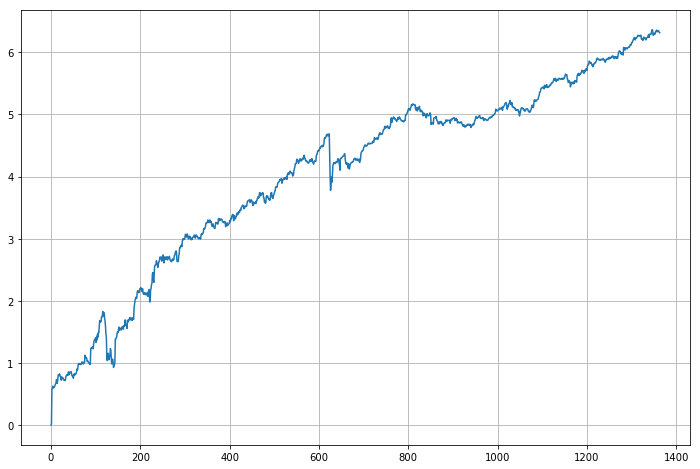

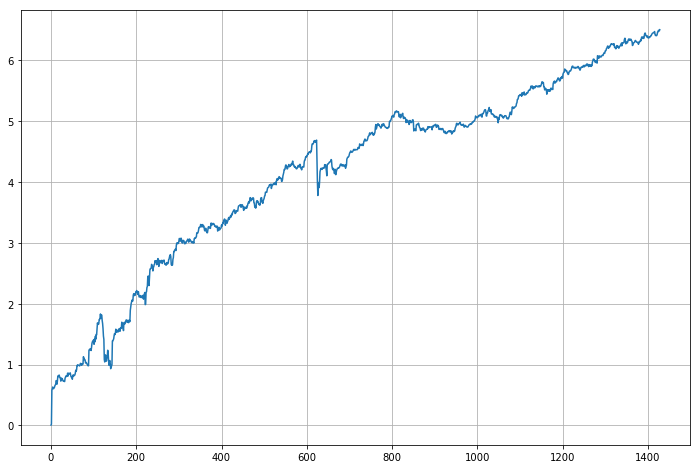

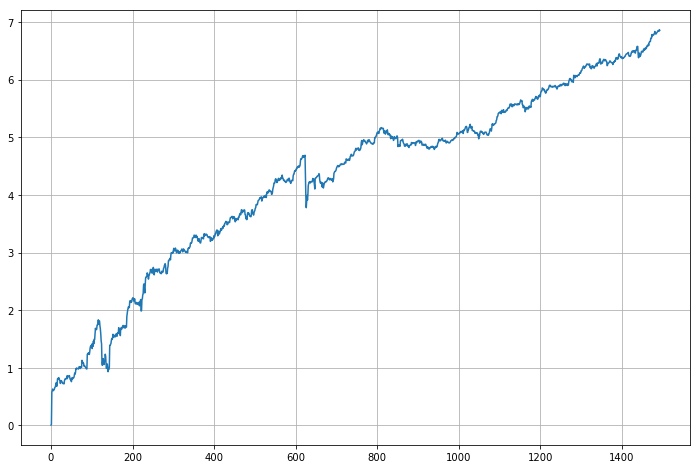

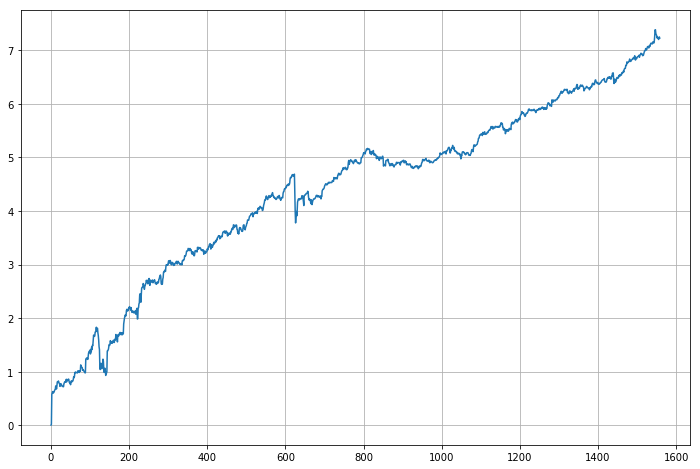

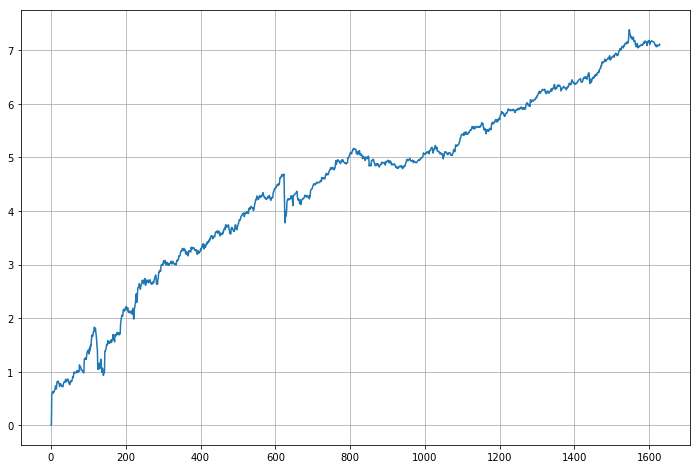

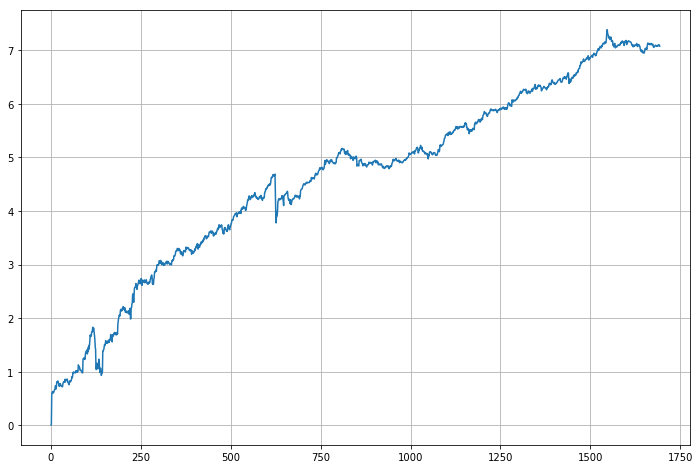

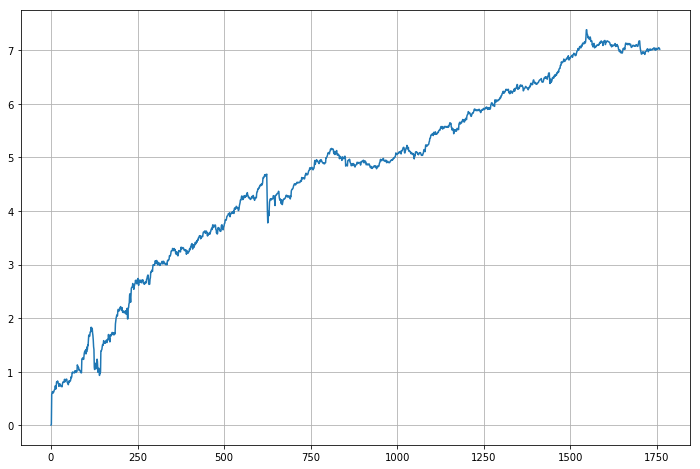

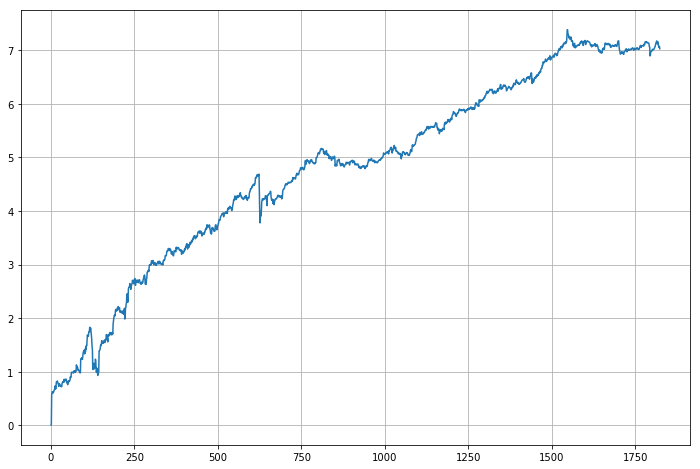

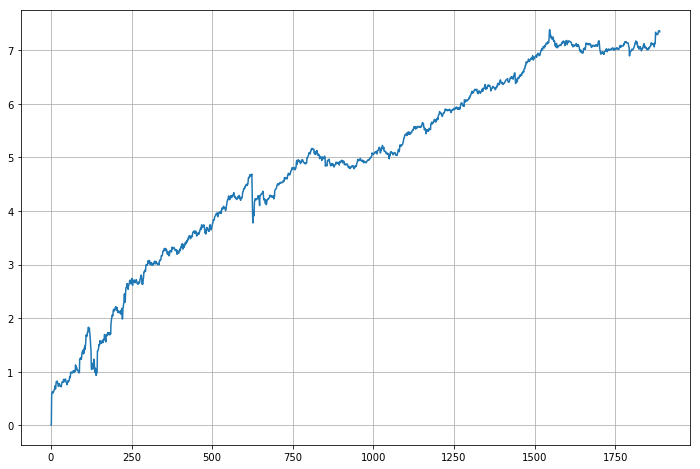

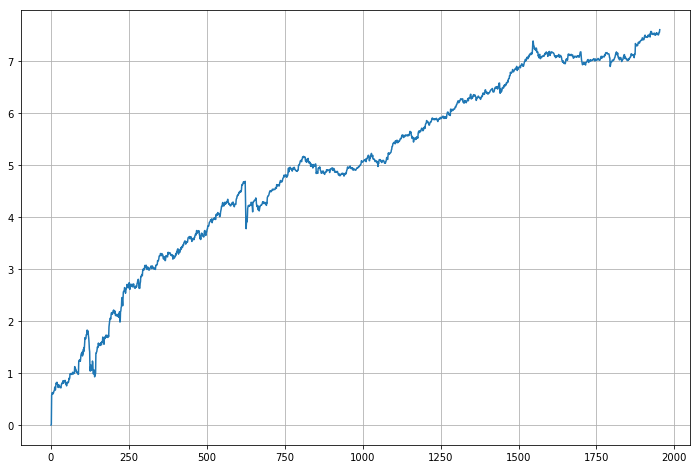

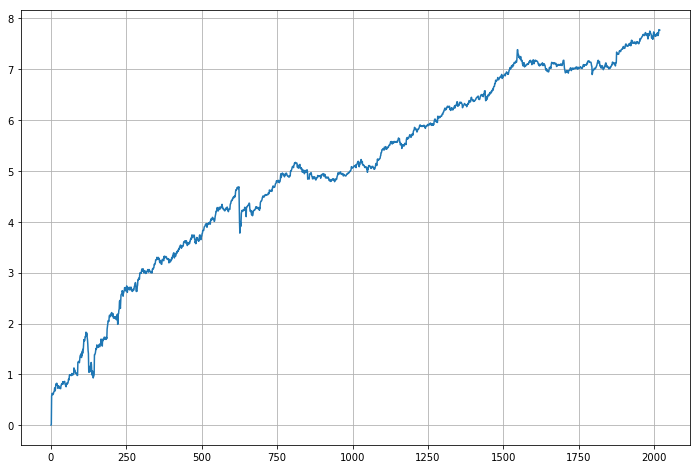

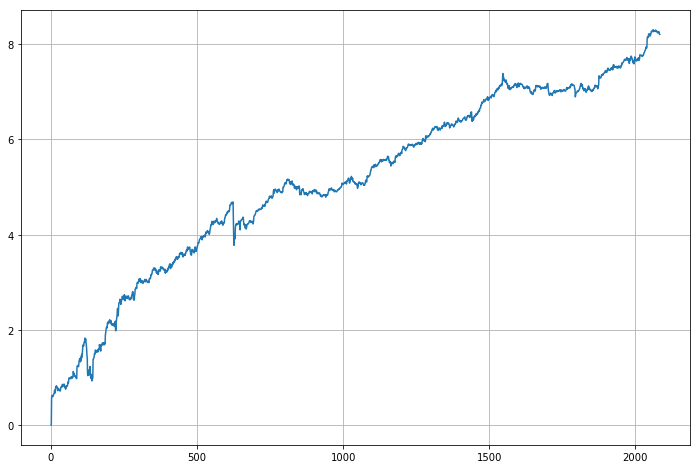

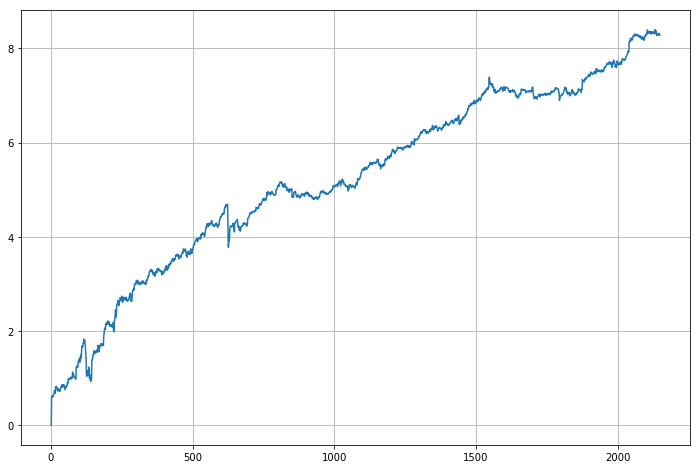

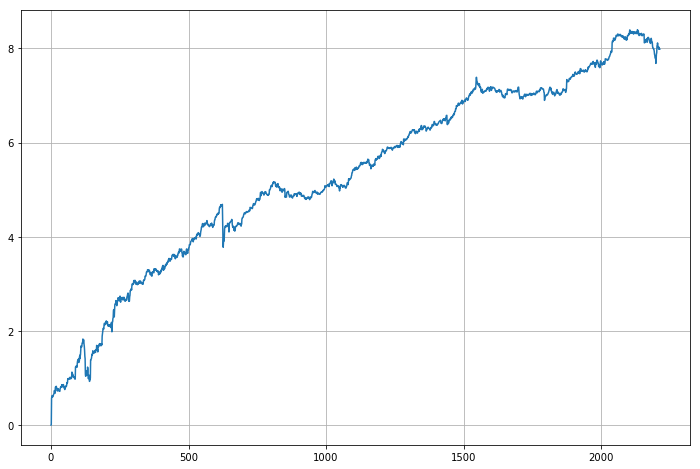

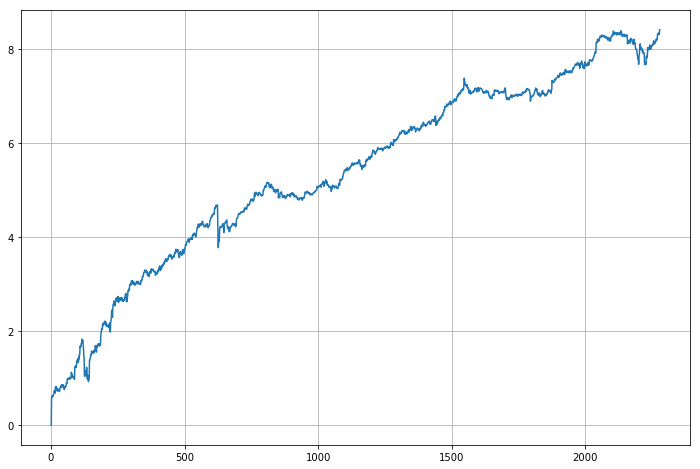

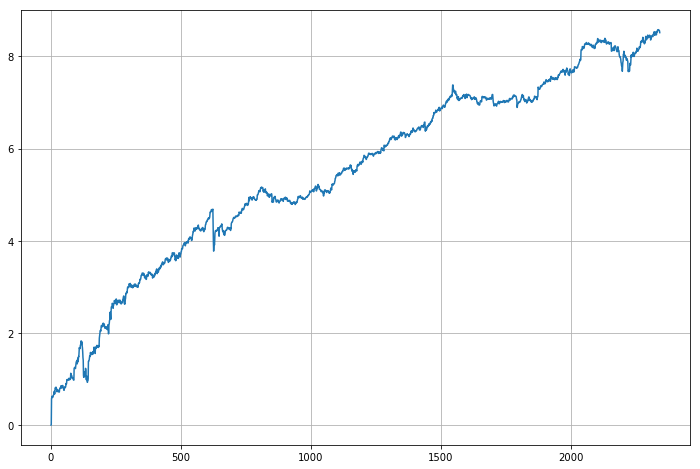

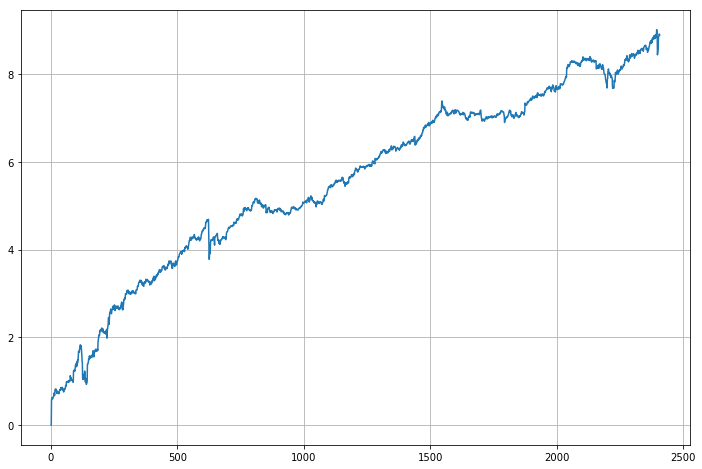

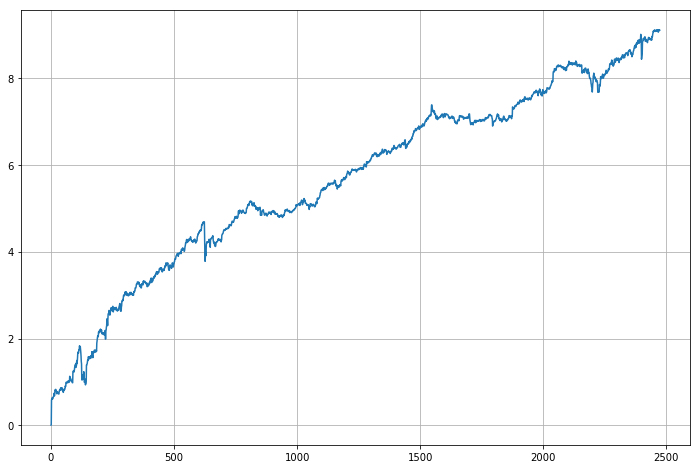

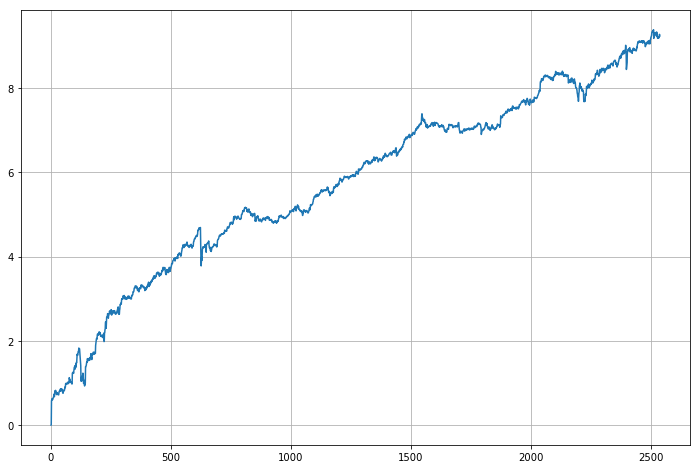

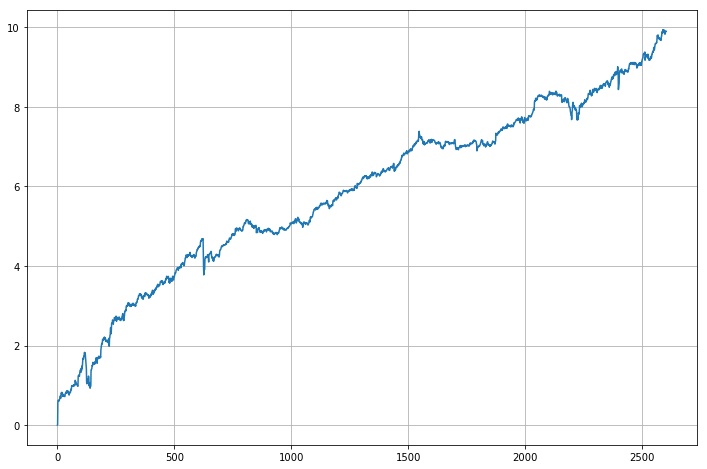

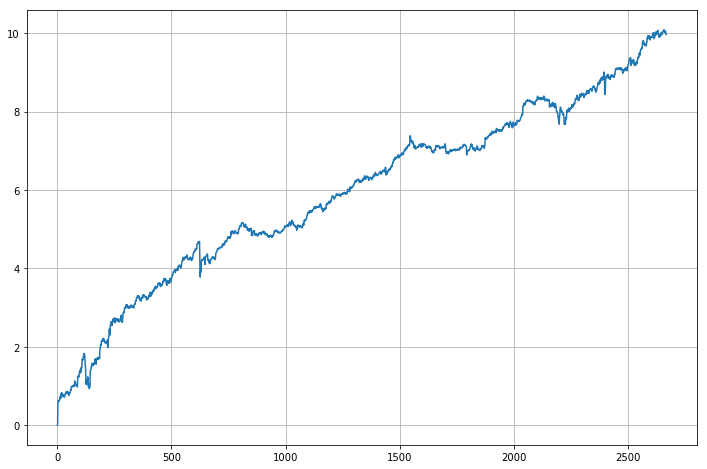

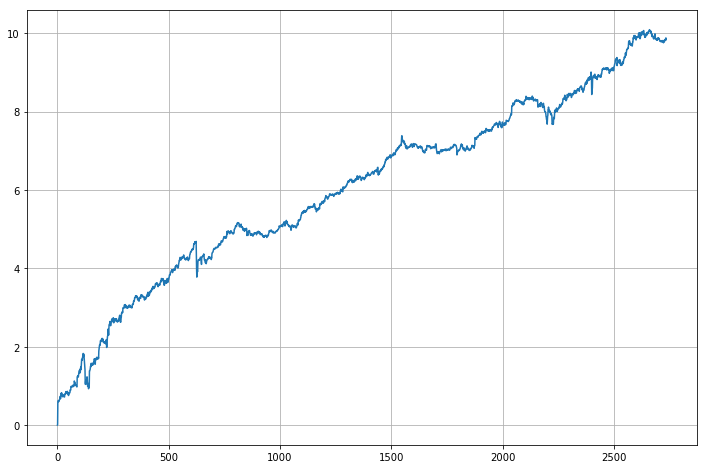

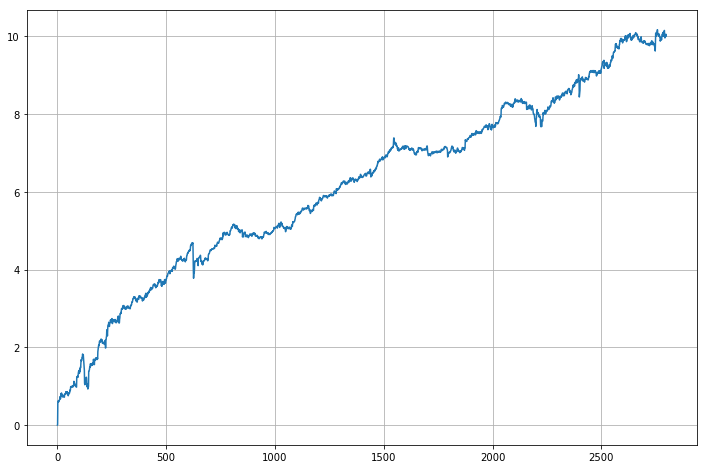

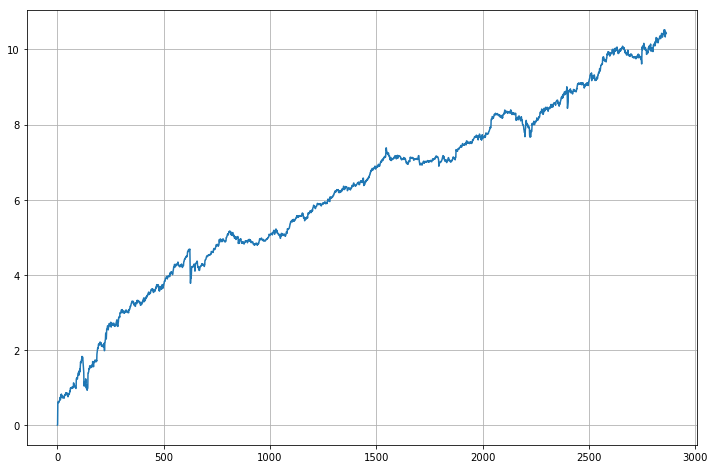

In [ ]:
Q = 2
profits = np.empty([0])
tops_all = []
bottoms_all = []
for i in log_progress(range(len(split_points))):
    start = split_points[i]
    stop = split_points[i + 1] + 1 if i < len(split_points) - 1 else len(spfull_log)
    stocks = spchangesets[i]
    stocks_i, = np.where(np.vectorize(lambda s: s in stocks)(spstocks))
    N = len(stocks_i)
    stocks_prices = spfull_log[start - T:stop, stocks_i]
    stocks_pairs = calculate_pairwise_diffs(stocks_prices)
    ts, codes, weights, trading_signal = stat_arb(stocks_pairs[:-1], T=T, d=0, return_trading_signal=True)
    for t, cs, ws in log_progress(list(partition_as(ts, codes, weights))):
        pairs = decode_pairs(cs, N=N)
        prefs, cons = calculate_preference_flow(pairs, ws, return_consistency=True)
        pref_values = np.array(list(prefs.values()))
        order = np.argsort(np.abs(list(pref_values)))
        pref_values = pref_values[order]
        m = np.abs(pref_values[-Q if Q <= len(sorteds) else 0])
        M = np.abs(pref_values[-1])
        tops = np.array([k for k, v in prefs.items() if v >= m])
        bottoms = np.array([k for k, v in prefs.items() if v <= -m])
        tops_all.append(tops)
        bottoms_all.append(bottoms)
        new_profits = np.hstack([trade_singles(stocks_prices, t, tops, inv=False),
                                 trade_singles(stocks_prices, t, bottoms, inv=True)]) / (len(tops) + len(bottoms))
        profits = np.hstack([profits, np.sum(new_profits)])
    
    avg = np.mean(profits) * 255
    std = np.std(profits) * np.sqrt(255)
    sharpe = avg / std
    print('step {}: profit {}, avg {}, std {}, sharpe {}'.format(i + 1, np.sum(profits), avg, std, sharpe))
    plt.figure()
    plt.plot(np.cumsum(profits))
    plt.grid()

total: profit -0.192374853826768, avg -0.007239608578191534, std 0.7507139137089247, sharpe -0.009643631809651736
accuracy: 0.5202184179456907


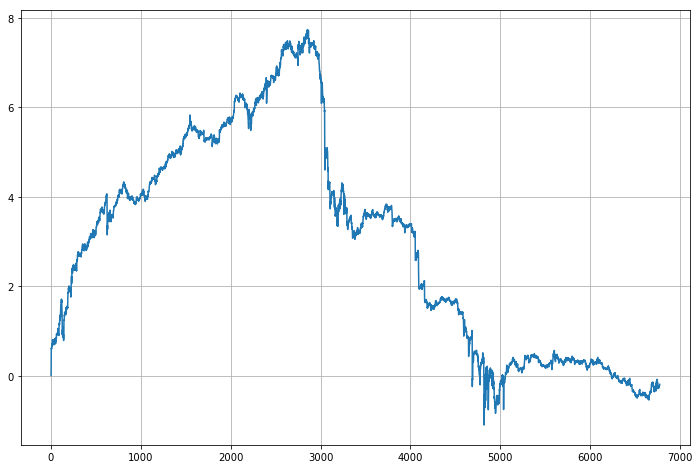

In [148]:
tops_turnover = turnover_ratio(tops_all)
bottoms_turnover = turnover_ratio(bottoms_all)
tops_count = np.array(list(map(len, tops_all)))
bottoms_count = np.array(list(map(len, bottoms_all)))
total_turnover = (tops_count * tops_turnover + bottoms_count * bottoms_turnover) / (tops_count + bottoms_count)

balanced_profits = profits - total_turnover * 1e-3
avg = np.mean(balanced_profits) * 255
std = np.std(balanced_profits) * np.sqrt(255)
sharpe = avg / std
print('total: profit {}, avg {}, std {}, sharpe {}'.format(np.sum(balanced_profits), avg, std, sharpe))
plt.figure()
plt.plot(np.cumsum(balanced_profits))
plt.grid()
print('accuracy: {}'.format(np.sum(profits > 0) / len(profits)))

step 1: profit 1.46973125317401, avg 4.684768369492157, std 1.997322047932774, sharpe 2.3455247862210737
step 2: profit 1.4273875740002686, avg 1.8859265874096813, std 1.6313121470701277, sharpe 1.1560795343777992
step 3: profit 2.421839822687191, avg 2.24570601740085, std 1.6266889923102867, sharpe 1.3805380303283488
step 4: profit 2.9513668032052878, avg 2.0015918479184798, std 1.5051222735232108, sharpe 1.3298533169887428


KeyboardInterrupt: 

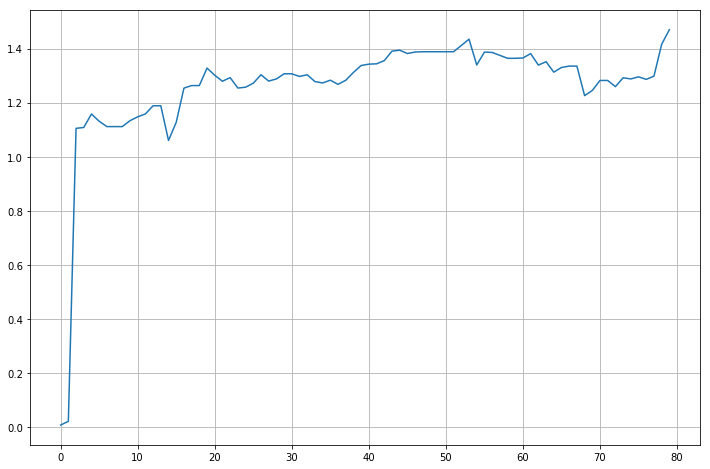

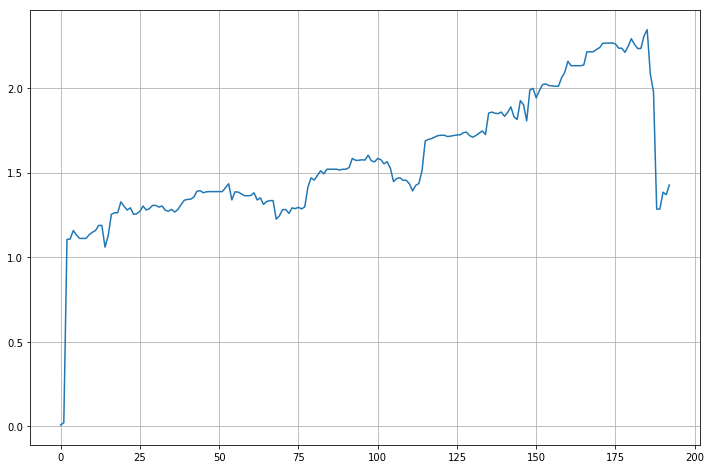

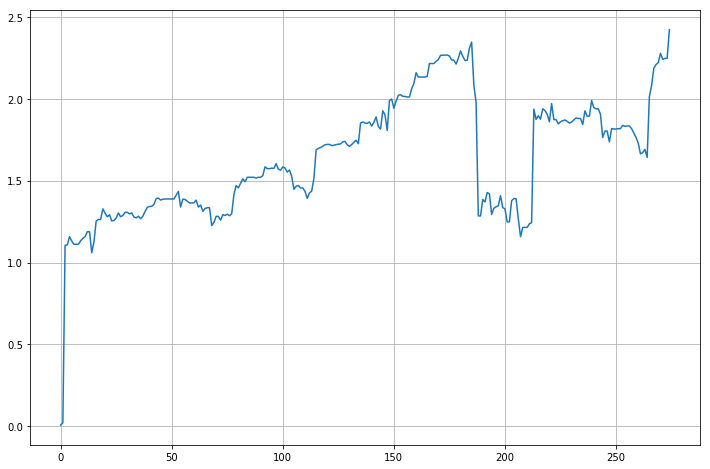

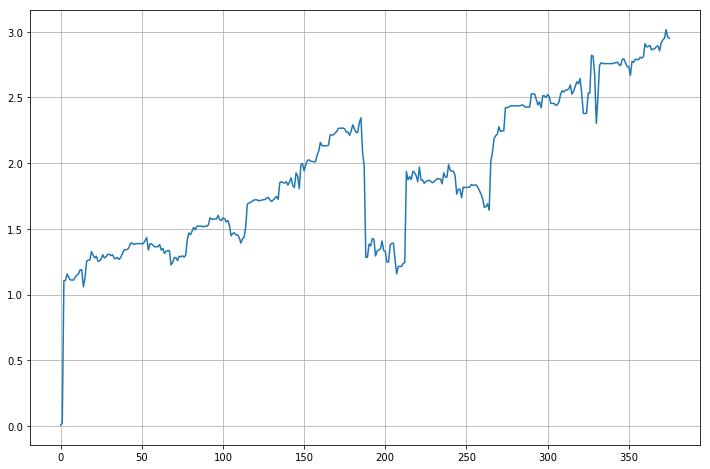

In [102]:
Q = 100
profits = np.empty([0])
tops_all = np.empty([0])
bottoms_all = np.empty([0])
for i in log_progress(range(len(split_points))):
    start = split_points[i]
    stop = split_points[i + 1] + 1 if i < len(split_points) - 1 else len(spfull_log)
    stocks = spchangesets[i]
    stocks_i, = np.where(np.vectorize(lambda s: s in stocks)(spstocks))
    N = len(stocks_i)
    stocks_prices = spfull_log[start - T:stop, stocks_i]
    stocks_pairs = calculate_pairwise_diffs(stocks_prices)
    ts, codes, weights, trading_signal = stat_arb(stocks_pairs[:-1], T=T, d=0, return_trading_signal=True)
    for t, cs, ws in partition_as(ts, codes, weights):
        pairs = decode_pairs(cs, N=N)
        prefs, cons = calculate_preference_flow(pairs, ws, return_consistency=True)
        pref_values = np.array(list(prefs.values()))
        order = np.argsort(np.abs(list(pref_values)))
        pref_values = pref_values[order]
        m = np.abs(pref_values[-Q if Q <= len(sorteds) else 0])
        M = np.abs(pref_values[-1])
        c = (1 - cons) * m + cons * M
        tops = np.array([k for k, v in prefs.items() if v >= c])
        bottoms = np.array([k for k, v in prefs.items() if v <= -c])        
        new_profits = np.hstack([trade_singles(stocks_prices, t, tops, inv=False),
                                 trade_singles(stocks_prices, t, bottoms, inv=True)]) / (len(tops) + len(bottoms))
        profits = np.hstack([profits, new_profits])
    
    avg = np.mean(profits) * 255
    std = np.std(profits) * np.sqrt(255)
    sharpe = avg / std
    print('step {}: profit {}, avg {}, std {}, sharpe {}'.format(i + 1, np.sum(profits), avg, std, sharpe))
    plt.figure()
    plt.plot(np.cumsum(profits))
    plt.grid()

In [ ]:
avg = np.mean(profits) * 255
std = np.std(profits) * np.sqrt(255)
sharpe = avg / std
print('step {}: profit {}, avg {}, std {}, sharpe {}'.format(i + 1, np.sum(profits), avg, std, sharpe))
plt.figure()
plt.plot(np.cumsum(profits[4000:5000]))
plt.grid()

tops_turnover = turnover_ratio(tops_all)
bottoms_turnover = turnover_ratio(bottoms_all)
tops_count = np.array(list(map(len, tops_all)))
bottoms_count = np.array(list(map(len, bottoms_all)))
total_turnover = (tops_count * tops_turnover + bottoms_count * bottoms_turnover) / (tops_count + bottoms_count)

balanced_profits = profits - total_turnover * 1e-3
avg = np.mean(balanced_profits) * 255
std = np.std(balanced_profits) * np.sqrt(255)
sharpe = avg / std
print('total: profit {}, avg {}, std {}, sharpe {}'.format(np.sum(balanced_profits), avg, std, sharpe))
plt.figure()
plt.plot(np.cumsum(balanced_profits))
plt.grid()
print('accuracy: {}'.format(np.sum(profits > 0) / len(profits)))

In [ ]:
Q = 2
profits = np.empty([0])
tops_all = []
bottoms_all = []
cons_all = np.empty([0])

for i in log_progress(range(59, 65)):  # log_progress(list(range(len(split_points)))):
    start = split_points[i]
    stop = split_points[i + 1] + 1 if i < len(split_points) - 1 else len(spfull_log)
    stocks = spchangesets[i]
    stocks_i, = np.where(np.vectorize(lambda s: s in stocks)(spstocks))
    N = len(stocks_i)
    stocks_prices = spfull_log[start - T:stop, stocks_i]
#     stocks_prices = stocks_prices[:, np.argsort(np.var(stocks_prices, axis=0))[:-int(N * 0.2)]]
    # stocks_pairs = calculate_pairwise_diffs(stocks_prices)
    ts, codes, weights, trading_signal = stat_arb(stocks_prices[:-1], T=T, d=0, return_trading_signal=True)
    _, stock_prices_vars = rolling_mean_variance(stocks_prices, T)
    for t, cs, ws in partition_as(ts, codes, weights):
        pairs = decode_pairs(cs, N=N)
        blacklist = np.argsort(stock_prices_vars[t - T])[4 * N // 5:] + 1  # oznake kreću od 1        
        valid_pairs, = np.where(np.apply_along_axis(lambda x: np.all(np.vectorize(lambda y: y not in blacklist)(x)), 1, pairs))        
        pairs = pairs[valid_pairs]
        ws = ws[valid_pairs]
        prefs, cons = calculate_preference_flow(pairs, ws, return_consistency=True)
        cons_all = np.hstack([cons_all, cons])
    #     prefs = {k: v / (np.std(stocks_prices[t - T:t, k - 1]) * np.std(stocks_prices[t - T:t, k - 1])) 
    #              for k, v in prefs.items()}
        pref_values = np.array(list(prefs.values()))
        order = np.argsort(np.abs(pref_values))
        pref_values_ordered = pref_values[order]
        m = np.abs(pref_values_ordered[-Q if Q <= len(pref_values_ordered) else 0])
        M = np.abs(pref_values_ordered[-1])
        tops = np.array([k for k, v in prefs.items() if v >= m])
        tops_all.append(tops)
        bottoms = np.array([k for k, v in prefs.items() if v <= -m])
        bottoms_all.append(bottoms)
        new_profits = np.mean(np.hstack([trade_singles(stocks_prices, t, tops, inv=False),
                                         trade_singles(stocks_prices, t, bottoms, inv=True)]))        
        profits = np.hstack([profits, new_profits])
        print(t, tops, bottoms, new_profits, np.sum(profits))

    avg = np.mean(profits) * 255
    std = np.std(profits) * np.sqrt(255)
    sharpe = avg / std
    print('step {}: profit {}, avg {}, std {}, sharpe {}'.format(i + 1, np.sum(profits), avg, std, sharpe))
#     plt.figure()
#     plt.plot(np.cumsum(profits))
#     plt.grid()

C:\Users\Helena\ipynb\utility\functions.py:404: RuntimeWarning: invalid value encountered in greater_equal
  ts, codes = np.where(np.abs(trading_signal) >= d)


60 [444] [415] -0.00674194073031 -0.00674194073031
61 [169] [171] 0.00996317572373 0.00322123499343
62 [169] [179] 7.71034333158e-05 0.00329833842674
63 [169] [179] -0.00497727150594 -0.0016789330792
64 [169] [179] 0.0 -0.0016789330792
65 [169] [179] -0.00288193616314 -0.00456086924234
66 [169] [179] -0.00219762551104 -0.00675849475338
67 [169] [179] 0.00249867595526 -0.00425981879812
68 [169] [261] 0.00392151844814 -0.000338300349974
69 [169 455] [] 0.00345124510026 0.00311294475029
70 [180 455] [] 0.0115334082738 0.0146463530241
71 [180] [230] 0.0134223915569 0.0280687445809
72 [180] [157] 0.0047831060579 0.0328518506388
73 [216 435] [] 0.0028306486333 0.0356824992721
74 [ 10 449] [] 0.00287217165342 0.0385546709256
75 [ 10 216] [] -0.00414327432819 0.0344113965974
76 [ 10 216] [] 0.00397705944687 0.0383884560442
77 [ 41 216] [] 0.000677208936163 0.0390656649804
78 [257] [323] 0.00429440810389 0.0433600730843
79 [257] [323] -0.00842159915265 0.0349384739316
80 [] [215 323] 0.0 0.0349

profit 0.014911864200772628, avg 0.058500390326108, std 0.2900030305000389, sharpe 0.2017233758738261
total: profit -0.05453792769719117, avg -0.21395648558128844, std 0.29266304820789996, sharpe -0.7310676455105446
mean turnover: 1.068458336891751
mean consistency: 0.6258392229602329
accuracy: 0.6


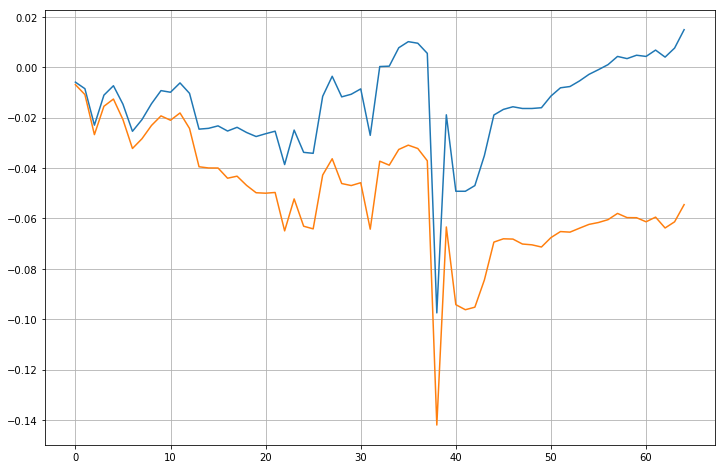

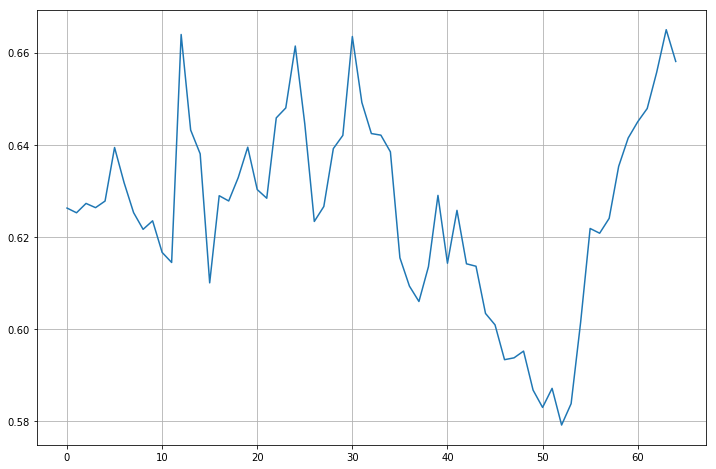

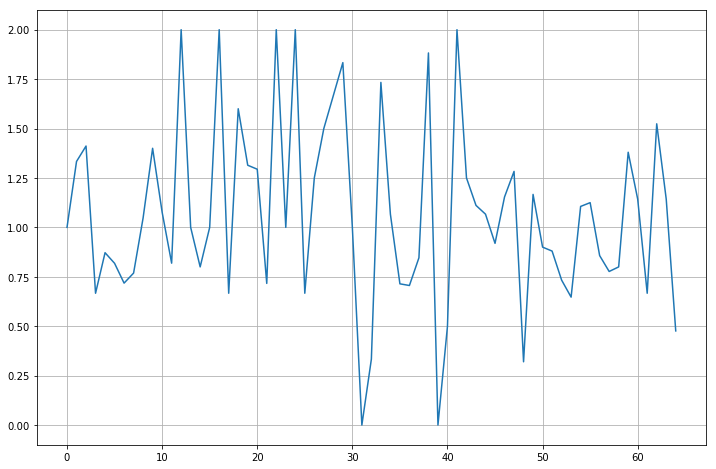

In [35]:
avg = np.mean(profits) * 255
std = np.std(profits) * np.sqrt(255)
sharpe = avg / std
print('profit {}, avg {}, std {}, sharpe {}'.format(np.sum(profits), avg, std, sharpe))
plt.figure()
plt.plot(np.cumsum(profits))

tops_turnover = turnover_ratio(tops_all)
bottoms_turnover = turnover_ratio(bottoms_all)
tops_count = np.array(list(map(len, tops_all)))
bottoms_count = np.array(list(map(len, bottoms_all)))
total_turnover = (tops_count * tops_turnover + bottoms_count * bottoms_turnover) / (tops_count + bottoms_count)

balanced_profits = profits - total_turnover * 1e-3
avg = np.mean(balanced_profits) * 255
std = np.std(balanced_profits) * np.sqrt(255)
sharpe = avg / std
print('total: profit {}, avg {}, std {}, sharpe {}'.format(np.sum(balanced_profits), avg, std, sharpe))
plt.plot(np.cumsum(balanced_profits))
plt.grid()
plt.figure()
plt.plot(cons_all)
plt.grid()
plt.figure()
plt.plot(total_turnover)
plt.grid()
print('mean turnover: {}'.format(np.mean(total_turnover)))
print('mean consistency: {}'.format(np.mean(cons_all)))
print('accuracy: {}'.format(np.sum(profits > 0) / len(profits)))

DPHIQ UN


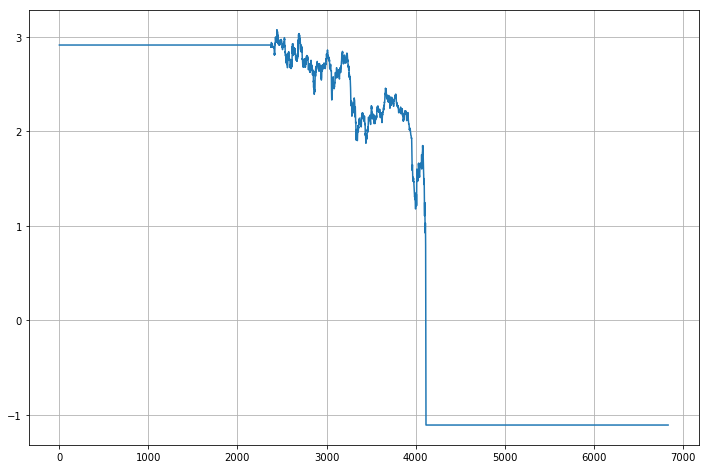

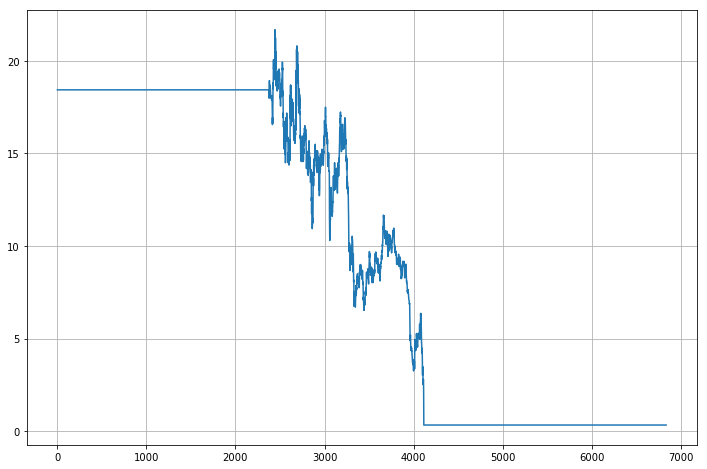

In [15]:
stock_A = spfull_log[:, stocks_i[389 - 1]]
print(spstocks[stocks_i[389 - 1]])

plt.figure()
plt.plot(stock_A)
plt.grid()

plt.figure()
plt.plot(np.exp(stock_A))
plt.grid()

In [38]:
stocks_prices_dev_sort = stocks_prices[:, np.argsort(np.var(stocks_prices[:T], axis=0))[::-1]]

(array([9], dtype=int64),)

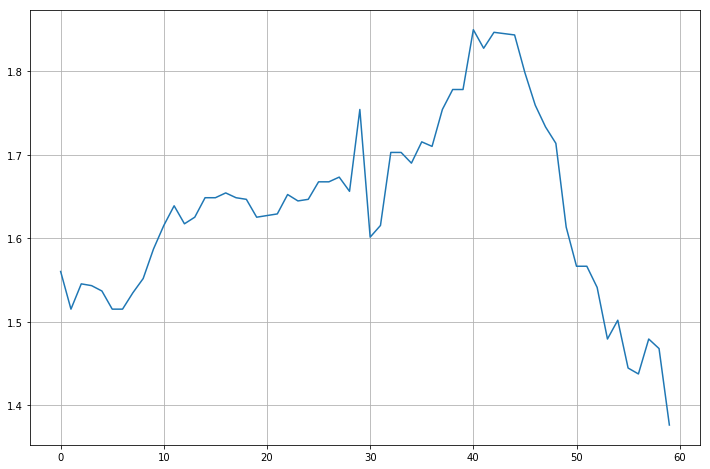

In [43]:
plt.plot(stocks_prices_dev_sort[:T, 9])
plt.grid()
np.where(np.argsort(np.var(stocks_prices[:T], axis=0))[::-1] == 389 - 1)

## CROBEX

In [25]:
cr_full = np.load('data/crobex_prices.npy')
cr_stocks = np.load('data/crobex_stocks.npy')
cr_dates = np.load('data/crobex_dates.npy')
cr_changedates = np.load('data/crobex_change_dates.npy')
cr_changelist = np.load('data/crobex_change_list.npy')

days, N = cr_full.shape
P = N * (N - 1) // 2
cr_log = np.log(cr_full)

T = 60

In [3]:
print(np.sum(np.isnan(cr_full)))

# NaN fix
for t in range(1, cr_full.shape[0]):
    where_nan, = np.where(np.isnan(cr_full[t]))
    cr_full[t, where_nan] = cr_full[t - 1, where_nan]

for t in range(cr_full.shape[0] - 1, 0, -1):
    where_nan, = np.where(np.isnan(cr_full[t - 1]))
    cr_full[t - 1, where_nan] = cr_full[t, where_nan]

cr_log = np.log(cr_full)
print(np.sum(np.isnan(cr_full)))

315960
0


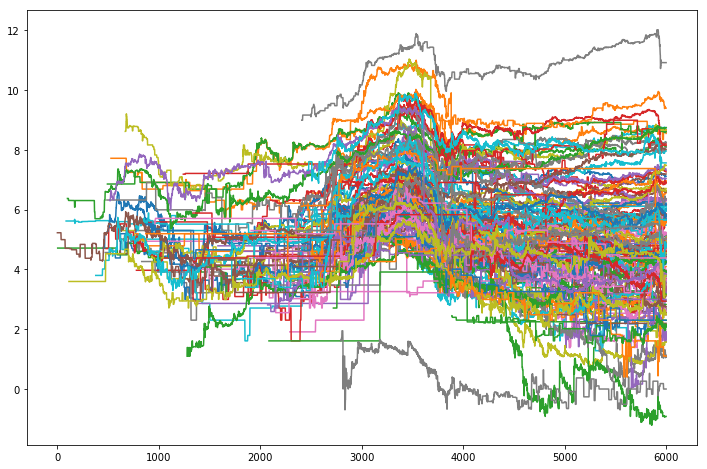

In [65]:
plt.plot(cr_log);

In [9]:
cr_changesets = [set(s) for s in [[p for p in r if p != ''] for r in cr_changelist.T]]
split_points, = np.where(np.vectorize(lambda s: s in cr_changedates)(cr_dates))
# split_points je za jedan kraći od changesets-a (na kraju)
# prvi split point je 54, a period T je 60, da bude lakše stavit ćemo da je prvi split point 60
if split_points[0] < T:
    split_points[0] = T

print(split_points)
print(np.diff(split_points))
print(list(map(len, cr_changesets)))

[ 783  936 1046 1196 1321 1491 1621 1751 1886 2011 2061 2146 2274 2406 2536
 2666 2796 2926 3056 3186 3212 3316 3451 3541 3580 3711 3732 3841 3971 4101
 4176 4231 4361 4453 4491 4576 4621 4756 4881 4924 5016 5064 5146 5259 5276
 5367 5406 5536 5569 5628 5666 5796 5841]
[153 110 150 125 170 130 130 135 125  50  85 128 132 130 130 130 130 130
 130  26 104 135  90  39 131  21 109 130 130  75  55 130  92  38  85  45
 135 125  43  92  48  82 113  17  91  39 130  33  59  38 130  45]
[8, 10, 10, 8, 6, 8, 10, 9, 11, 11, 10, 11, 10, 8, 10, 12, 17, 21, 23, 25, 25, 30, 30, 32, 30, 28, 28, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 23, 22, 25, 24, 25, 26, 25, 25, 25, 24, 23, 25, 24]


In [115]:
Q = 1000
profits = np.empty([0])
tops_all = []
bottoms_all = []
cons_all = np.empty([0])
cs_lens = []

NO_SHORT_SELLING = True

for i in log_progress(list(range(len(split_points)))):
    start = split_points[i]
    stop = split_points[i + 1] + 1 if i < len(split_points) - 1 else len(cr_log)
    stocks = cr_changesets[i]
    stocks_i, = np.where(np.vectorize(lambda s: s in stocks)(cr_stocks))
    N = len(stocks_i)
    stocks_prices = cr_log[start - T:stop, stocks_i]
    # stocks_pairs = calculate_pairwise_diffs(stocks_prices)
    ts, codes, weights, trading_signal = stat_arb(stocks_prices[:-1], T=T, d=0.0, return_trading_signal=True)

    for t, cs, ws in partition_as(ts, codes, weights):
        pairs = decode_pairs(cs, N=N)
        prefs, cons = calculate_preference_flow(pairs, ws, return_consistency=True)
        cons_all = np.hstack([cons_all, cons])
    #     prefs = {k: v / (np.std(stocks_prices[t - T:t, k - 1]) * np.std(stocks_prices[t - T:t, k - 1])) 
    #              for k, v in prefs.items()}
        pref_values = np.array(list(prefs.values()))
        if NO_SHORT_SELLING:
            order = np.argsort(pref_values)
        else:
            order = np.argsort(np.abs(pref_values))
        pref_values_ordered = pref_values[order]
        m = np.abs(pref_values_ordered[-Q if Q <= len(pref_values_ordered) else 0])
        M = np.abs(pref_values_ordered[-1])
        tops = np.array([k for k, v in prefs.items() if v >= m])
        if NO_SHORT_SELLING:
            tops = np.empty([0])
            
        tops_all.append(tops)
        bottoms = np.array([k for k, v in prefs.items() if v <= -m])
        bottoms_all.append(bottoms)
        
        new_profits = np.mean(np.hstack([trade_singles(stocks_prices, t, tops, inv=False),
                                         trade_singles(stocks_prices, t, bottoms, inv=True)]))
        if new_profits != new_profits:
            new_profits = 0.0
            
#         print(t, tops, bottoms, new_profits, len(cs), m)
#         print(pref_values)
        profits = np.hstack([profits, new_profits])

    avg = np.mean(profits) * 255
    std = np.std(profits) * np.sqrt(255)
    sharpe = avg / std
    print('step {}: profit {}, avg {}, std {}, sharpe {}'.format(i + 1, np.sum(profits), avg, std, sharpe))

step 1: profit 0.38674112283006323, avg 0.6445685380501054, std 0.7199979283499941, sharpe 0.8952366564821251
step 2: profit 1.9761971963399798, avg 1.9160847340938967, std 0.9365209660092136, sharpe 2.045960318709027
step 3: profit 2.551523537894754, avg 1.575395889014921, std 1.0144888005220833, sharpe 1.5528962845170686
step 4: profit 3.032109918466729, avg 1.4371524706487286, std 0.9254134901002654, sharpe 1.5529841373860003
step 5: profit 4.796516369773357, avg 1.7275588619946414, std 0.8770904274158501, sharpe 1.9696473795575509
step 6: profit 5.496011319148062, avg 1.6724139455641476, std 0.8385926771653001, sharpe 1.9943102188984272
step 7: profit 6.695105098640122, avg 1.7636898761913544, std 0.8155273579865833, sharpe 2.1626372909740814
step 8: profit 7.361542953896848, avg 1.7018979630495885, std 0.7699546171608531, sharpe 2.2103873723430647
step 9: profit 8.339989522786457, avg 1.7318382152366012, std 0.7512158658432769, sharpe 2.3053802428580594
step 10: profit 9.308174142

C:\Users\Helena\ipynb\utility\functions.py:404: RuntimeWarning: invalid value encountered in greater_equal
  ts, codes = np.where(np.abs(trading_signal) >= d)



step 24: profit 17.651001415268716, avg 1.6092260854106266, std 0.6067734817379571, sharpe 2.6521035177763284
step 25: profit 18.307465696237024, avg 1.5944001887091672, std 0.613713534561653, sharpe 2.5979550701093355
step 26: profit 17.989465959315364, avg 1.555548938496242, std 0.6275995759712983, sharpe 2.4785691355651602
step 27: profit 17.503048279666416, avg 1.4595413052043609, std 0.6438412380227202, sharpe 2.2669273401727272
step 28: profit 17.848163796599103, avg 1.4276291618986108, std 0.6373878714014092, sharpe 2.2398122492662393
step 29: profit 18.267204890705873, avg 1.4038991100452074, std 0.6296517974502448, sharpe 2.229643615296983
step 30: profit 18.20967755328626, avg 1.3685434058614783, std 0.6243169873576205, sharpe 2.192064982331725
step 31: profit 18.31536302640295, avg 1.3545294581591507, std 0.6208436001101023, sharpe 2.1817563359257215
step 32: profit 18.56585201631301, avg 1.3231672063051474, std 0.615680927577286, sharpe 2.149111897150738
step 33: profit 18

profit 21.248224877800443, avg 1.038783999969155, std 0.6021866318724278, sharpe 1.7250200269959157
total: profit 17.843224877800438, avg 0.8723202346317316, std 0.6017124587875061, sharpe 1.4497293880029003
mean turnover: 0.6527990797546013
mean consistency: 0.9544165050302564
accuracy: 0.4290644171779141
[]


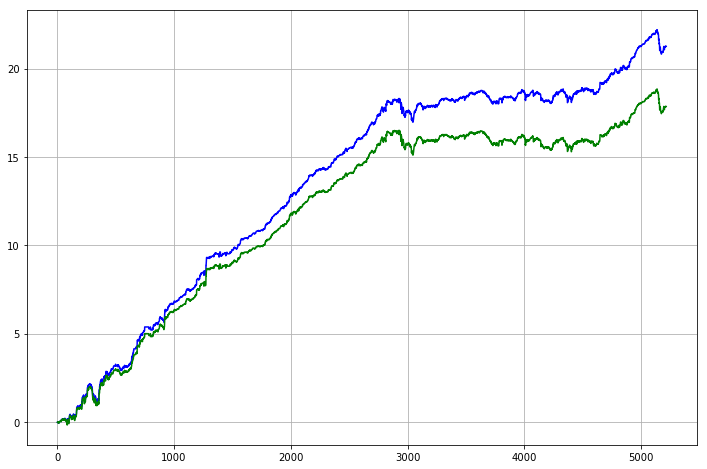

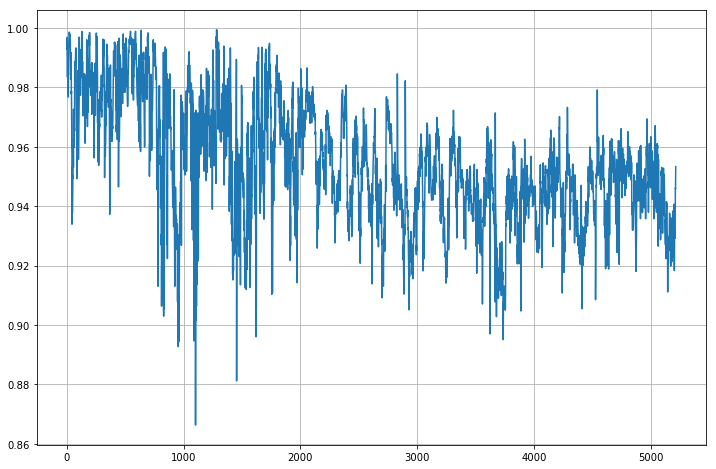

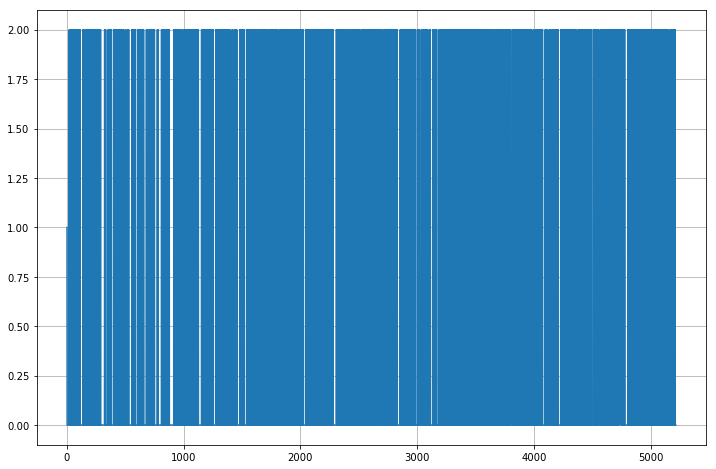

In [95]:
avg = np.mean(profits) * 255
std = np.std(profits) * np.sqrt(255)
sharpe = avg / std
print('profit {}, avg {}, std {}, sharpe {}'.format(np.sum(profits), avg, std, sharpe))
plt.figure()
plt.plot(np.cumsum(profits), 'b')

tops_turnover = turnover_ratio(tops_all)
bottoms_turnover = turnover_ratio(bottoms_all)
tops_count = np.array(list(map(len, tops_all)))
bottoms_count = np.array(list(map(len, bottoms_all)))
total_turnover = (tops_count * tops_turnover + bottoms_count * bottoms_turnover) / (tops_count + bottoms_count)

balanced_profits = profits - total_turnover * 1e-3
avg = np.mean(balanced_profits) * 255
std = np.std(balanced_profits) * np.sqrt(255)
sharpe = avg / std
print('total: profit {}, avg {}, std {}, sharpe {}'.format(np.sum(balanced_profits), avg, std, sharpe))
plt.plot(np.cumsum(balanced_profits), 'g')
plt.grid()
plt.figure()
plt.plot(cons_all)
plt.grid()
plt.figure()
plt.plot(total_turnover)
plt.grid()
print('mean turnover: {}'.format(np.mean(total_turnover)))
print('mean consistency: {}'.format(np.mean(cons_all)))
print('accuracy: {}'.format(np.sum(profits > 0) / len(profits)))
print(cs_lens)